&nbsp;

# 프로젝트 : 더 멋진 번역기 만들기

&nbsp;

## Step.0 라이브러리 확인

<hr>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import re
import os
import io
import time
import random


import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
## ▼ matplotlib 한글 시각화를 위한 폰트 변경 ────────────
import matplotlib.font_manager as fm
%config InlineBackend.figure_format = 'retina'
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)
## ▲ matplotlib 한글 시각화를 위한 폰트 변경 ────────────


## Attention 시각화
import seaborn


## Progress Bar
from tqdm.notebook import tqdm
from tqdm import tqdm_notebook 


## SentencePiece
import sentencepiece as spm


print(tf.__version__)
print(np.__version__)
print(mpl.__version__)
print("─" * 32)
print("✔️")

2.6.0
1.21.4
3.4.3
────────────────────────────────
✔️


&nbsp;

## Step 1. 데이터 다운로드

<hr>

&nbsp;

▶ ☁️클라우드 심볼릭 링크 생성

~~~shell
$ ln -s ~/data ~/aiffel/transformer/data
~~~

&nbsp;

## Step 2. 데이터 정제 및 토큰화

<hr>

&nbsp;

### ▶ 파일 경로 지정

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"
print("✔️")

✔️


&nbsp;

### ▶ 데이터 정제

In [3]:
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)
    
    print("─" * 32)
    print("  kor_path：", kor_path)
    print("  len(kor)：", len(kor))
    print("  eng_path：", eng_path)
    print("  len(eng)：", len(eng))
    print("─" * 32)
    
    
    ## 중복 제거
    print("  → 중복값 제거 … ")
    ko_data, en_data = list(zip(*set(zip(kor, eng))))
    
    print("─" * 32)
    print("  len(ko_data)：", len(ko_data))
    print("  len(en_data)：", len(en_data))
    print("─" * 32)
    
    cleaned_corpus = pd.DataFrame(zip(ko_data, en_data), columns = ['kor', 'eng'])

    return cleaned_corpus

데이터 정제를 실행하여 데이터프레임을 생성하고, 샘플로 일부 데이터를 출력해보았다.

In [4]:
cleaned_corpus = clean_corpus(kor_path, eng_path)
cleaned_corpus.sample(5)

────────────────────────────────
  kor_path： /aiffel/aiffel/transformer/data/korean-english-park.train.ko
  len(kor)： 94123
  eng_path： /aiffel/aiffel/transformer/data/korean-english-park.train.en
  len(eng)： 94123
────────────────────────────────
  → 중복값 제거 … 
────────────────────────────────
  len(ko_data)： 78968
  len(en_data)： 78968
────────────────────────────────


,kor,eng
39803,다우너 장관과 호주 대리인인 필립 루덕 장군은 자카르타에서 정상급 보안수행이 지체돼...,Downer and Australian Attorney-General Philip ...
75597,“강한 반향은 인도 내 에서 공동의 반발을 불러일으키게 되어 있습니다만 이는 인도와...,“The broader shockwaves are designed to create...
38447,고건 대통령 권한 대행은 수요일 저녁에 긴급 장관 회의에서 “추가 파병 원칙에는 변...,``There is no change in our plans to send addi...
22188,라스무센 총리는 환호하는 자유당 지지자들에게 “국민들이 이 정부를 신뢰하고 있다는 ...,"""Everything indicates that the government can ..."
5448,최근들어 연방기금금리가 1%가 됐던 시기는 지난 2003년 6월과 2004년 6월이었다.,The cut put the central bank's federal funds r...


In [5]:
cleaned_corpus.tail(5)

,kor,eng
78963,"그는 ""온실가스 감축에 대한 정량화를 목표로 한 논의가 앞으로도 이뤄져야 하며 이 ...","""Somewhere down the road, quantifiable targets..."
78964,환경문제에 앞장서고 2003년 이라크전에 반대한 고어 전 부통령이 다시 대선에 출마...,Gore's environmental advocacy and his early op...
78965,동해안을 따라 큰 폭풍이 형성되고 있습니다.,"Along the East Coast, a big storm is revving up:"
78966,이번 이스라엘 기습은 1년여만에 가장 많은 사상자를 낳았다.,It was the deadliest single Israeli raid in mo...
78967,지난해 열린 호주 오픈에서 세레나의 언니인 비너스 윌리엄스를 1회전에서 물리쳤던 피...,The match was then stopped for nearly six hour...


&nbsp;

### ▶ 데이터 정제 함수 정의

약어 정규화를 위해 정규화 사전을 가져와 사용하도록 하겠다.

In [6]:
contractions = {
    "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
    "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
    "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
    "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
    "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
    "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
    "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
    "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
    "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
    "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
    "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
    "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
    "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
    "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


불용어(stopwords) 제거를 위해 불용어도 사용하도록 하겠다.

In [7]:
stopwords_en = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stopwords_ko = ["아", "휴", "아이구", "아이쿠", "아이고", "어", "나", "우리", "저희", "따라", "의해", "을", "를", "에", "의", "가", "으로", "로", "에게", "뿐이다", "의거하여", "근거하여", "입각하여", "기준으로", "예하면", "예를 들면", "예를 들자면", "저", "소인", "소생", "저희", "지말고", "하지마", "하지마라", "다른", "물론", "또한", "그리고", "비길수 없다", "해서는 안된다", "뿐만 아니라", "만이 아니다", "만은 아니다", "막론하고", "관계없이", "그치지 않다", "그러나", "그런데", "하지만", "든간에", "논하지 않다", "따지지 않다", "설사", "비록", "더라도", "아니면", "만 못하다", "하는 편이 낫다", "불문하고", "향하여", "향해서", "향하다", "쪽으로", "틈타", "이용하여", "타다", "오르다", "제외하고", "이 외에", "이 밖에", "하여야", "비로소", "한다면 몰라도", "외에도", "이곳", "여기", "부터", "기점으로", "따라서", "할 생각이다", "하려고하다", "이리하여", "그리하여", "그렇게 함으로써", "하지만", "일때", "할때", "앞에서", "중에서", "보는데서", "으로써", "로써", "까지", "해야한다", "일것이다", "반드시", "할줄알다", "할수있다", "할수있어", "임에 틀림없다", "한다면", "등", "등등", "제", "겨우", "단지", "다만", "할뿐", "딩동", "댕그", "대해서", "대하여", "대하면", "훨씬", "얼마나", "얼마만큼", "얼마큼", "남짓", "여", "얼마간", "약간", "다소", "좀", "조금", "다수", "몇", "얼마", "지만", "하물며", "또한", "그러나", "그렇지만", "하지만", "이외에도", "대해 말하자면", "뿐이다", "다음에", "반대로", "반대로 말하자면", "이와 반대로", "바꾸어서 말하면", "바꾸어서 한다면", "만약", "그렇지않으면", "까악", "툭", "딱", "삐걱거리다", "보드득", "비걱거리다", "꽈당", "응당", "해야한다", "에 가서", "각", "각각", "여러분", "각종", "각자", "제각기", "하도록하다", "와", "과", "그러므로", "그래서", "고로", "한 까닭에", "하기 때문에", "거니와", "이지만", "대하여", "관하여", "관한", "과연", "실로", "아니나다를가", "생각한대로", "진짜로", "한적이있다", "하곤하였다", "하", "하하", "허허", "아하", "거바", "와", "오", "왜", "어째서", "무엇때문에", "어찌", "하겠는가", "무슨", "어디", "어느곳", "더군다나", "하물며", "더욱이는", "어느때", "언제", "야", "이봐", "어이", "여보시오", "흐흐", "흥", "휴", "헉헉", "헐떡헐떡", "영차", "여차", "어기여차", "끙끙", "아야", "앗", "아야", "콸콸", "졸졸", "좍좍", "뚝뚝", "주룩주룩", "솨", "우르르", "그래도", "또", "그리고", "바꾸어말하면", "바꾸어말하자면", "혹은", "혹시", "답다", "및", "그에 따르는", "때가 되어", "즉", "지든지", "설령", "가령", "하더라도", "할지라도", "일지라도", "지든지", "몇", "거의", "하마터면", "인젠", "이젠", "된바에야", "된이상", "만큼	어찌됏든", "그위에", "게다가", "점에서 보아", "비추어 보아", "고려하면", "하게될것이다", "일것이다", "비교적", "좀", "보다더", "비하면", "시키다", "하게하다", "할만하다", "의해서", "연이서", "이어서", "잇따라", "뒤따라", "뒤이어", "결국", "의지하여", "기대여", "통하여", "자마자", "더욱더", "불구하고", "얼마든지", "마음대로", "주저하지 않고", "곧", "즉시", "바로", "당장", "하자마자", "밖에 안된다", "하면된다", "그래", "그렇지", "요컨대", "다시 말하자면", "바꿔 말하면", "즉", "구체적으로", "말하자면", "시작하여", "시초에", "이상", "허", "헉", "허걱", "바와같이", "해도좋다", "해도된다", "게다가", "더구나", "하물며", "와르르", "팍", "퍽", "펄렁", "동안", "이래", "하고있었다", "이었다", "에서", "로부터", "까지", "예하면", "했어요", "해요", "함께", "같이", "더불어", "마저", "마저도", "양자", "모두", "습니다", "가까스로", "하려고하다", "즈음하여", "다른", "다른 방면으로", "해봐요", "습니까", "했어요", "말할것도 없고", "무릎쓰고", "개의치않고", "하는것만 못하다", "하는것이 낫다", "매", "매번", "들", "모", "어느것", "어느", "로써", "갖고말하자면", "어디", "어느쪽", "어느것", "어느해", "어느 년도", "라 해도", "언젠가", "어떤것", "어느것", "저기", "저쪽", "저것", "그때", "그럼", "그러면", "요만한걸", "그래", "그때", "저것만큼", "그저", "이르기까지", "할 줄 안다", "할 힘이 있다", "너", "너희", "당신", "어찌", "설마", "차라리", "할지언정", "할지라도", "할망정", "할지언정", "구토하다", "게우다", "토하다", "메쓰겁다", "옆사람", "퉤", "쳇", "의거하여", "근거하여", "의해", "따라", "힘입어", "그", "다음", "버금", "두번째로", "기타", "첫번째로", "나머지는", "그중에서", "견지에서", "형식으로 쓰여", "입장에서", "위해서", "단지", "의해되다", "하도록시키다", "뿐만아니라", "반대로", "전후", "전자", "앞의것", "잠시", "잠깐", "하면서", "그렇지만", "다음에", "그러한즉", "그런즉", "남들", "아무거나", "어찌하든지", "같다", "비슷하다", "예컨대", "이럴정도로", "어떻게", "만약", "만일", "위에서 서술한바와같이", "인 듯하다", "하지 않는다면", "만약에", "무엇", "무슨", "어느", "어떤", "아래윗", "조차", "한데", "그럼에도 불구하고", "여전히", "심지어", "까지도", "조차도", "하지 않도록", "않기 위하여", "때", "시각", "무렵", "시간", "동안", "어때", "어떠한", "하여금", "네", "예", "우선", "누구", "누가 알겠는가", "아무도", "줄은모른다", "줄은 몰랏다", "하는 김에", "겸사겸사", "하는바", "그런 까닭에", "한 이유는", "그러니", "그러니까", "때문에", "그", "너희", "그들", "너희들", "타인", "것", "것들", "너", "위하여", "공동으로", "동시에", "하기 위하여", "어찌하여", "무엇때문에", "붕붕", "윙윙", "나", "우리", "엉엉", "휘익", "윙윙", "오호", "아하", "어쨋든", "만 못하다	하기보다는", "차라리", "하는 편이 낫다", "흐흐", "놀라다", "상대적으로 말하자면", "마치", "아니라면", "쉿", "그렇지 않으면", "그렇지 않다면", "안 그러면", "아니었다면", "하든지", "아니면", "이라면", "좋아", "알았어", "하는것도", "그만이다", "어쩔수 없다", "하나", "일", "일반적으로", "일단", "한켠으로는", "오자마자", "이렇게되면", "이와같다면", "전부", "한마디", "한항목", "근거로", "하기에", "아울러", "하지 않도록", "않기 위해서", "이르기까지", "이 되다", "로 인하여", "까닭으로", "이유만으로", "이로 인하여", "그래서", "이 때문에", "그러므로", "그런 까닭에", "알 수 있다", "결론을 낼 수 있다", "으로 인하여", "있다", "어떤것", "관계가 있다", "관련이 있다", "연관되다", "어떤것들", "에 대해", "이리하여", "그리하여", "여부", "하기보다는", "하느니", "하면 할수록", "운운", "이러이러하다", "하구나", "하도다", "다시말하면", "다음으로", "에 있다", "에 달려 있다", "우리", "우리들", "오히려", "하기는한데", "어떻게", "어떻해", "어찌됏어", "어때", "어째서", "본대로", "자", "이", "이쪽", "여기", "이것", "이번", "이렇게말하자면", "이런", "이러한", "이와 같은", "요만큼", "요만한 것", "얼마 안 되는 것", "이만큼", "이 정도의", "이렇게 많은 것", "이와 같다", "이때", "이렇구나", "것과 같이", "끼익", "삐걱", "따위", "와 같은 사람들", "부류의 사람들", "왜냐하면", "중의하나", "오직", "오로지", "에 한하다", "하기만 하면", "도착하다", "까지 미치다", "도달하다", "정도에 이르다", "할 지경이다", "결과에 이르다", "관해서는", "여러분", "하고 있다", "한 후", "혼자", "자기", "자기집", "자신", "우에 종합한것과같이", "총적으로 보면", "총적으로 말하면", "총적으로", "대로 하다", "으로서", "참", "그만이다", "할 따름이다", "쿵", "탕탕", "쾅쾅", "둥둥", "봐", "봐라", "아이야", "아니", "와아", "응", "아이", "참나", "년", "월", "일", "령", "영", "일", "이", "삼", "사", "오", "육", "륙", "칠", "팔", "구", "이천육", "이천칠", "이천팔", "이천구", "하나", "둘", "셋", "넷", "다섯", "여섯", "일곱", "여덟", "아홉", "령", "영"]

print("불용어(영문) :", len(stopwords_en))
print("불용어(한글) :", len(stopwords_ko))

불용어(영문) : 179
불용어(한글) : 675


정제를 위해 전처리 함수를 아래와 같이 정의한다.

In [8]:
from bs4 import BeautifulSoup 

def preprocess_sentence(sentence, remove_stopwords=True, lang_kor=True):
   
    sentence = sentence.lower().strip()    ## 소문자로 변경
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)    ## 단어와 구두점 사이에 공백 추가

    ## 한글과 영문(a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환.
    ## 공백을 제외하고 모두 제거
    
    if (lang_kor):
        sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣?.!,\s]", " ", sentence)
        if (remove_stopwords):
            tokens = " ".join(word for word in sentence.split() if not word in stopwords_ko if len(word) > 1)
        
    else:
        sentence = re.sub(r"[^a-zA-Z?.!,\s]", " ", sentence)
        if (remove_stopwords):
            tokens = " ".join(word for word in sentence.split() if not word in stopwords_en if len(word) > 1)
        sentence = " ".join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
        sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
        sentence = re.sub("[m]{2,}", "mm", sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
        
        
    sentence = re.sub(r"\s+", " ", sentence.strip())    ## 다수 개의 공백을 하나의 공백으로 치환
    sentence = re.sub(r"\s+", " ", sentence.strip())    ## 다수 개의 공백을 하나의 공백으로 치환
    sentence = sentence.strip()
    
    return sentence

전처리 전, 후의 결과를 확인하기 위해 함수를 호출해 보자.

In [9]:
temp_text = "Everything I bought wasn't great, <br>infact I <font>ordered<font/> " + \
"twice and the third ordered was<br/>for my mother and father. ummmmmmm yeah."

print("Text :", preprocess_sentence(temp_text, lang_kor=False) ,"\n")


temp_text = """
너와 나의 연결 고리! 80 8 bass 소리 프리마 비스타 음악 소리~ 메타형 과의 연결 고리
우린 서울 시의 머리 나머 지는 전부 쩌리 커져 가는 돈 벌이 돈 돈 돈 벌이 워
누가 나를 막아 내가 제일 잘 나가 나는 여자 친구 바꿔 그래 매일 밤 마다 워
나는 니들 에게 감 동을 주지 않아 만약 정말 필요하 다면 걍 돈을 주지 나는 워
내가 나타나면 (나면) 지붕에 불이 붙지 (붙지) 난 그녀들 바탕화면 (화면) 종종 내 꿈을 꾸지
경쟁자들은 꿈도 못 꿔 (못 꿔) 이 담에 네가 죽고 나면 널 기억 못해 아 무도 심 지어 네 훅도 워"""
print("Text :", preprocess_sentence(temp_text, lang_kor=True) ,"\n")

Text : everything i bought wasn t great , infact i ordered twice and the third ordered wasfor my mother and father . umm yeah . 

Text : 너와 나의 연결 고리 ! 소리 프리마 비스타 음악 소리 메타형 과의 연결 고리 우린 서울 시의 머리 나머 지는 전부 쩌리 커져 가는 돈 벌이 돈 돈 돈 벌이 워 누가 나를 막아 내가 제일 잘 나가 나는 여자 친구 바꿔 그래 매일 밤 마다 워 나는 니들 에게 감 동을 주지 않아 만약 정말 필요하 다면 걍 돈을 주지 나는 워 내가 나타나면 지붕에 불이 붙지 난 그녀들 바탕화면 종종 내 꿈을 꾸지 경쟁자들은 꿈도 못 꿔 이 담에 네가 죽고 나면 널 기억 못해 아 무도 심 지어 네 훅도 워 



전처리를 적용한다.

In [10]:
import warnings
warnings.filterwarnings("ignore")


## 전처리 수행
cleaned_corpus["kor"] = cleaned_corpus["kor"].map(
    lambda x: preprocess_sentence(x, lang_kor=True, remove_stopwords=False))
cleaned_corpus["eng"] = cleaned_corpus["eng"].map(
    lambda x: preprocess_sentence(x, lang_kor=False, remove_stopwords=False))

print("✔️")

✔️


In [11]:
## 전처리 과정에서 내용이 사라진 행들이 있을 수 있다.
## 이것들을 nan 으로 변경하여 결측값으로 만들고, 결측값 확인을 다시 수행
cleaned_corpus["kor"].replace("", np.nan, inplace=True)
cleaned_corpus["eng"].replace("", np.nan, inplace=True)
print(cleaned_corpus["kor"].isnull().sum())
print(cleaned_corpus["eng"].isnull().sum())

## Null 값이 존재하는 행 제거
cleaned_corpus = cleaned_corpus.dropna(how = "any")
print("✔️")


print(cleaned_corpus["kor"].isnull().sum())
print(cleaned_corpus["eng"].isnull().sum())

50
37
✔️
0
0


전처리 결과를 확인해보자.

In [12]:
cleaned_corpus.shape

(78886, 2)

In [13]:
cleaned_corpus.sample(5)

,kor,eng
23476,"한국 정부 , 북한 핵실험 비난 .",the latest diplomatic efforts to dissuade the ...
58453,싱가포르와 유럽을 잇는 노선은 내년 월 시행된다 .,a superjumbo service on the singapore london r...
5722,"일 아침 , 이들은 로켓 추진 수류탄 , 박격포 , 작은 소총을 미국과 이라크군에 ...","on sunday morning , they fired rocket propelle..."
40181,침대에서 자고 있던 세 남성이 침대 맡에 놓인 스테레오 스피커가 떨어지며 부상을 입...,an year old man was hit when his stereo speake...
15622,웸박은 후반 분 다시 그라운드로 돌아왔으며 기세를 몰아 몇분 후 헤더 오레일리가 골...,"wambach came back on in the th minute , and he..."


In [14]:
cleaned_corpus.tail(5)

,kor,eng
78963,그는 온실가스 감축에 대한 정량화를 목표로 한 논의가 앞으로도 이뤄져야 하며 이 과...,"somewhere down the road , quantifiable targets..."
78964,환경문제에 앞장서고 년 이라크전에 반대한 고어 전 부통령이 다시 대선에 출마할 것인...,gore s environmental advocacy and his early op...
78965,동해안을 따라 큰 폭풍이 형성되고 있습니다 .,"along the east coast , a big storm is revving up"
78966,이번 이스라엘 기습은 년여만에 가장 많은 사상자를 낳았다 .,it was the deadliest single israeli raid in mo...
78967,지난해 열린 호주 오픈에서 세레나의 언니인 비너스 윌리엄스를 회전에서 물리쳤던 피론...,the match was then stopped for nearly six hour...


문장이 너무 길거나 짧은 것은 제외하도록 한다.

In [15]:
# cleaned_corpus = cleaned_corpus.loc[cleaned_corpus['kor'].apply(lambda x: (30 < len(x) <= 90))]
# cleaned_corpus = cleaned_corpus.loc[cleaned_corpus['eng'].apply(lambda x: (60 < len(x) <= 180))]

여기까지는 이전 프로젝트와 거의 유사한 데이터 정제를 진행하고, 유사한 데이터의 수량으로 준비하였다.

In [16]:
cleaned_corpus.shape

(78886, 2)

In [17]:
len(cleaned_corpus)

78886

&nbsp;

### ▶ 토큰화

`한글 말뭉치` 와 `영문 말뭉치` 를 각각 분리한 후, 정제하여 **토큰화**를 진행한다.

토큰화에는 Sentencepiece를 활용한다.

아래에서는 `generate_tokenizer()` 함수를 정의한다.

> - 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 한다. (기본: 20,000)<br>&nbsp;
> 
> - 학습 후 저장된 **`model`** 파일을 **`SentencePieceProcessor()`** 클래스에 **`Load()`** 한 후 반환한다.<br>&nbsp;
>
> - 특수 토큰의 인덱스를 아래와 동일하게 지정한다.<br>
  **`<PAD> : 0 / <BOS> : 1 / <EOS> : 2 / <UNK> : 3`** 
  
`generate_tokenizer()`함수는 최종적으로 `ko_tokenizer` 과 `en_tokenizer` 를 반환한다.

여기서, `en_tokenizer` 에 `set_encode_extra_options("bos:eos")` 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 한다.

우선 SentencePiece 모델을 훈련시키는 함수를 만든다.

In [18]:
## 파라메터
PATH_DIR = os.getenv("HOME")+"/aiffel/transformer/"
# VOCAB_SIZE = SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000
VOCAB_SIZE = SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000
MODEL_TYPE = "unigram"

In [19]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성한다.
def generate_tokenizer(
    corpus, lang, vocab_size,
    pad_id=0, bos_id=1, eos_id=2, unk_id=3):
    
    ## 임시파일의 위치를 지정
    temp_file = PATH_DIR + "temp_" + lang + ".txt"
    
    ## corpus 를 임시파일에 쓴다
    with open(temp_file, "w", encoding='utf8') as f:
        for row in tqdm(corpus):   
            f.write(str(row) + "\n")

    ## SentencePiece Parameter
    _input = " --input=" + temp_file
    _model_prefix = " --model_prefix=" + lang + "_spm_tokenizer"
    _model_type = " --model_type=" + MODEL_TYPE
    _vocab_size = " --vocab_size=" + str(vocab_size)
    _pad_id = " --pad_id=" + str(pad_id)    ## 0
    _bos_id = " --bos_id=" + str(bos_id)    ## 1
    _eos_id = " --eos_id=" + str(eos_id)    ## 2
    _unk_id = " --unk_id=" + str(unk_id)    ## 3
    
    params = ("{}" * 8).format(
        _input, _model_prefix, _model_type, _vocab_size,
        _pad_id, _bos_id, _eos_id, _unk_id ).strip()
        
    ## SentencePiece 모델을 훈련
    sp_model = spm.SentencePieceTrainer.Train(params)
    sp_preproc = spm.SentencePieceProcessor()
    sp_preproc.Load(lang + "_spm_tokenizer" + ".model")
    
    print (type(sp_preproc))
    
    return sp_preproc

In [20]:
ko_tokenizer = generate_tokenizer(
    cleaned_corpus["kor"], lang="ko", vocab_size=VOCAB_SIZE)
en_tokenizer = generate_tokenizer(
    cleaned_corpus["eng"], lang="en", vocab_size=VOCAB_SIZE)

  0%|          | 0/78886 [00:00<?, ?it/s]

<class 'sentencepiece.SentencePieceProcessor'>


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/transformer/temp_ko.txt --model_prefix=ko_spm_tokenizer --model_type=unigram --vocab_size=20000 --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/transformer/temp_ko.txt
  input_format: 
  model_prefix: ko_spm_tokenizer
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  us

  0%|          | 0/78886 [00:00<?, ?it/s]

<class 'sentencepiece.SentencePieceProcessor'>


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/transformer/temp_en.txt --model_prefix=en_spm_tokenizer --model_type=unigram --vocab_size=20000 --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/transformer/temp_en.txt
  input_format: 
  model_prefix: en_spm_tokenizer
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  us

In [21]:
print(type(ko_tokenizer))
print(type(en_tokenizer))

<class 'sentencepiece.SentencePieceProcessor'>
<class 'sentencepiece.SentencePieceProcessor'>


) Saving vocabs: en_spm_tokenizer.vocab


토큰화를 수행한다.

In [22]:
def sp_tokenize(spp_tok, corpus, vocab_size, lang):
    
    ## Vocab 단어사전
    with open("./" + lang + "_spm_tokenizer" + ".vocab", "r") as f:
        vocab = f.readlines()
        
    word_index = {}
    index_word = {}
    
    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]
        word_index.update({word:idx})
        index_word.update({idx:word})
    
    
    ## BOS, EOS 설정
    if (lang == "en"):
        spp_tok.set_encode_extra_options("bos:eos")

    print(type(spp_tok))
        
    ## Tensor
    tensor = []
    
    for w in corpus:
#         print(type(w))
#         print(w)
#         print(spp_tok.EncodeAsIds(str(w)))
        tensor.append(spp_tok.EncodeAsIds(w))
    
    return tensor, word_index, index_word

토크나이저를 만들었으면 토큰화를 수행한다.

이 때 토큰길이 제한도 적용하도록 한다.

In [23]:
## 토큰화
kor_corpus, ko_w2i, ko_i2w = sp_tokenize(
    ko_tokenizer, cleaned_corpus["kor"], VOCAB_SIZE, "ko")

eng_corpus, en_w2i, en_i2w = sp_tokenize(
    en_tokenizer, cleaned_corpus["eng"], VOCAB_SIZE, "en")


# 토큰의 길이가 50 이하인 문장만 남깁니다. 
src_corpus = []
tgt_corpus = []

for idx in tqdm(range(len(cleaned_corpus))):
#     if ((4 < len(kor_corpus[idx]) <= 50) and (4 < len(eng_corpus[idx]) <= 50)):
    if ((2 < len(kor_corpus[idx]) <= 25) and (2 < len(eng_corpus[idx]) <= 50)):
        src_corpus.append(kor_corpus[idx])
        tgt_corpus.append(eng_corpus[idx])
#     else:
#         ## 제외되는 데이터들을 출력
#         print(len(kor_corpus[idx]), kor_corpus[idx])
#         print(len(eng_corpus[idx]), eng_corpus[idx])
#         print()

        
## Padding
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

<class 'sentencepiece.SentencePieceProcessor'>
<class 'sentencepiece.SentencePieceProcessor'>


  0%|          | 0/78886 [00:00<?, ?it/s]

In [24]:
print("len(src_corpus) :", len(src_corpus))
print("len(tgt_corpus) :", len(tgt_corpus))

len(src_corpus) : 44312
len(tgt_corpus) : 44312


&nbsp;

## Step 3. 모델 설계

<hr>

&nbsp;

### ▶ Positional Encoding

트랜스포머에서 단어의 위치 정보를 얻기 위해서 각 단어의 임베딩 벡터에 위치 정보들을 더하여 모델의 입력으로 사용하는 것을 포지셔널 인코딩 이라고 한다.

여기서 위치 정보 값을 만들기 위해 아래 두 개의 함수를 사용한다.

$$ \large PE_{(pos, 2i)} = sin(pos/10000^{2i/d_{model})} $$

$$ \large PE_{(pos,2i+1)} = cos(pos/10000^{2i/d_{model})} $$


트랜스포머는 사인 함수와 코사인 함수의 값을 임베딩 벡터에 더해주므로서 단어의 순서 정보를 더하여 준다.

$pos$는 입력 문장에서의 임베딩 벡터의 위치를 나타내며, $i$는 임베딩 벡터 내의 차원의 인덱스를 의미한다.

위의 식에 따르면 임베딩 벡터 내의 각 차원의 인덱스가 짝수인 경우에는 사인 함수의 값을 사용하고 홀수인 경우에는 코사인 함수의 값을 사용한다.

위의 수식에서 $(pos, 2i)$일 때는 사인 함수를 사용하고, $(pos, 2i+1)$일 때는 코사인 함수를 사용하고 있음을 확인할 수 있다.

 $d_{model}$은 트랜스포머의 모든 층의 출력 차원을 의미하는 트랜스포머의 하이퍼파라미터이다. 앞으로 보게 될 트랜스포머의 각종 구조에서 의 값이 계속해서 등장한다. 임베딩 벡터 또한 $d_{model}$의 차원을 가지는데, 실제 논문에서는 512의 값을 가진다.

In [25]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

&nbsp;

### ▶ Multi-Head Attention

Positional Embedding이 된 문장으로부터 Attention을 추출하는 부분이다.

Multi-Head Attention은 여러 개의 서브 모듈이 결합하여 이루어져있다.

 - Embedding된 입력을 **Head 수로 분할**하는 `split_heads()`
 
 - 분할된 입력으로부터 **Attention 값을 구하는** `scaled_dot_product_attention()`
 
 - 연산이 종료되고 분할된 **Head를 다시 하나로 결합**시켜주는 `combine_heads()`
 
 이렇게 `MultiHeadAttention` 클래스를 정의한다.

#### Scaled Dot-Product Attention

$${1 \over \sqrt{d_k}} : \text{Scaled Dot-Product Attention} $$



다만 여기에서 Masking 부분이 빠져있는데, 

마스크의 형태를 결정하는 것이 모델 외부의 훈련 데이터이기 때문에 그를 생성하는 함수는 `MultiHeadAttention` 외부에 정의되도록 한다.

마스크를 생성하는 함수는 모델을 완성한 후에 구현할 예정이므로, 이후 생성된 마스크를 처리할 수 있도록 `scaled_dot_product_attention()` 에는 

~~~python
# scaled_qk: Attention을 위한 Softmax 직전의 Scaled QK
if mask is not None:
    scaled_qk += (mask * -1e9)
~~~

의 내용을 추가한다.

In [26]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

        
    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        
        """
        Scaled QK 값 구하기
        """
        
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        # scaled_qk: Attention을 위한 Softmax 직전의 Scaled QK
        if mask is not None:
            scaled_qk += (mask * -1e9)
            
        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """ 

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    
    def combine_heads(self, x):
        
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

&nbsp;

### ▶ Position-wise Feed-Forward Network

인코더와 디코더에서 공통적으로 가지고 있는 서브층이다.

Position-wise Feed-Forward Network 는 쉽게 말하면 Fully-connected Feed-Forward Network 라고 해석할 수 있다. 식은 아래와 같다.

$$ FFN(x) = max(0,xW_{1}+b_{1})W_{2}+b_{2} $$

`d_ff` 는 논문의 설명대로라면 2048 이고, `d_model` 은 512 다.

`[ batch x length x d_model ]` 의 입력을 받아 `w_1` 이 2048차원으로 매핑하고 활성함수 ReLU를 적용한 후, 다시 `w_2` 를 통해 512차원으로 되돌리는 과정을 거치게 된다.

In [27]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

&nbsp;

### ▶ Encoder 레이어 구현하기

인코더의 입력으로 들어가는 문장에는 패딩이 있을 수 있으므로, 어텐션 시 패딩 토큰을 제외하도록 패딩 마스크를 사용한다. 이는 MultiHeadAttention 함수의 mask의 인자값으로 padding_mask가 사용되는 이유이다.

인코더는 총 두 개의 서브층으로 이루어지는데, 멀티 헤드 어텐션과 피드 포워드 신경망이다. 각 서브층 이후에는 드롭 아웃, 잔차 연결과 Layer Normalization을 수행한다.

아래의 코드는 하나의 인코더 블록. 즉, 하나의 인코더 층을 구현하는 코드이다.

트랜스포머는 num_layers 개수만큼의 인코더 층을 사용하므로 이를 여러번 쌓는 코드를 별도 구현해줄 필요가 있다.

In [28]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

print("슝=3")

슝=3


&nbsp;

### ▶ Decoder 레이어 구현하기

디코더는 총 세 개의 서브층으로 구성된다. 첫번째와 두번째 서브층 모두 멀티 헤드 어텐션이지만, 첫번째 서브층은 mask의 인자값으로 look_ahead_mask가 들어가는 반면, 두번째 서브층은 mask의 인자값으로 padding_mask가 들어가는 것을 확인할 수 있다.

이는 첫번째 서브층은 마스크드 셀프 어텐션을 수행하기 때문이다. 세 개의 서브층 모두 서브층 연산 후에는 드롭 아웃, 잔차 연결, Layer Normalization 이 수행되는 것을 확인할 수 있다.

인코더와 마찬가지로 디코더도 $\text{num_layers}$ 개 만큼 쌓는 코드가 필요하다.

In [29]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

&nbsp;

### ▶ Encoder / Decoder 클래스 정의

인코더 층을 num_layers개만큼 쌓고, 마지막 인코더 층에서 얻는 (seq_len, d_model) 크기의 행렬을 디코더로 보내주므로서 트랜스포머 인코더의 인코딩 연산이 끝나게 된다. 

아래의 코드는 인코더 층을 num_layers개만큼 쌓는 코드이다.

In [30]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

print("슝=3")

슝=3


이렇게 구현된 인코더는 총 $\text{num_layers}$ 만큼의 층 연산을 순차적으로 한 후에 마지막 층의 인코더의 출력을 디코더에게 전달한다. 인코더 연산이 끝났으면 디코더 연산이 시작되어 디코더 또한 $\text{num_layers}$ 만큼의 연산을 하는데, 이때마다 인코더가 보낸 출력을 각 디코더 층 연산에 사용한다.

&nbsp;

포지셔널 인코딩 후 디코더 층을 $\text{num_layers}$의 개수만큼 쌓는 코드이다.

In [31]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        
        ## 디코더를 num_layers개 쌓기
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

print("슝=3")

슝=3


&nbsp;

### ▶ Transformer 클래스 구현

지금까지 구현한 인코더와 디코더 함수를 조합하여 트랜스포머를 조립한다.

인코더의 출력은 디코더에서 인코더-디코더 어텐션에서 사용되기 위해 디코더로 전달해준다. 그리고 디코더의 끝단에는 다중 클래스 분류 문제를 풀 수 있도록, vocab_size 만큼의 뉴런을 가지는 출력층을 추가한다.

In [32]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

&nbsp;

### ▶ Masking

앞서 구현한 스케일드 닷 프로덕트 어텐션 함수 내부를 보면 mask라는 값을 인자로 받아서, 이 mask값에다가 -1e9 라는 아주 작은 음수값을 곱한 후 어텐션 스코어 행렬에 더해주고 있다.

~~~python
# scaled_qk: Attention을 위한 Softmax 직전의 Scaled QK
if mask is not None:
    scaled_qk += (mask * -1e9)
~~~

이는 입력 문장에 〈PAD〉 토큰이 있을 경우 어텐션에서 사실상 제외하기 위한 연산이다.

패딩 마스크를 구현하는 방법은 입력된 정수 시퀀스에서 패딩 토큰의 인덱스인지, 아닌지를 판별하는 함수를 구현하는 것이다. 아래의 `generate_padding_mask()` 함수는 정수 시퀀스에서 0인 경우에는 1로 변환하고, 그렇지 않은 경우에는 0으로 변환하는 함수이다.

In [33]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

print("슝=3")

슝=3


시각화

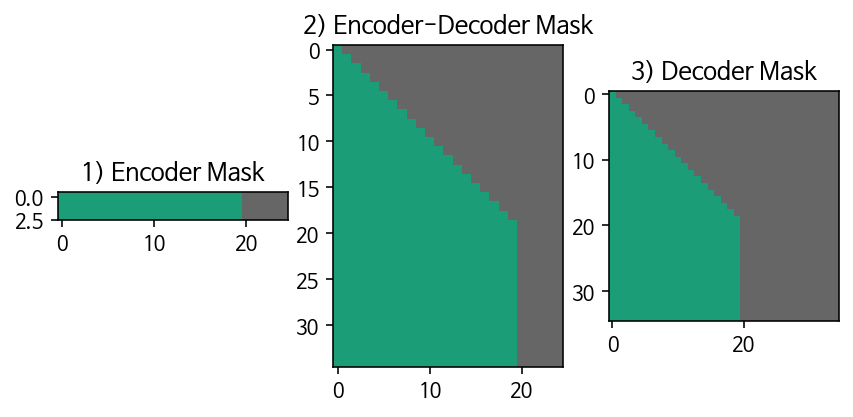

In [34]:
batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

&nbsp;

### ▶ Learning Rate 와 Optimizer

트랜스포머를 훈련하는 데에는 Adam Optimizer를 사용했는데, 특이한 점은 Learning Rate를 수식에 따라 변화시키며 사용했다는 것으로, 수식은 아래와 같다.

$$ lrate = d^{-0.5}_{model}\text{ }·\text{ }\min(step\_num^{-0.5},\text{ }step\_num\text{ }·\text{ }warmup\_steps^{-1.5}) $$


위 수식을 따르게 되면 $warmup\_steps$ 까지는 $lrate$ 가 **선형적으로 증가** 하고, 이후에는 $step\_num$ 에 비례해 **점차 감소하는 모양새** 를 보이게 된다.

이전 노드에서 Learning Rate를 `numpy` 로 간단히 구현을 했었는데, 여기서는 **Tensorflow 상에서 잘 구동될 수 있도록** `LearningRateSchedule` 클래스를 상속받아 구현한다.

In [35]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

print("슝=3")

슝=3


이와 같은 Learning Rate를 사용하면 **초반 학습이 잘되지 않은 상태에서의 학습 효율**이 늘어나고, 어느 정도 학습이 된 후반에는 **디테일한 튜닝**을 통해 Global Minimum을 찾아가는 효과가 나게 된다. 학습의 초반과 후반의 구분은 `warmup_steps` 값에 따라 결정된다.

&nbsp;

## Step.4 훈련하기

<hr>

&nbsp;

훈련을 진행해보자.

> ###  **이후의 내용(이하의 내용) 에서, 훈련 부분 소항목들은, <br>노드에서 제시하고 있는 가이드라인을 따르도록 하겠다.**

1. **2 Layer**를 가지는 `Transformer`를 선언하세요.<br>
(하이퍼파라미터는 자유롭게 조절합니다.)

하이퍼파라미터는, 기본적으로 논문에서 base 모델로 사용한 파라미터를 대부분 적용하였다.

단, 노드의 훈련 가이드라인에서는, 2 Layer 를 가지는 Transformer 를 강조하고 있어서,

n_layer = 2 를 지정하도록 하였다.

Attention is all you need 논문에서 제시하는 근거는 아래의 자료에서 찾아 볼 수 있다.

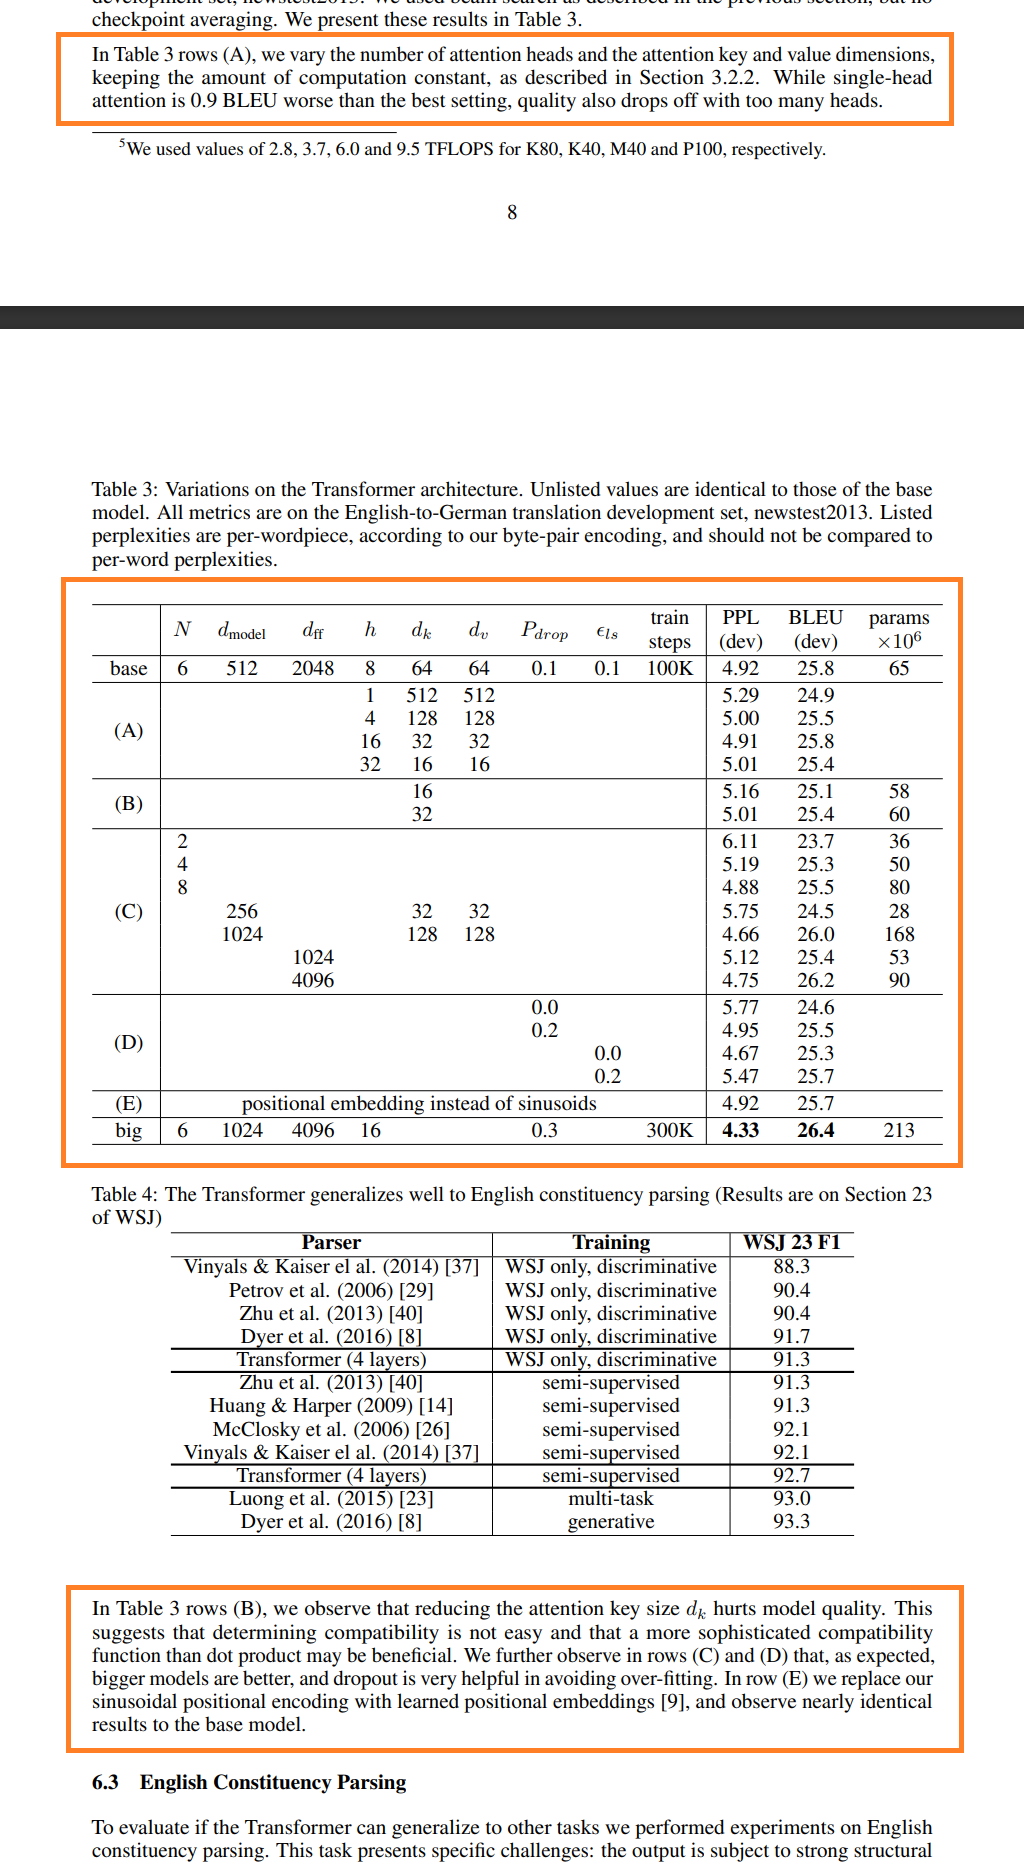

모델에서 몇개의 파라메터들을 변경하며 추가 실험을 진행하고 그 결과를 요약한

위의 내용들을 다시 요약하여 정리하면 다음과 같다.

 - (A)：head 가 너무 많으면 성능이 떨어진다.
 
   + NUM_HEADS 를 늘릴수록 loss 값과 accuracy 값에서 손해를 보는 것을 확인 하였다.<br>

&nbsp;

 - (B)：Attention key size $d_k$ 를 줄일수록 모델의 성능이 떨어지는 결과를 확인할 수 있다.
    
    + 논문에서 Attention 부분에서 다루고 있는 내용이다. 여기서는 이 부분은 다루지 않았다.<br>
    
&nbsp;

 - (C), (D)：모델의 크기가 커질수록 좋고, 드롭아웃 으로 과적합을 방지하는게 성능 향상에 도움이 된다.
 
   + D_MODEL 을 키우면서 Dropout 규제도 변화시키면서 훈련을 진행하였다.
   
   + Dropout 의 경우 논문에서는 0.0, 0.2, 0.3(big model) 을 사용하였고, 여기서도 실험시에 0.1 ~ 0.3 의 값을 사용하였다.<br>
   
&nbsp;
   
 - (E) 다른 포지셔널 인코딩을 사용해도 성능에 큰 차이는 없다.
 
   + 표에서 (E) 항목에 대해서 특별한 설명은 없고, 여기서도 다른 포지셔널 인코딩 방법이<br>
   무엇이 있으며, 어떻게 적용 해야 할 지 몰랐기 때문에, 이 부분은 적용 및 확인을 못했다.
 

In [36]:
## Hyperparameters

# n_layers = 2
# d_model = 512
# n_heads = 8
# d_ff = 2048
# dropout = 0.3
# warmup_steps = 4000    ## default 4000
# batch_size = 64        ##


## Hyperparameters
n_layers = 2
d_model = 512
n_heads = 8
d_ff = 2048
dropout = 0.3
warmup_steps = 4000    ## default 4000
batch_size = 64        ##
epochs = 20

In [37]:
# transformer = Transformer(
#     n_layers=2,
#     d_model=512,
#     n_heads=8,
#     d_ff=2048,
#     src_vocab_size=VOCAB_SIZE,
#     tgt_vocab_size=VOCAB_SIZE,
#     pos_len=len(cleaned_corpus),
#     dropout=0.2,
#     shared=True)


transformer = Transformer(
    n_layers=n_layers,
    d_model=d_model,
    n_heads=n_heads,
    d_ff=d_ff,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=64,
    dropout=dropout,
    shared=True)


２. 논문에서 사용한 것과 동일한 **Learning Rate Scheduler** 를 선언하고, 이를 포함하는 **Adam Optimizer** 를 선언하세요. (Optimizer의 파라미터 역시 논문과 동일하게 설정합니다.)

In [38]:
# learning_rate = LearningRateScheduler(512, warmup_steps=4000)
learning_rate = LearningRateScheduler(512, warmup_steps=warmup_steps)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

３. Loss 함수를 정의하세요.
Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, **Masking 되지 않은 입력의 개수로 Scaling** 하는 과정을 추가합니다. (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)

In [39]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

４. **`train_step 함수`** 를 정의하세요.<br>
**입력 데이터에 알맞은 Mask를 생성**하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다.

In [40]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

５. **학습을 진행합니다.**<br>
**매 Epoch 마다 제시된 예문에 대한 번역을 생성**하고, 멋진 번역이 생성되면 그때의 **하이퍼파라미터와 생성된 번역을 제출**하세요!

예문

~~~
1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.
~~~

<br>&nbsp;

결과(output)

~~~
Translations
> 1. obama is the president elect .
> 2. they are in the city .
> 3. they don t need to be a lot of drink .
> 4. seven other people have been killed in the attacks .

Hyperparameters
> n_layers: 2
> d_model: 512
> n_heads: 8
> d_ff: 2048
> dropout: 0.3

Training Parameters
> Warmup Steps: 4000
> Batch Size: 64
> Epoch At: 5
~~~

&nbsp;

In [41]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [42]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences(
        [tokens],
        maxlen=enc_train.shape[-1],
        padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [43]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, 
              src_tokenizer, tgt_tokenizer, 
              plot_attention=False, minimal=False):
    
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    if (minimal):
        return result
    
    print("─" * 32)
    print()
    print('▷ Input                ：%s' % (sentence))
    print()
    print('▷ Predicted translation：{}'.format(result))
    print()

    if plot_attention:
        visualize_attention(
            pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

&nbsp;

In [44]:
# 학습
# from tqdm import tqdm_notebook 

# BATCH_SIZE = 64
# EPOCHS = 20

BATCH_SIZE = batch_size
EPOCHS = epochs


examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                   dec_train[idx:idx+BATCH_SIZE],
                   transformer, optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    
    
    buff_exam = ""
    buff_tran = ""
    
    for i, example in enumerate(examples, start=1):
        buff_exam += str(i) + ". " + example + "\n"
        buff_tran += "> " + str(i)+". " + translate(
            example, transformer, ko_tokenizer, en_tokenizer, 
            plot_attention=False, minimal=True) + "\n"
        
    print("Examples")
    print()
    print(buff_exam)
    
    print("Translations")
    print()
    print(buff_tran)
    
    print()
    print("Hyperparameters")
    print("> " + "n_layers :", str(n_layers))
    print("> " + "d_model :", str(d_model))
    print("> " + "n_heads :", str(n_heads))
    print("> " + "d_ff :", str(d_ff))
    print("> " + "dropout :", str(dropout))
    print()
    
    print("Training Parameters")
    print("> " + "Warmup Steps :", str(warmup_steps))
    print("> " + "Batch Size :", str(batch_size))
    print("> " + "Epoch At :", str(epoch + 1))
        
    
    

  0%|          | 0/693 [00:00<?, ?it/s]

Examples

1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

Translations

> 1. obama s .
> 2. the new york , the first time .
> 3. the dow was no .
> 4. the death of the death of the first time in the first time , which was killed in the first time in the death of the death of the death of the first time .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 1


  0%|          | 0/693 [00:00<?, ?it/s]

Examples

1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

Translations

> 1. obama is not to be the first time .
> 2. the city solar market is a little bit of the city of the city of the city .
> 3. it was not just to be the right to be the right to be the right to be the right to be the right .
> 4. the death toll was killed in the death toll of the death toll , according to the death toll , according to the death toll .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 2


  0%|          | 0/693 [00:00<?, ?it/s]

Examples

1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

Translations

> 1. obama s president obama s president .
> 2. the city s urban urban areas .
> 3. it s not change .
> 4. the nine people were killed .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 3


  0%|          | 0/693 [00:00<?, ?it/s]

Examples

1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

Translations

> 1. president obama is due to speak .
> 2. the city of urban urban areas .
> 3. it is not a little thing .
> 4. the death toll is the death toll from the deaths of the deaths of the deaths of the deaths .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 4


  0%|          | 0/693 [00:00<?, ?it/s]

Examples

1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

Translations

> 1. obama is the president .
> 2. the city s pork is now .
> 3. coffee coffee is not a coffee option .
> 4. the death toll was killed .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 5


  0%|          | 0/693 [00:00<?, ?it/s]

Examples

1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

Translations

> 1. obama presidents mccain were president .
> 2. the city had a highly sunni city in sanford city .
> 3. it has not to do what it needs to do it .
> 4. the nine people were dead , but the government reports .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 6


  0%|          | 0/693 [00:00<?, ?it/s]

Examples

1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

Translations

> 1. president barack obama s obama s first black president .
> 2. the city s thicker thick .
> 3. there are no needs too early , but there are no needs too so called it s in the day , so called it s in the day .
> 4. the death toll from sunday night .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 7


  0%|          | 0/693 [00:00<?, ?it/s]

Examples

1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

Translations

> 1. obama holds president elect barack obama .
> 2. the city s p flamesed in the city .
> 3. there is no need to look at a minor .
> 4. the people were killed .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 8


  0%|          | 0/693 [00:00<?, ?it/s]

Examples

1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

Translations

> 1. president barack obama is president out london .
> 2. the city of flames licked .
> 3. there is no need for tracks cannot be needed .
> 4. the . magnitude were through the day .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 9


  0%|          | 0/693 [00:00<?, ?it/s]

Examples

1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

Translations

> 1. president obama is moving .
> 2. the city s photo waswhere in the city .
> 3. there is no need about your trip .
> 4. seven people were killed sunday .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 10


  0%|          | 0/693 [00:00<?, ?it/s]

Examples

1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

Translations

> 1. obama will surely lead the president .
> 2. the two fell near the sunni cities around the mountain , with a sunni youthful cities around per .
> 3. there is no need to be needed in the creation of a minor wound .
> 4. seven other people were killed .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 11


  0%|          | 0/693 [00:00<?, ?it/s]

Examples

1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

Translations

> 1. obama is president .
> 2. the story was installed the highest flames and a sixth consecutive day of your eyes .
> 3. there is no need to be red canceling the coffee .
> 4. the seven death toll rose to .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 12


  0%|          | 0/693 [00:00<?, ?it/s]

Examples

1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

Translations

> 1. obama is president of illinois .
> 2. the chas ended to the towns of the sunni towns post .
> 3. it sout point .
> 4. the number of dead were wounded sunday .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 13


  0%|          | 0/693 [00:00<?, ?it/s]

Examples

1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

Translations

> 1. obama has declared a state of president barack obama .
> 2. the city of dax dropping .
> 3. it s needed to be sure in p . mus .
> 4. the seven ministry has confirmed cases .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 14


  0%|          | 0/693 [00:00<?, ?it/s]

Examples

1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

Translations

> 1. obama is president over barack obama .
> 2. the twins fellhind nearby .
> 3. there is no chance to delegate english for substance .
> 4. the seven bombings and seven villages were damaged .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 15


  0%|          | 0/693 [00:00<?, ?it/s]

Examples

1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

Translations

> 1. obama saying president elect is back .
> 2. the story was installed the highest flames in the highest location .
> 3. no drugs is needed to be taken in ohio .
> 4. the seven quake has been revealed .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 16


  0%|          | 0/693 [00:00<?, ?it/s]

Examples

1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

Translations

> 1. obama give mccains mccain a hoping .
> 2. it s a probably they led to a four year old stunt drivers in the st century .
> 3. no drugs cannot be needed for substance .
> 4. seven people were killed .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 17


  0%|          | 0/693 [00:00<?, ?it/s]

Examples

1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

Translations

> 1. president barack obama is president bush to hold the president .
> 2. the new administrative into the thick of the towns and man shouted .
> 3. no thing there was no need to be in exactly why .
> 4. the seven crossing had been killed .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 18


  0%|          | 0/693 [00:00<?, ?it/s]

Examples

1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

Translations

> 1. i am president of barack obama .
> 2. much of the nearby las vegas .
> 3. the need is no breath .
> 4. the seven death toll from seven days .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 19


  0%|          | 0/693 [00:00<?, ?it/s]

Examples

1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

Translations

> 1. obama has ahead of his first black president .
> 2. and about a half of the one appealed for a flood .
> 3. no thing there are no need to take caffein .
> 4. seven people were also died and seven civilians were wounded .


Hyperparameters
> n_layers : 2
> d_model : 512
> n_heads : 8
> d_ff : 2048
> dropout : 0.3

Training Parameters
> Warmup Steps : 4000
> Batch Size : 64
> Epoch At : 20


&nbsp;

매 Epoch 마다 제시된 예문에 대한 번역을 생성하고, 멋진 번역이 생성되면 그때의 하이퍼파라미터와 생성된 번역을 제출하는것이 목표이다.

하지만 멋진 번역이 온전하게 나오진 않았기때문에, 그나마 그럴듯한 영어 번역문의 생성 시점의 출력 내용은 아래와 같다.

~~~

    Epoch 12: 100%
    693/693 [01:48<00:00, 6.38it/s, Loss 0.4882]
    Examples

    1. 오바마는 대통령이다.
    2. 시민들은 도시 속에 산다.
    3. 커피는 필요 없다.
    4. 일곱 명의 사망자가 발생했다.

    Translations

    > 1. obama is president .
    > 2. the story was installed the highest flames and a sixth consecutive day of your eyes .
    > 3. there is no need to be red canceling the coffee .
    > 4. the seven death toll rose to .


    Hyperparameters
    > n_layers : 2
    > d_model : 512
    > n_heads : 8
    > d_ff : 2048
    > dropout : 0.3

    Training Parameters
    > Warmup Steps : 4000
    > Batch Size : 64
    > Epoch At : 12


~~~

해당 내용을 Google 번역기를 통해 번역한 결과는 다음과 같다.

|#|원문|원문 → Transformer 번역|Transformer 번역 → Google번역|
|:-:|:--|:----------------------|:-----------------------------|
|1|오바마는 대통령이다.|obama is president .|오바마는 대통령이다.|
|2|시민들은 도시 속에 산다.|the story was installed the highest flames <br>and a sixth consecutive day of your eyes .|사연이 가장 뜨거운 불꽃을 일으켰고<br> 6일 연속 네티즌들의 시선을 사로잡았다.|
|3|커피는 필요 없다.|there is no need to be red canceling the coffee .|커피를 취소하는 데 빨간색이 필요하지 않습니다.|
|4|일곱 명의 사망자가 발생했다.|the seven death toll rose to .|7명의 사망자 수는 .|


만족스럽지 못한 결과이다.

&nbsp;

다른 문장들로 번역을 돌리고, Attention Map 을 출력해 보자.

────────────────────────────────

▷ Input                ：고이즈미 총리는 최근 야스쿠니 신사를 참배하여 중국을 자극했다.

▷ Predicted translation：koizumi visited the yasukuni shrine wednesday .

Encoder Layer 1


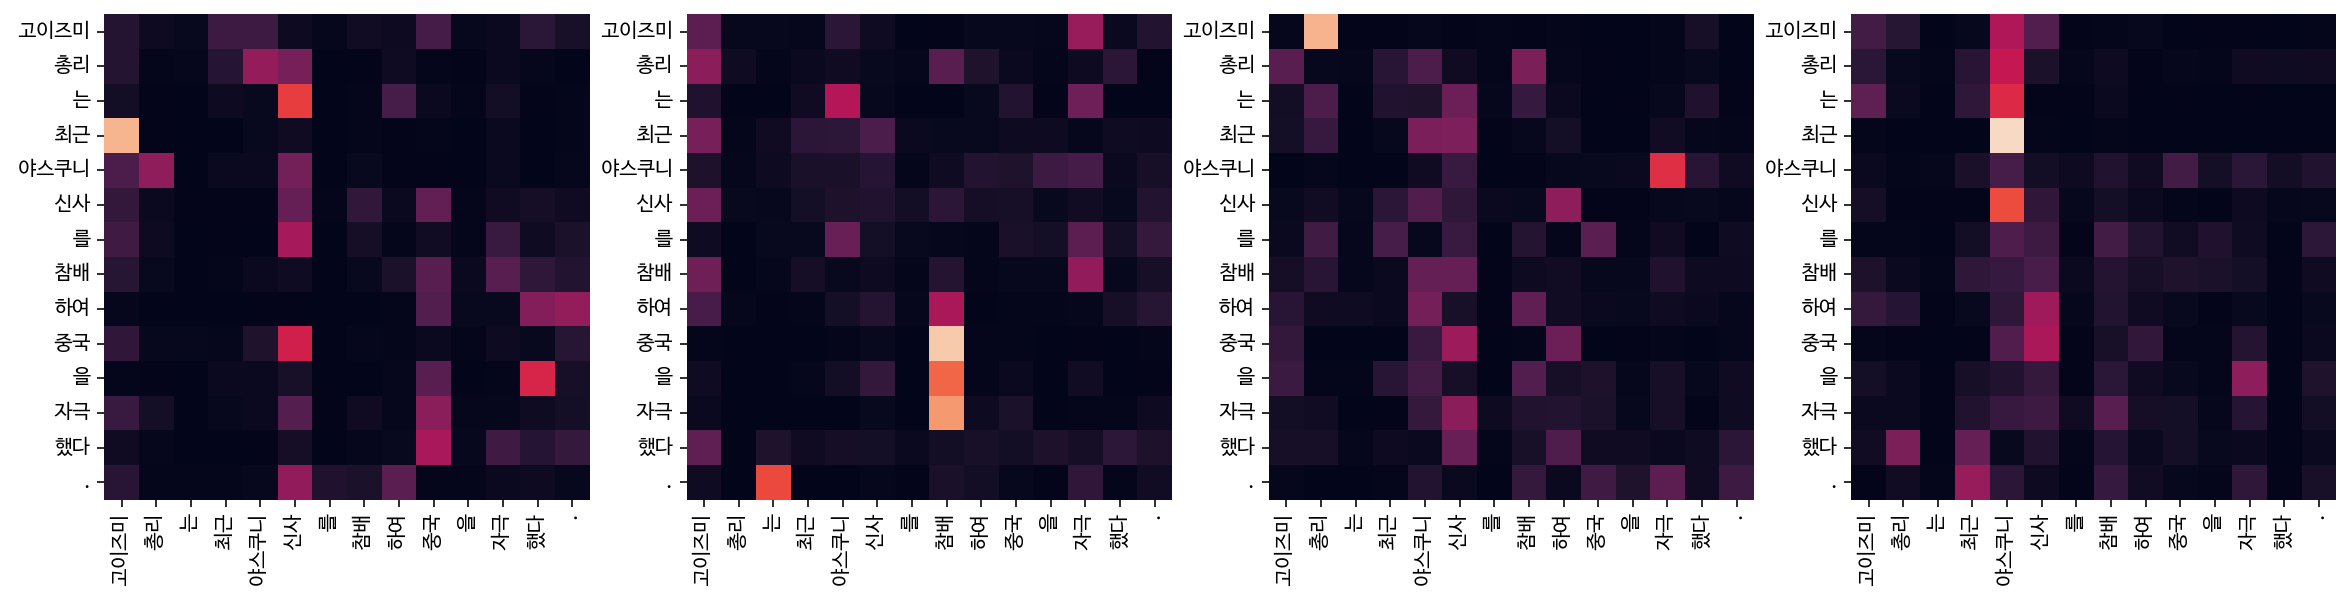

Encoder Layer 2


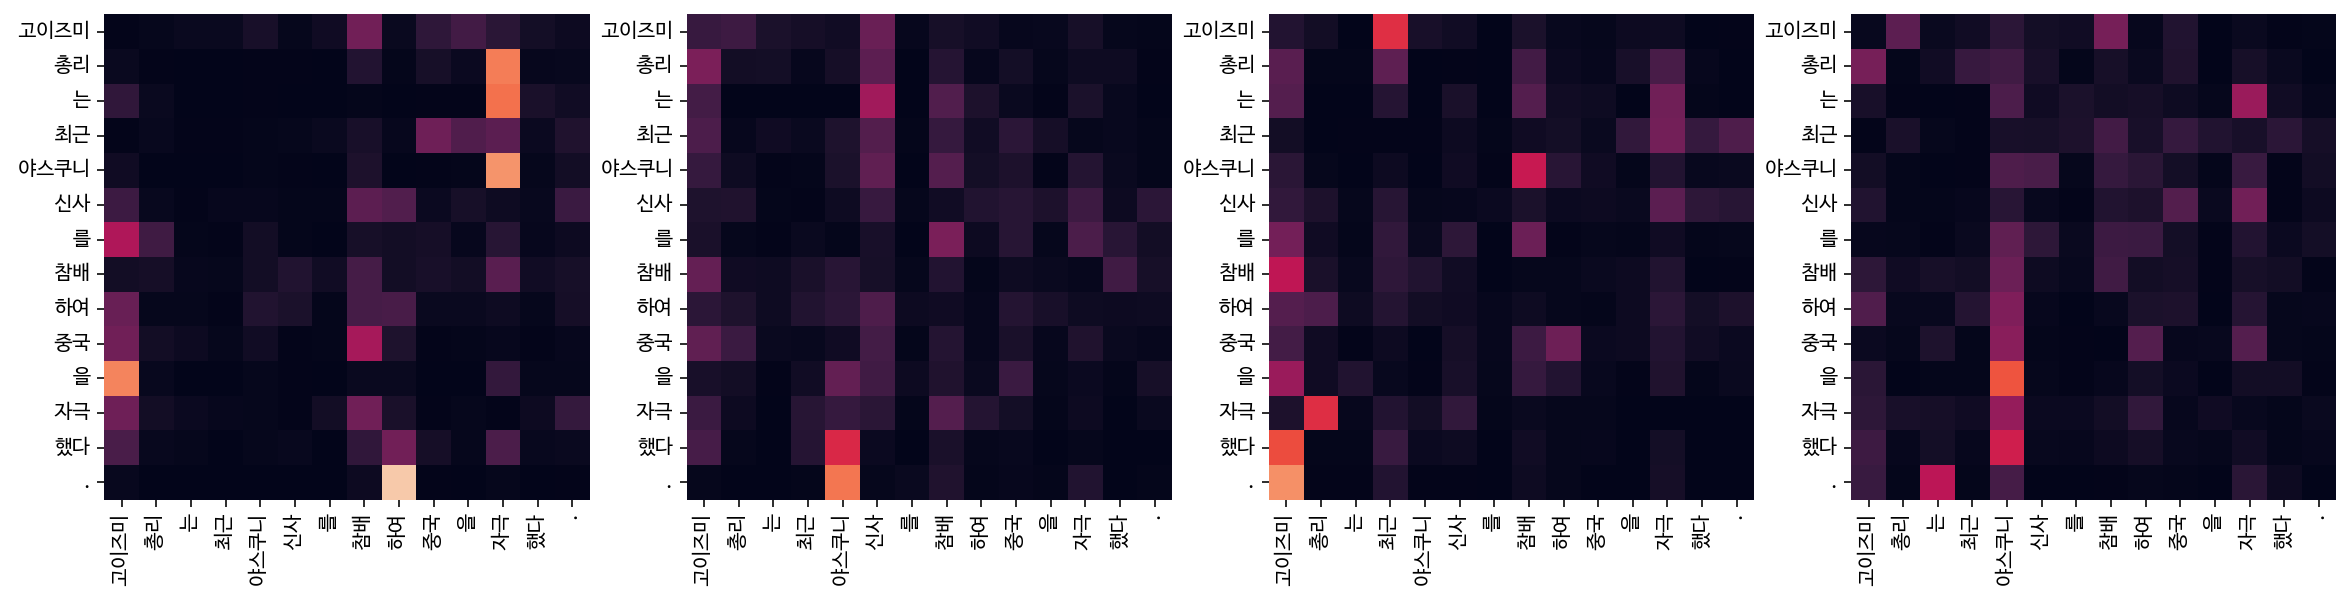

Decoder Self Layer 1


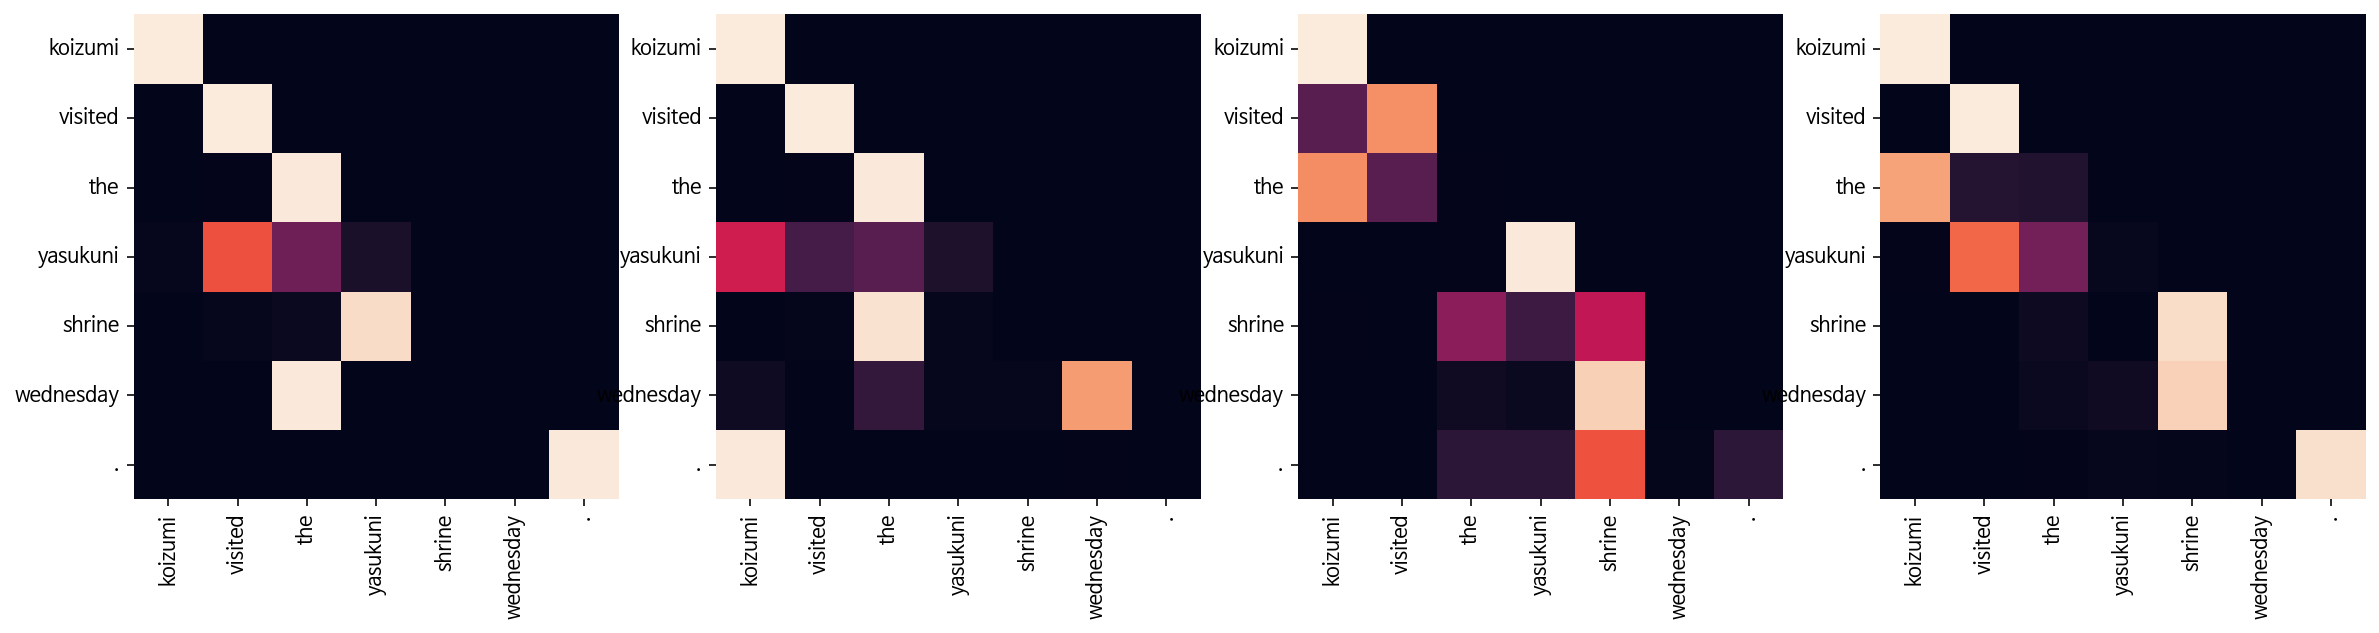

Decoder Src Layer 1


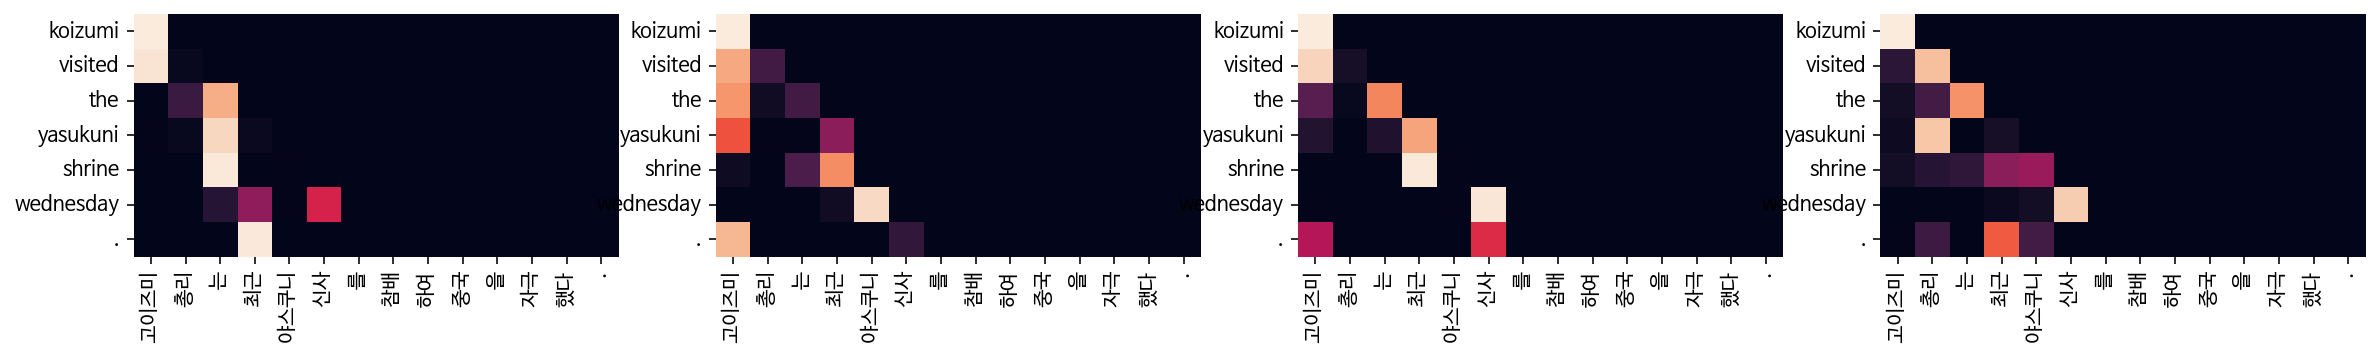

Decoder Self Layer 2


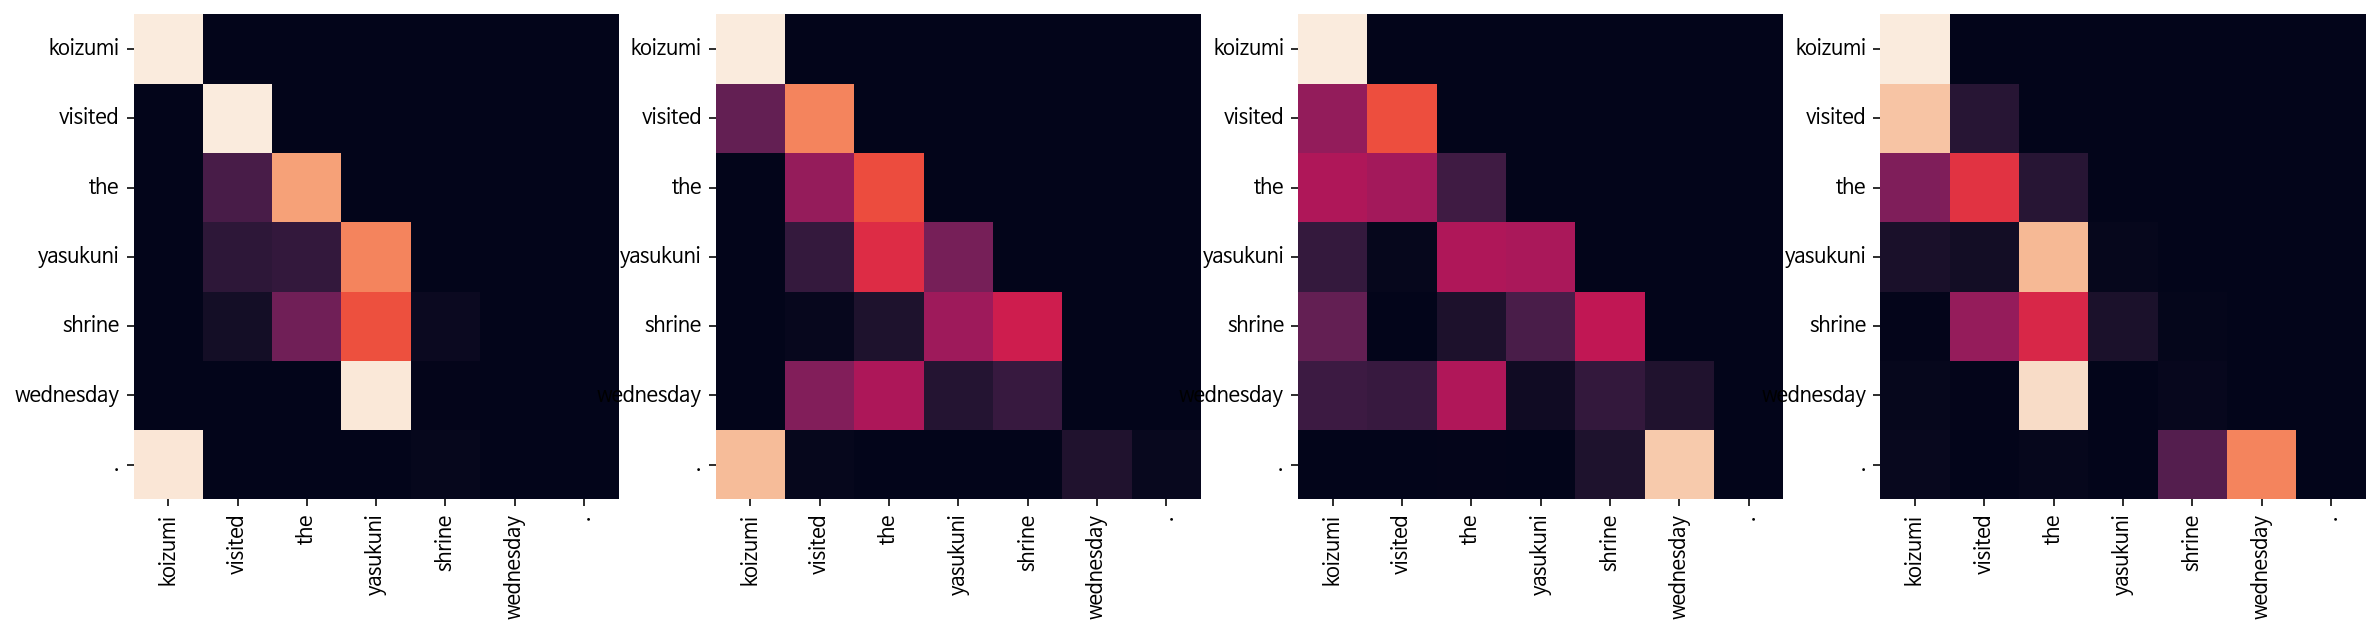

Decoder Src Layer 2


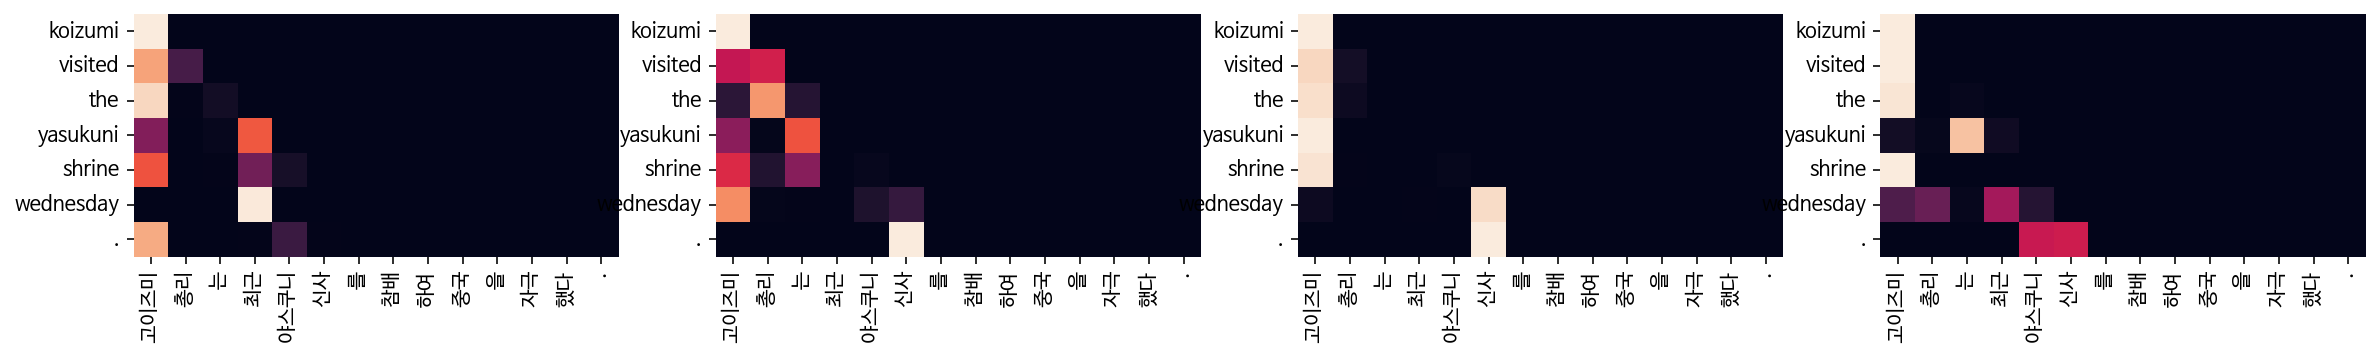

In [46]:
translate(
    "고이즈미 총리는 최근 야스쿠니 신사를 참배하여 중국을 자극했다.",
    transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

────────────────────────────────

▷ Input                ：모든 항생물질들을 비웃고 있는 세균들을 보게 되리라 생각됩니다.

▷ Predicted translation：we are waiting to see bacteria that are literally laughing at all , said to see their bacteria .

Encoder Layer 1


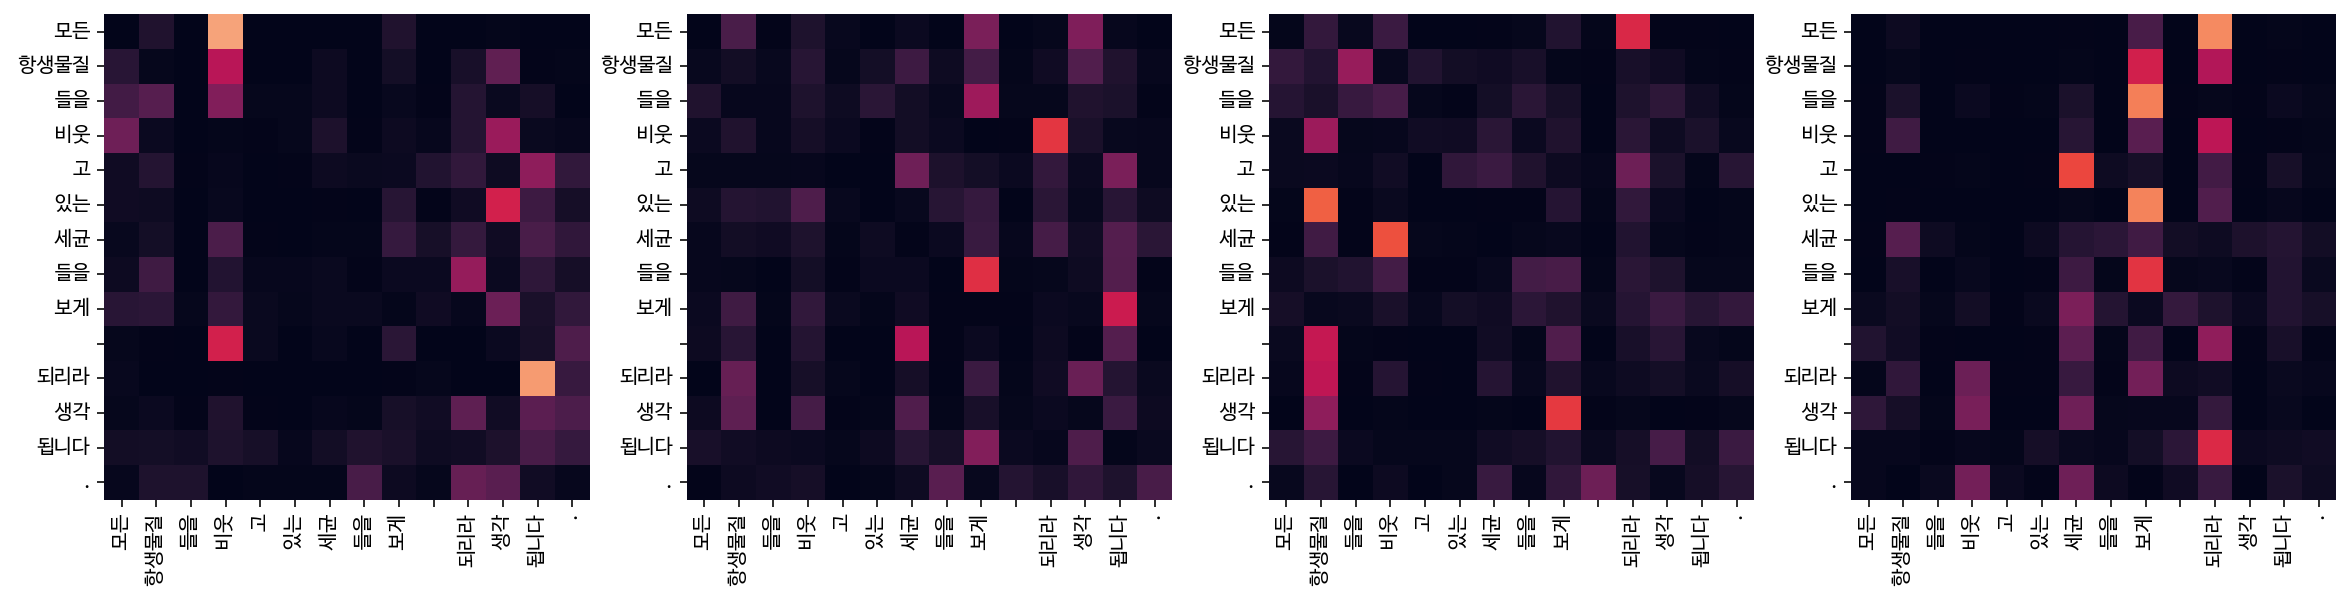

Encoder Layer 2


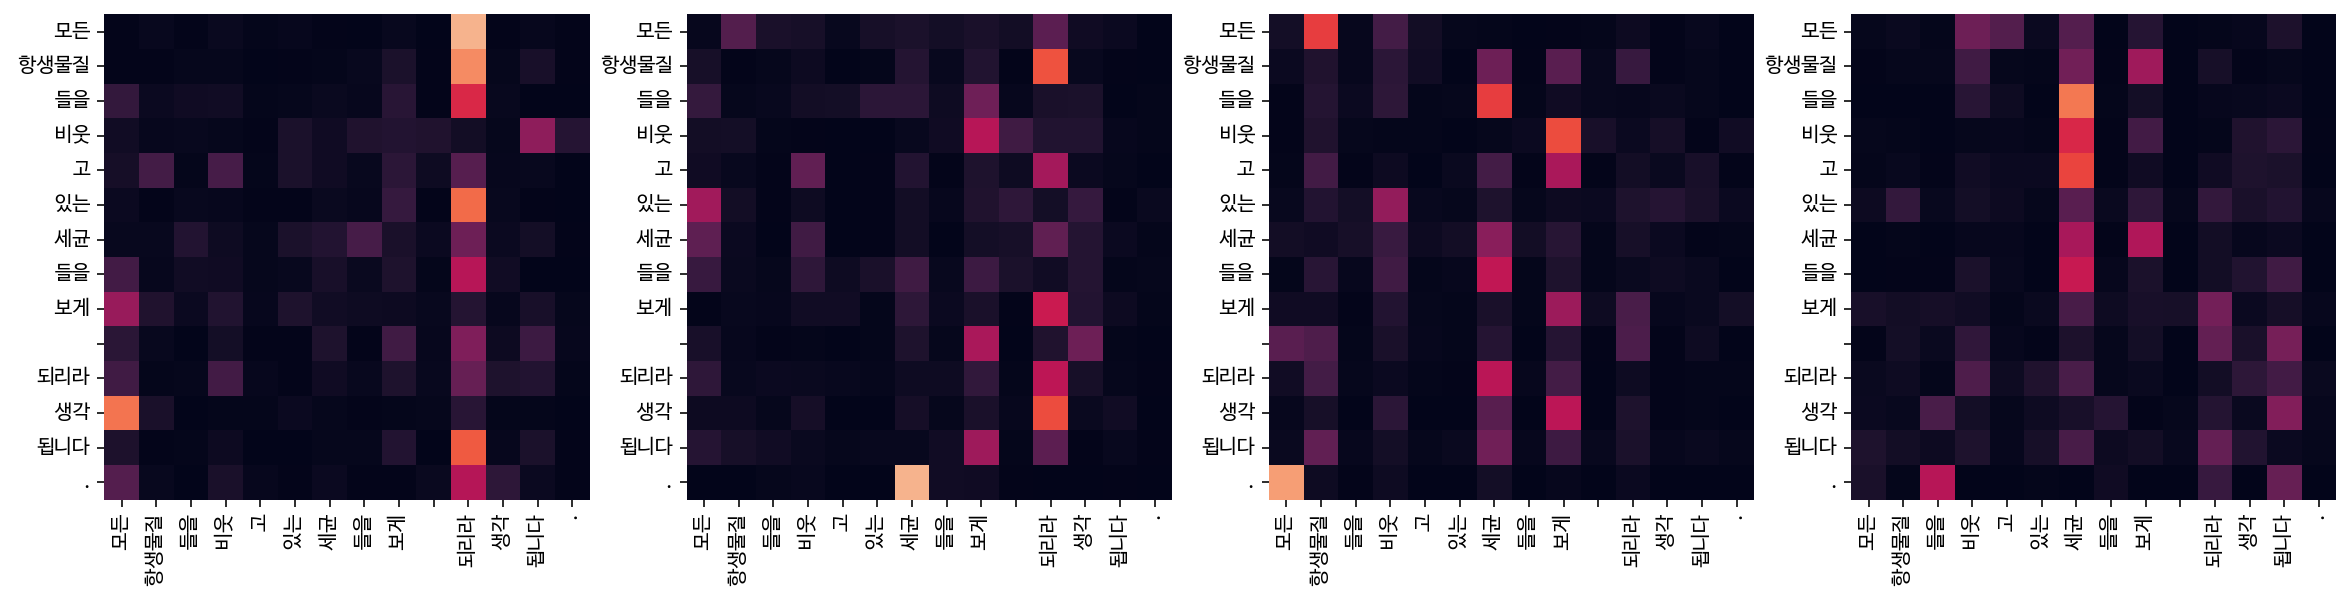

Decoder Self Layer 1


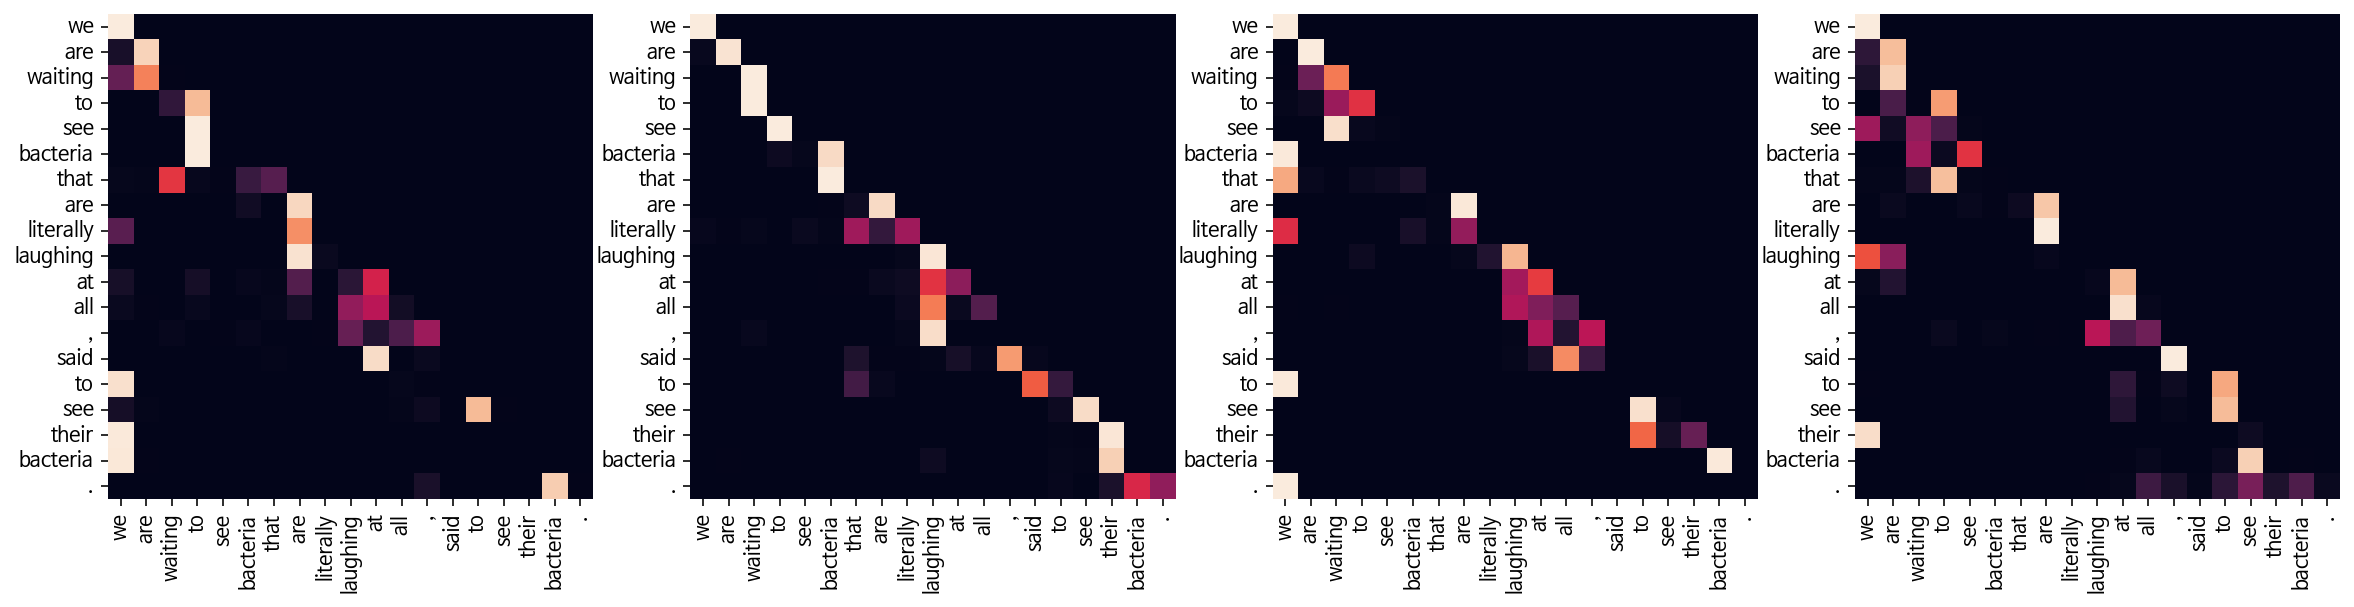

Decoder Src Layer 1


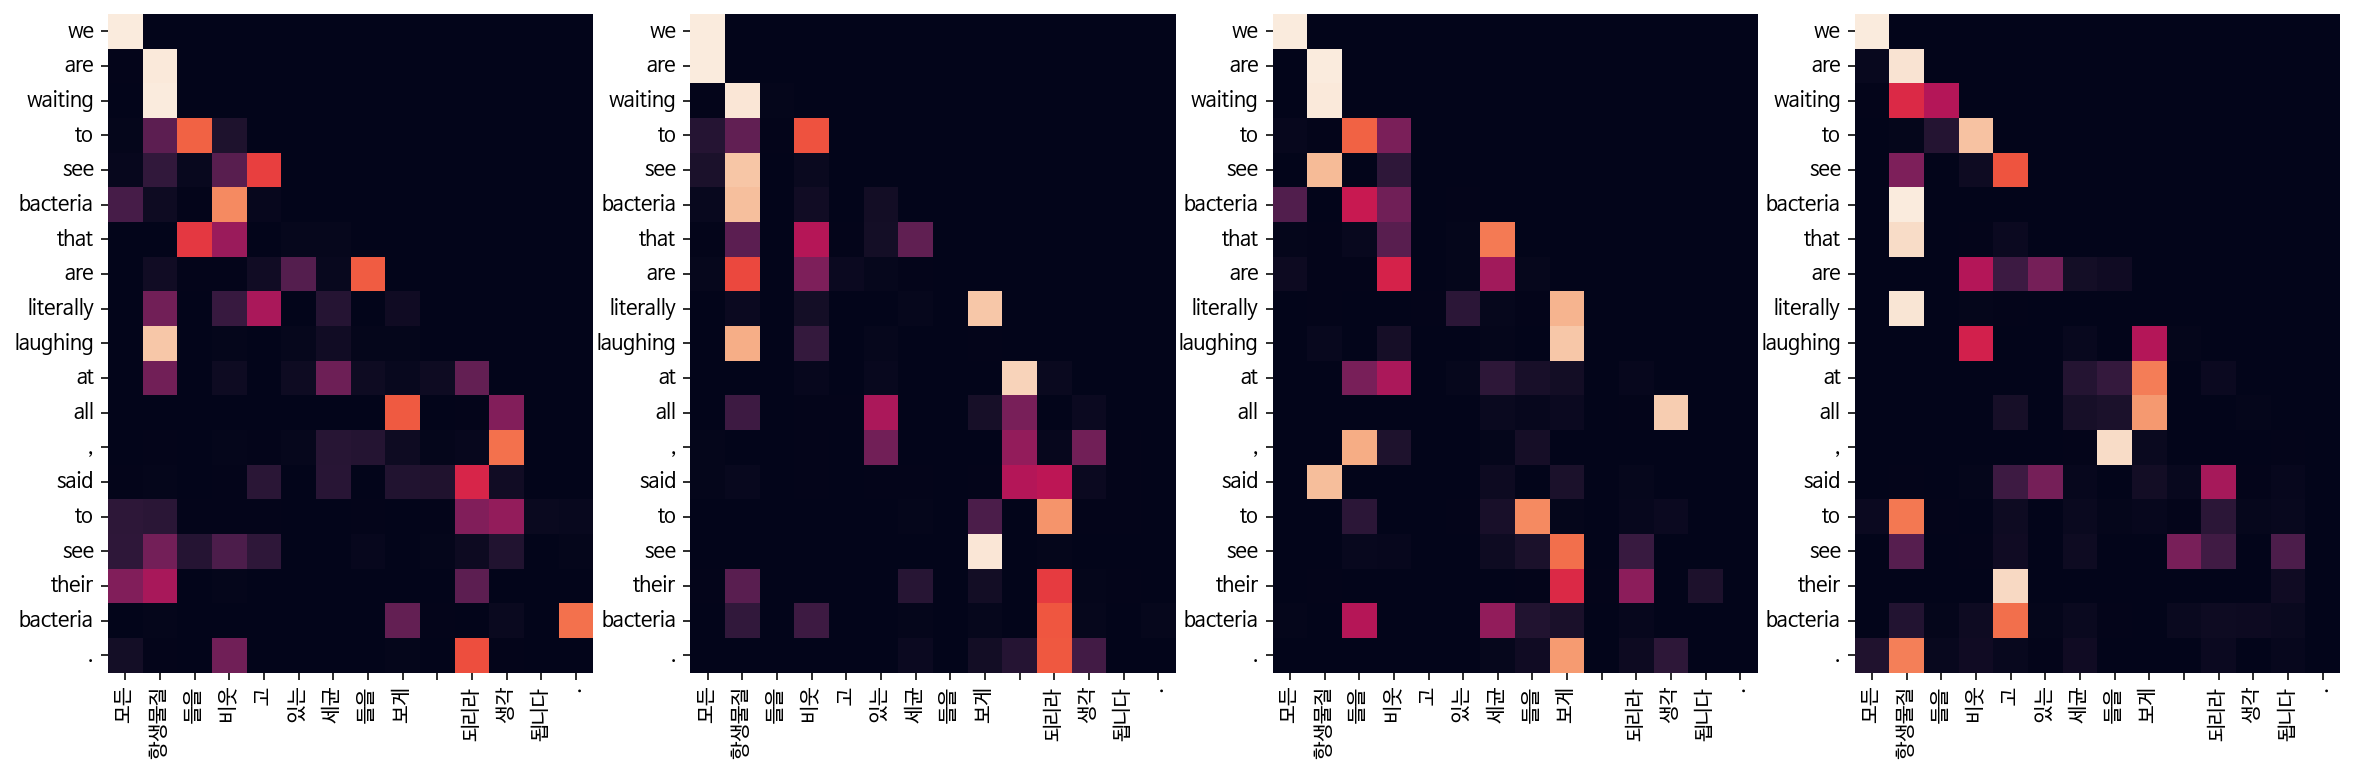

Decoder Self Layer 2


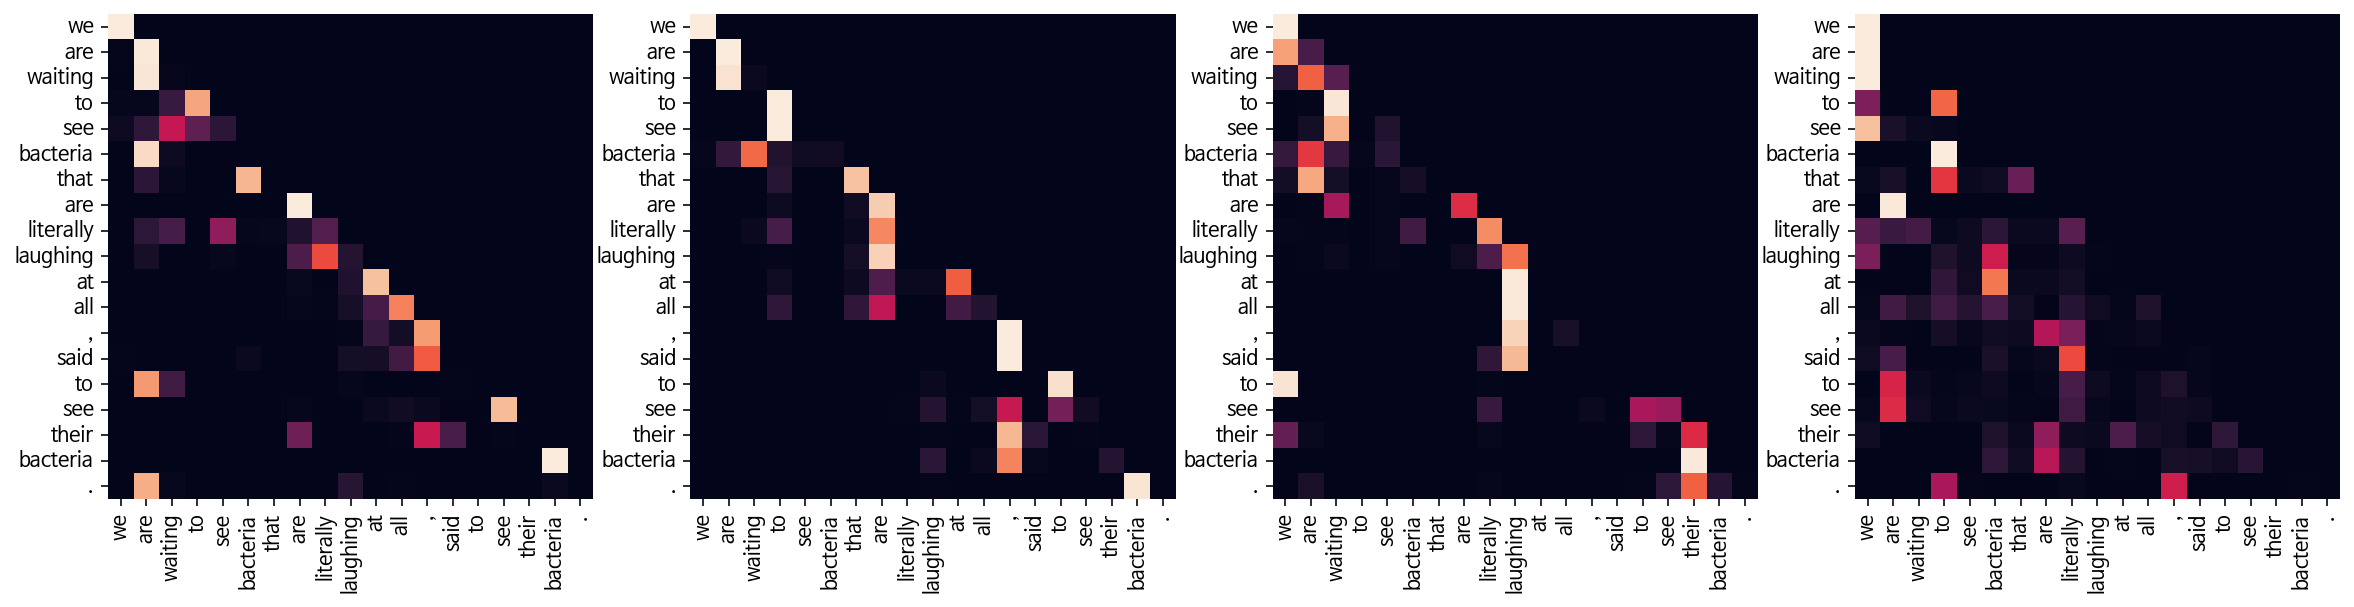

Decoder Src Layer 2


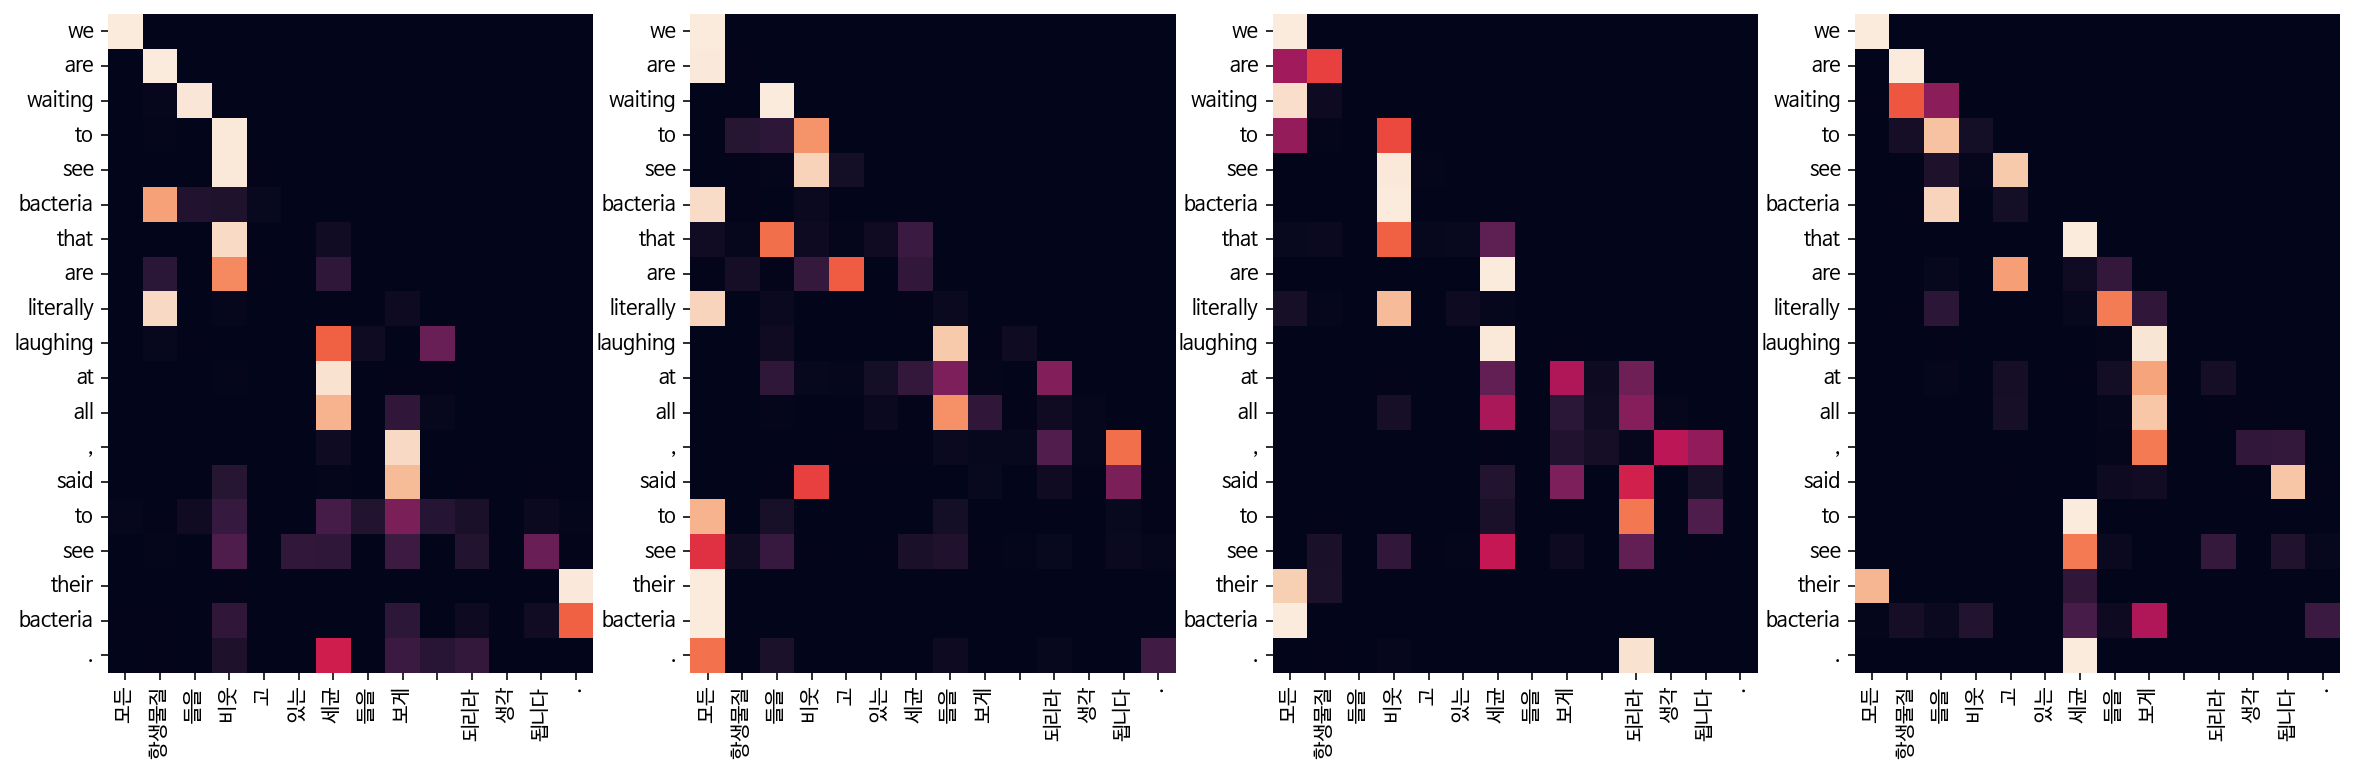

In [47]:
translate(
    "모든 항생물질들을 비웃고 있는 세균들을 보게 되리라 생각됩니다.",
    transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

────────────────────────────────

▷ Input                ：어느 은행도 구체적인 답변을 주지 않았습니다.

▷ Predicted translation：none banks were banks aides appeared to be provided .

Encoder Layer 1


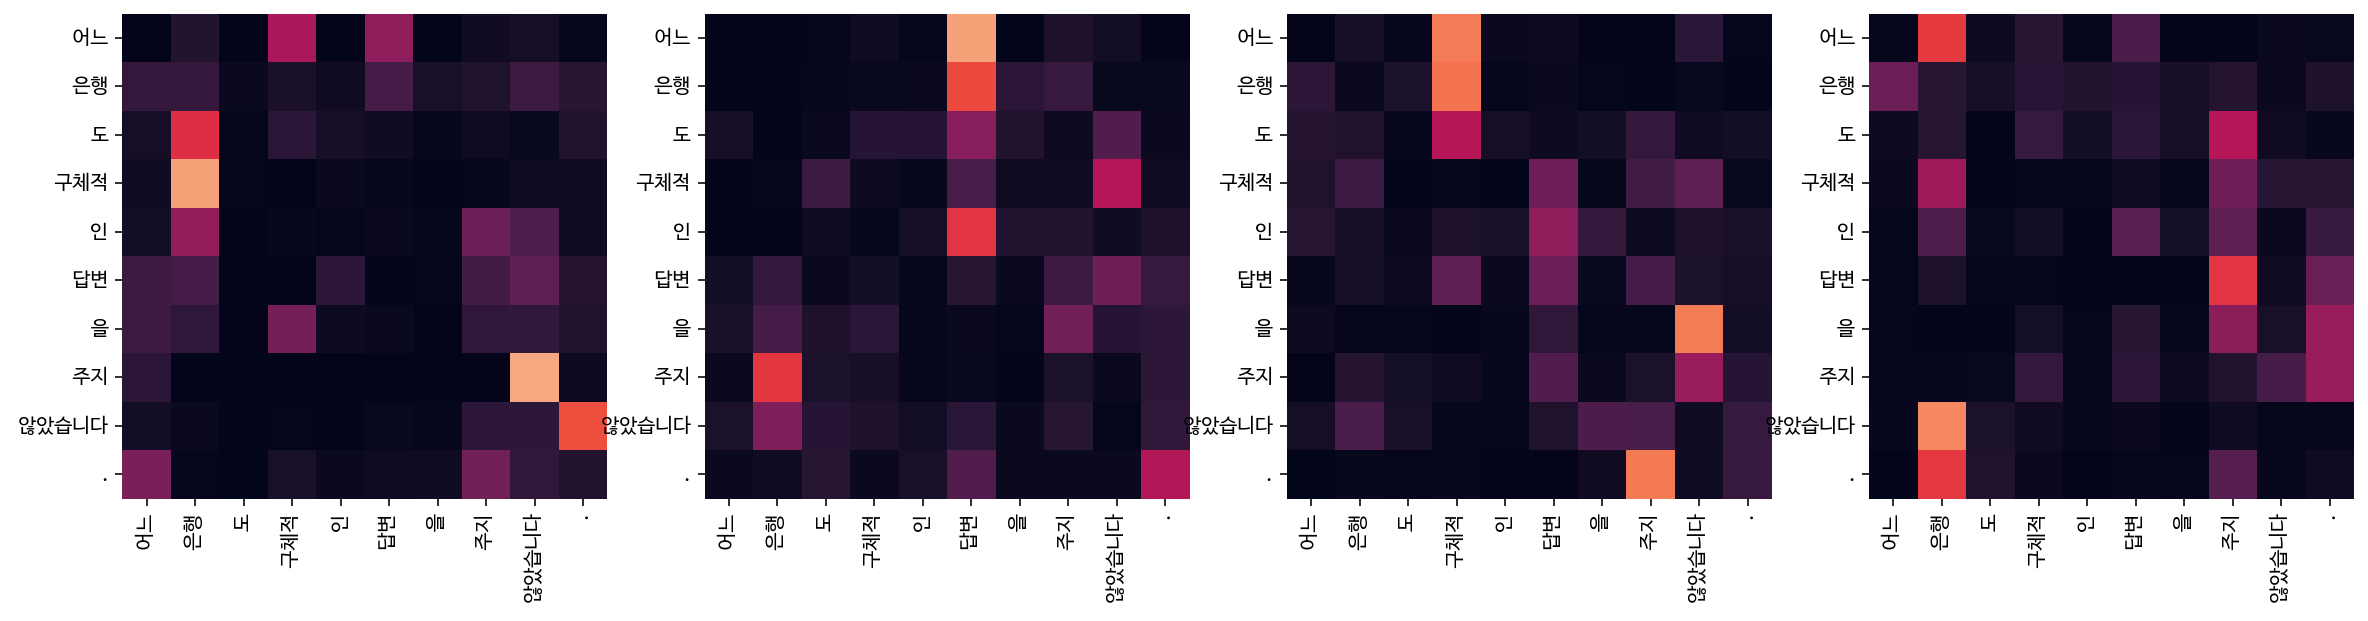

Encoder Layer 2


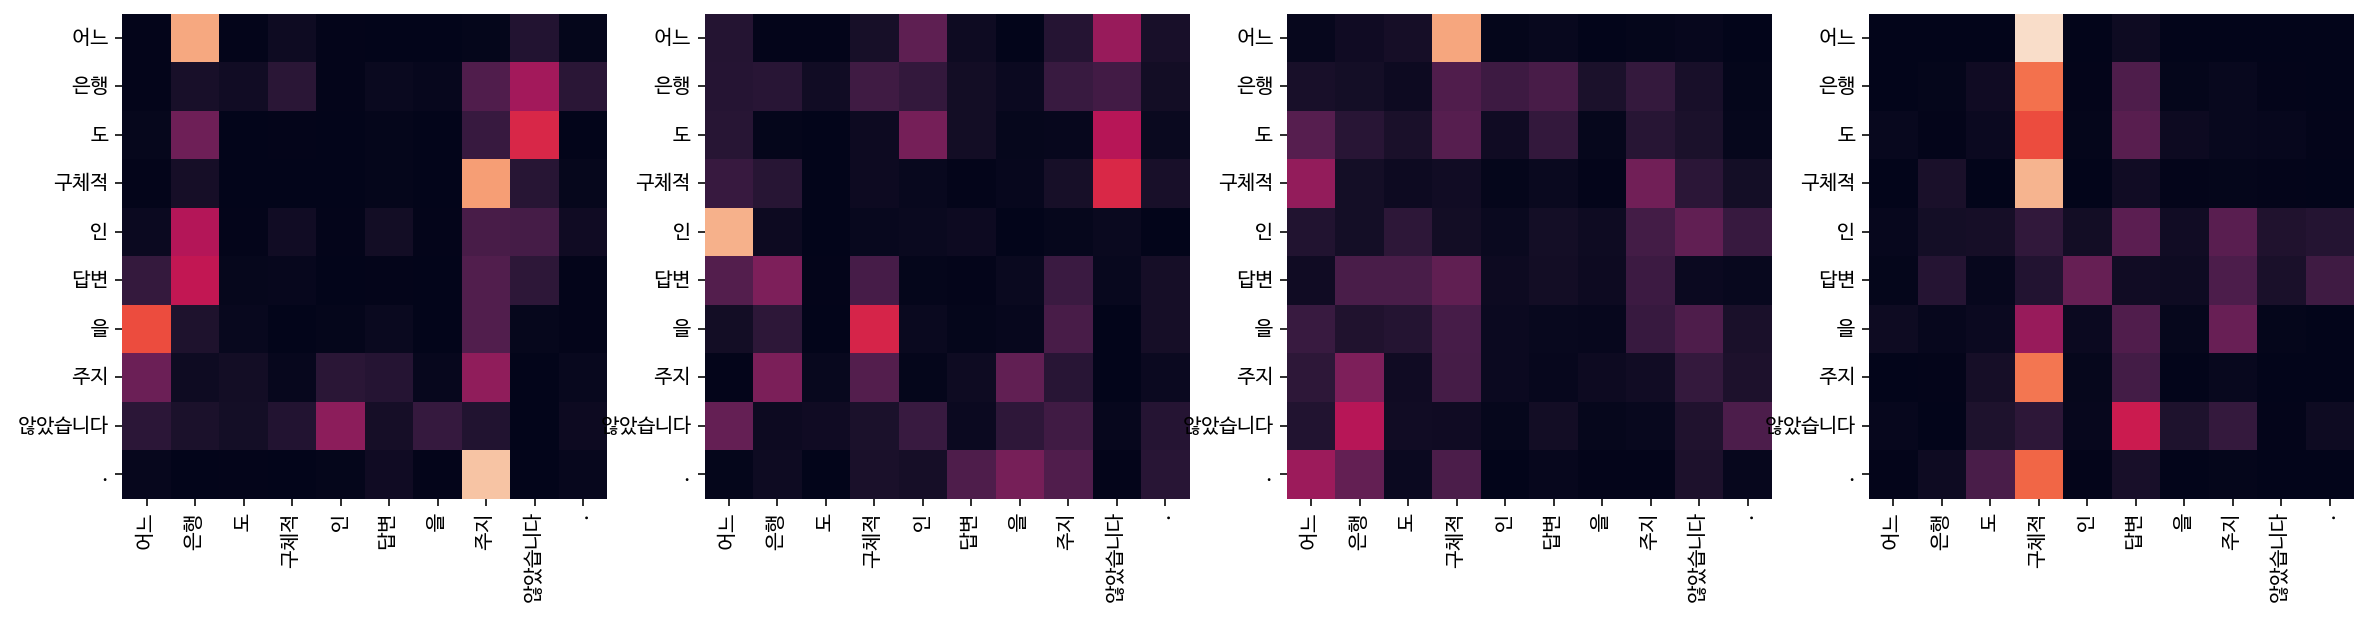

Decoder Self Layer 1


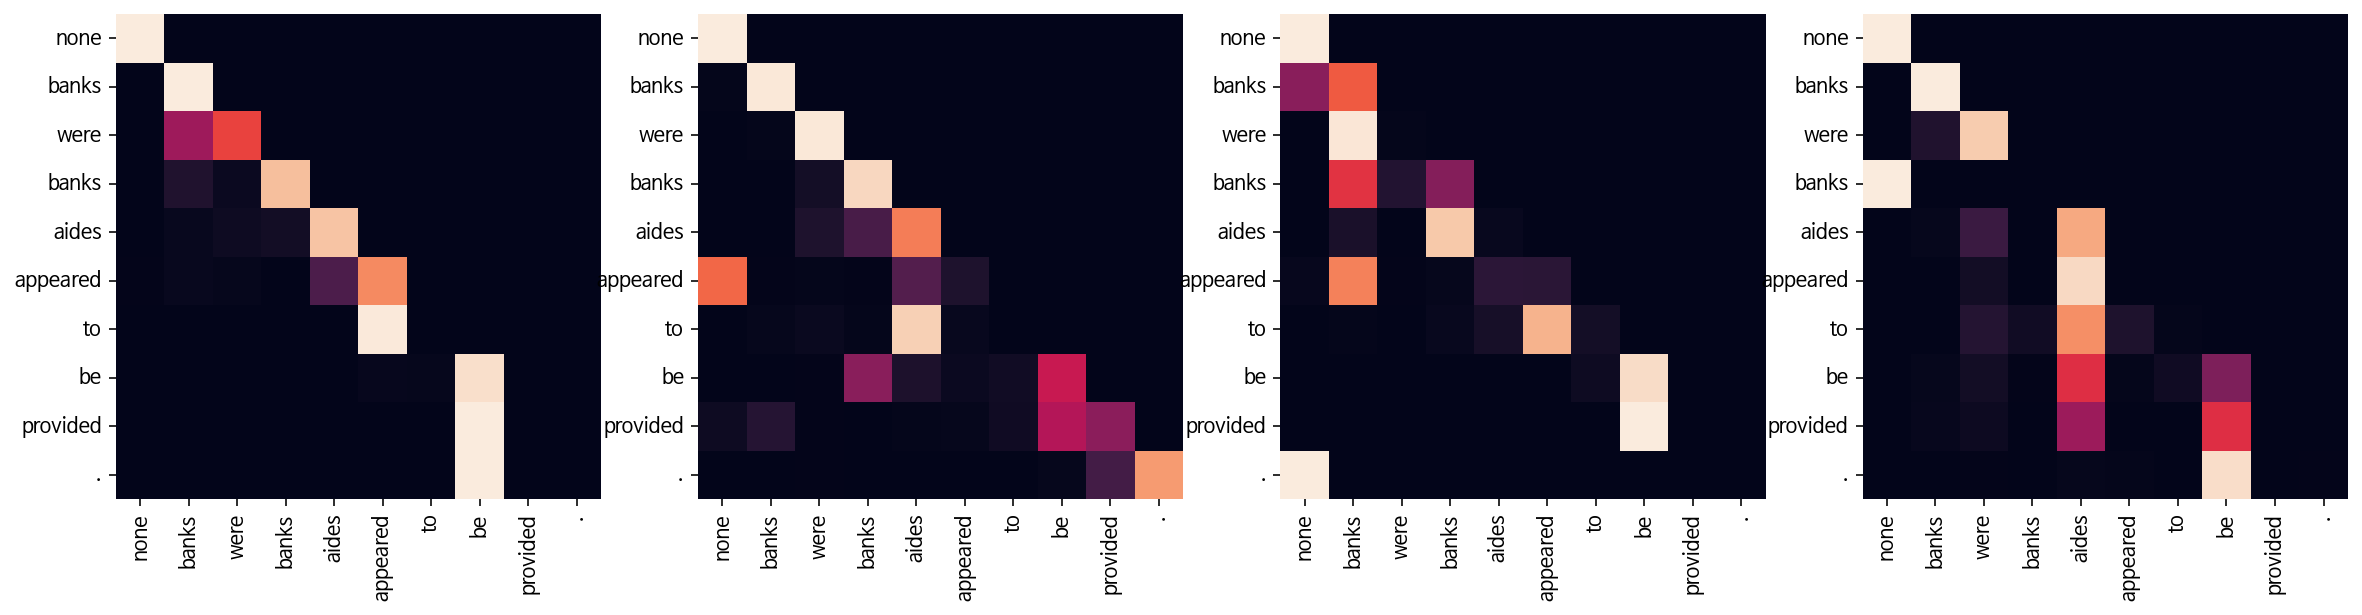

Decoder Src Layer 1


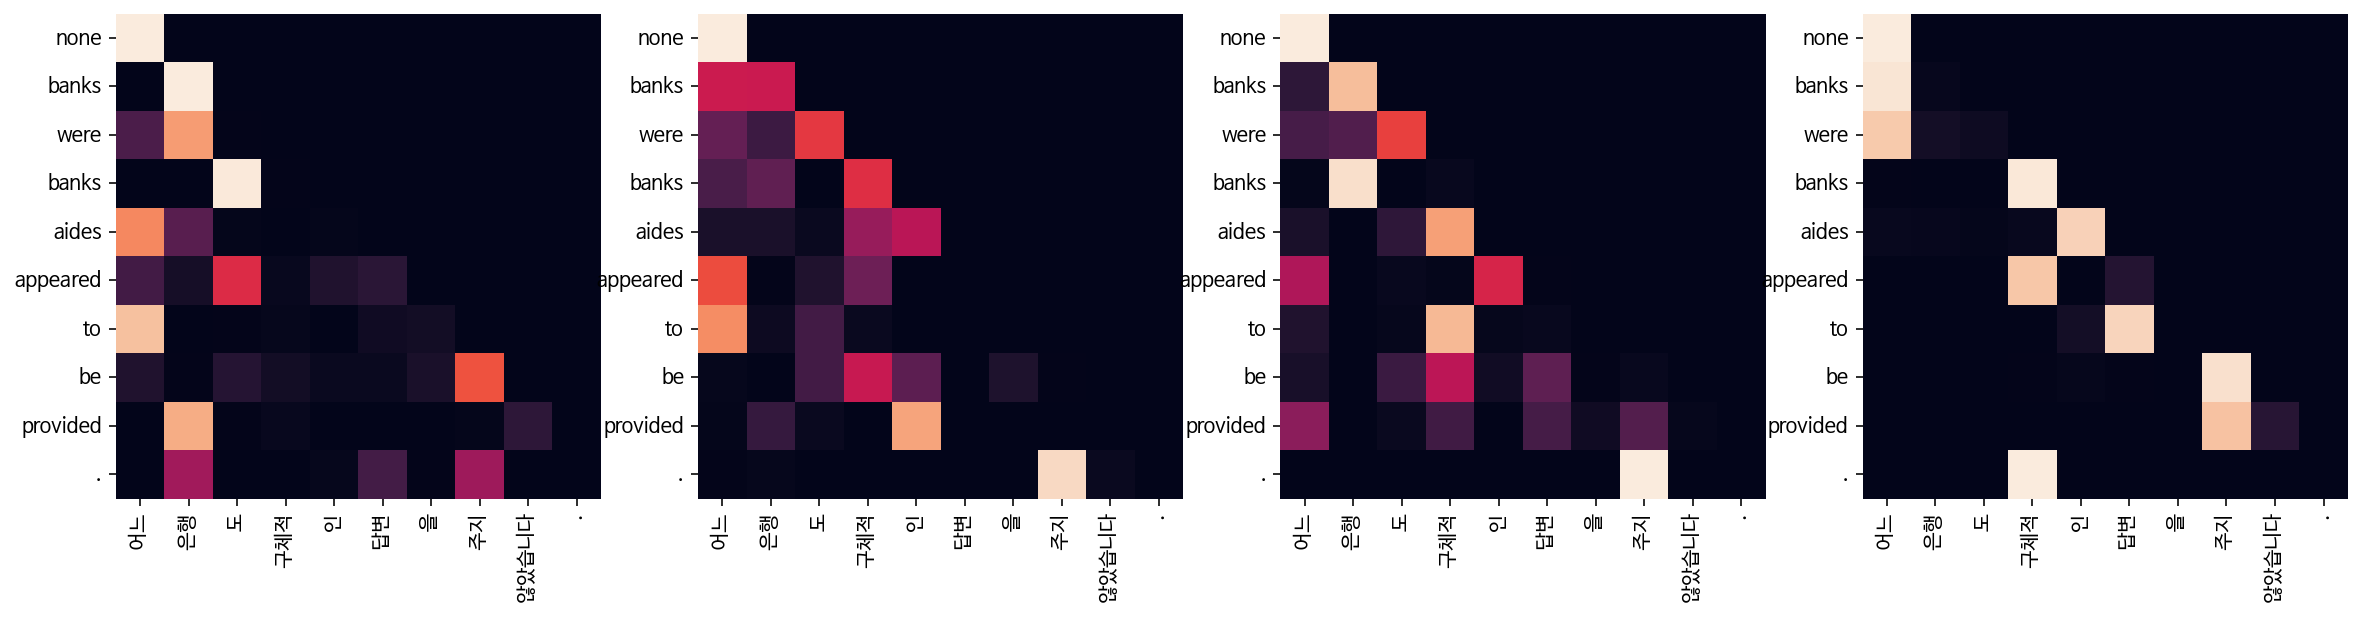

Decoder Self Layer 2


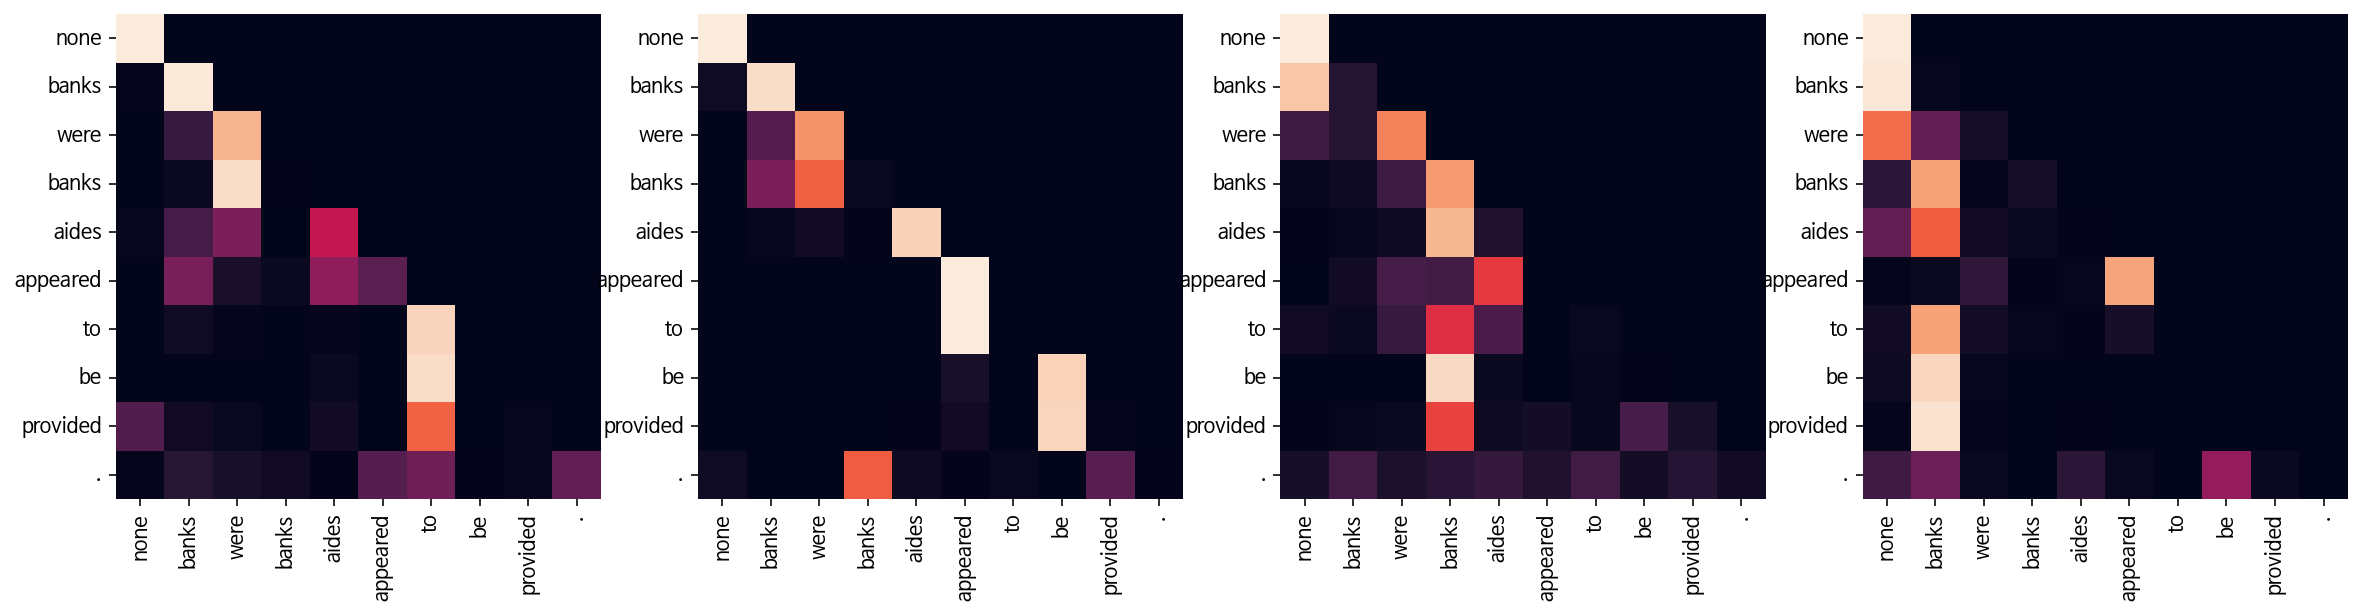

Decoder Src Layer 2


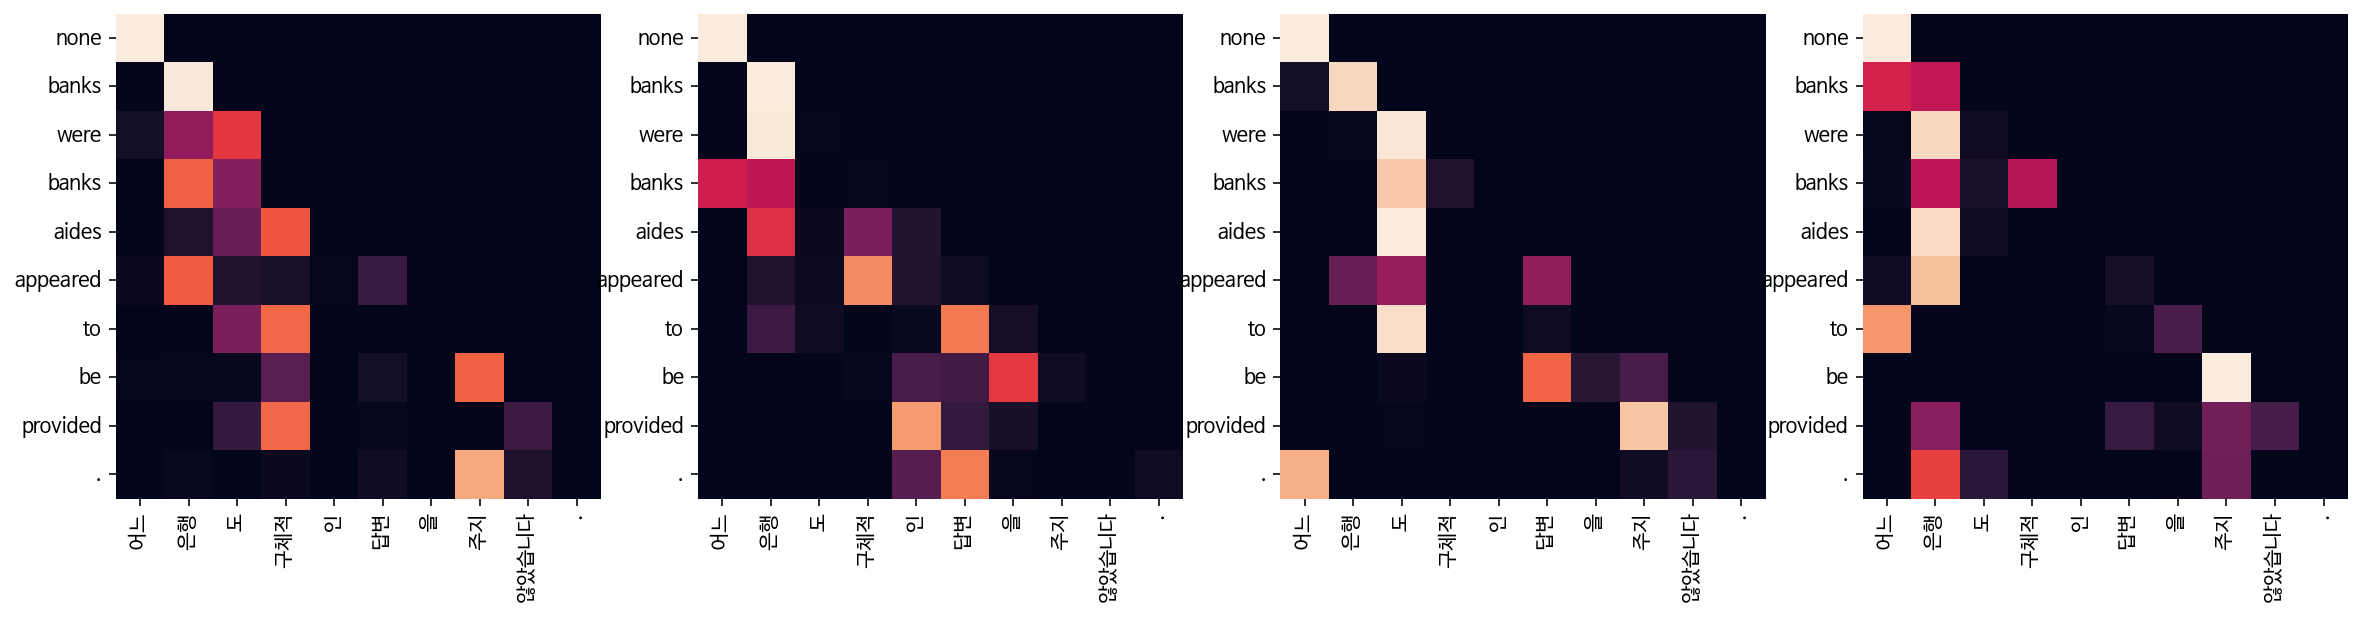

In [48]:
translate(
    "어느 은행도 구체적인 답변을 주지 않았습니다.",
    transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

────────────────────────────────

▷ Input                ：아시아는 무서운 속도로 산업과 경제를 발전시키고 있다.

▷ Predicted translation：asia has seen an urged global slower than eu billion contract contracts .

Encoder Layer 1


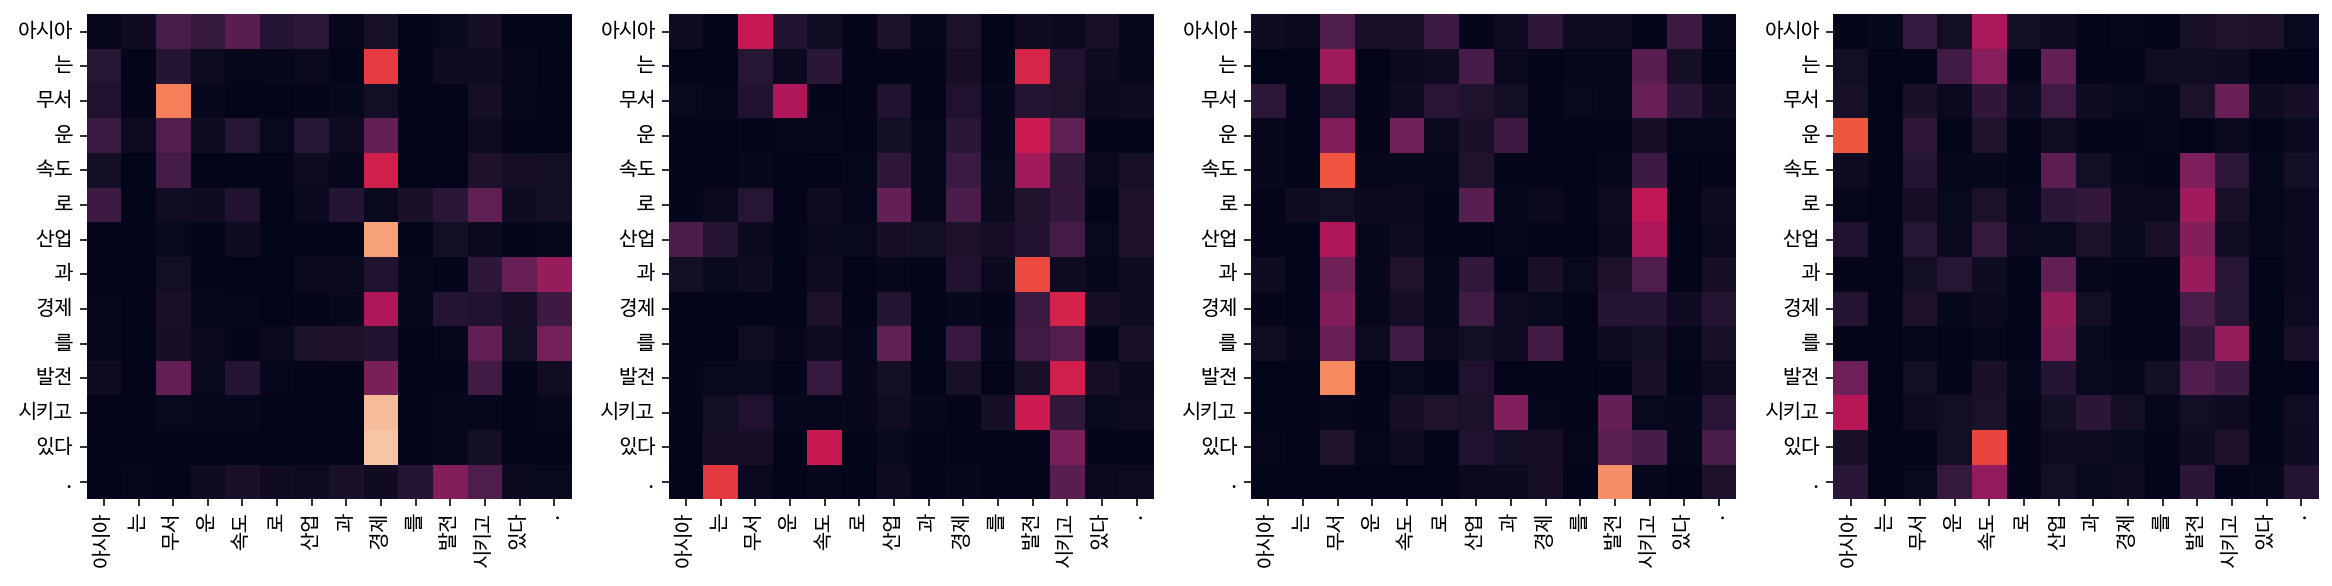

Encoder Layer 2


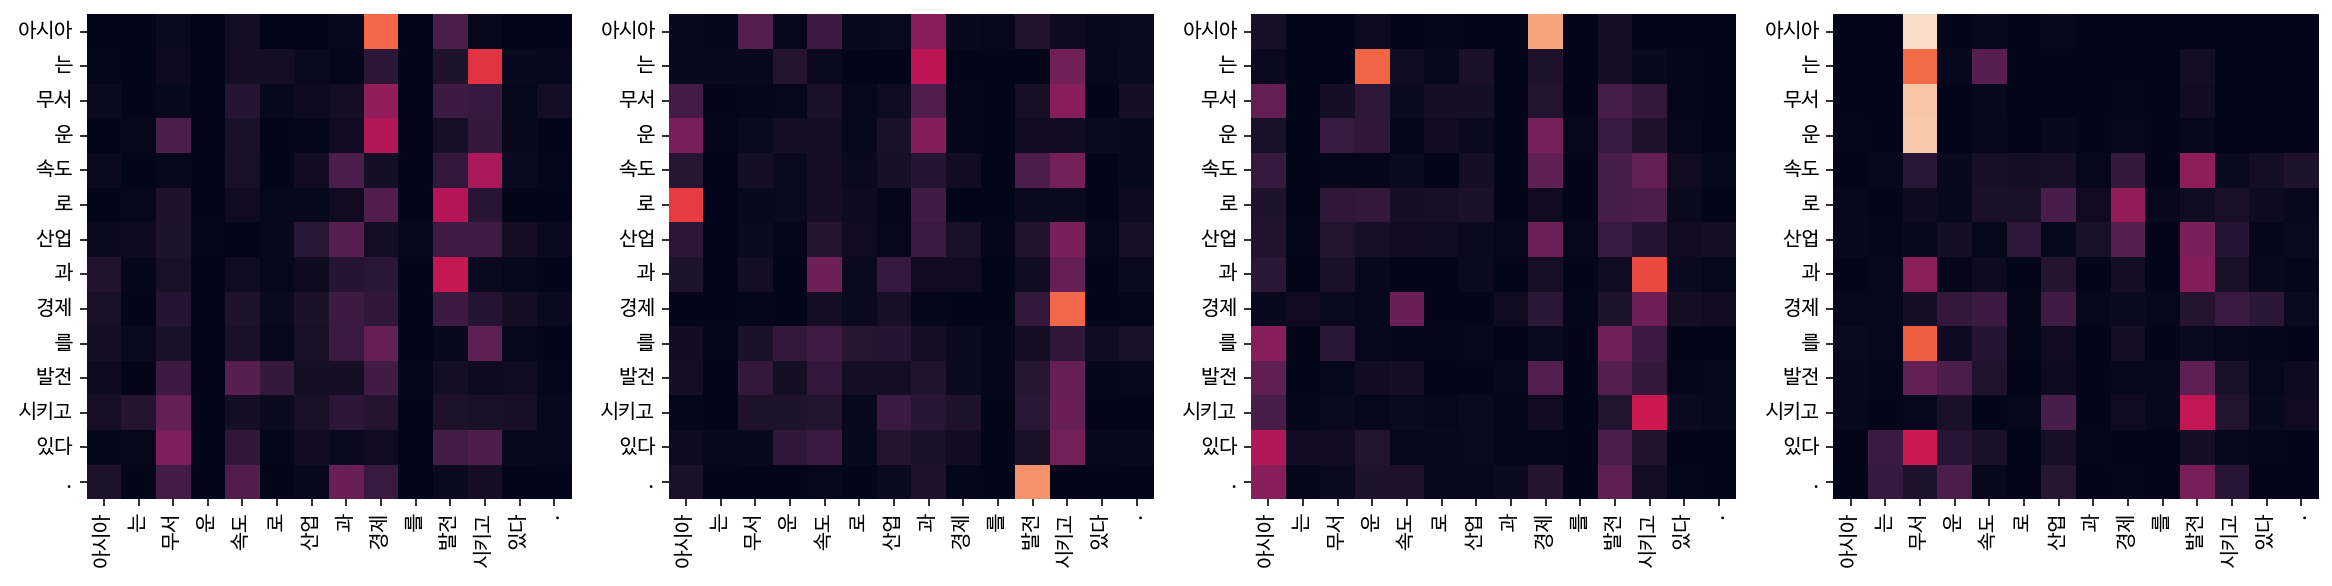

Decoder Self Layer 1


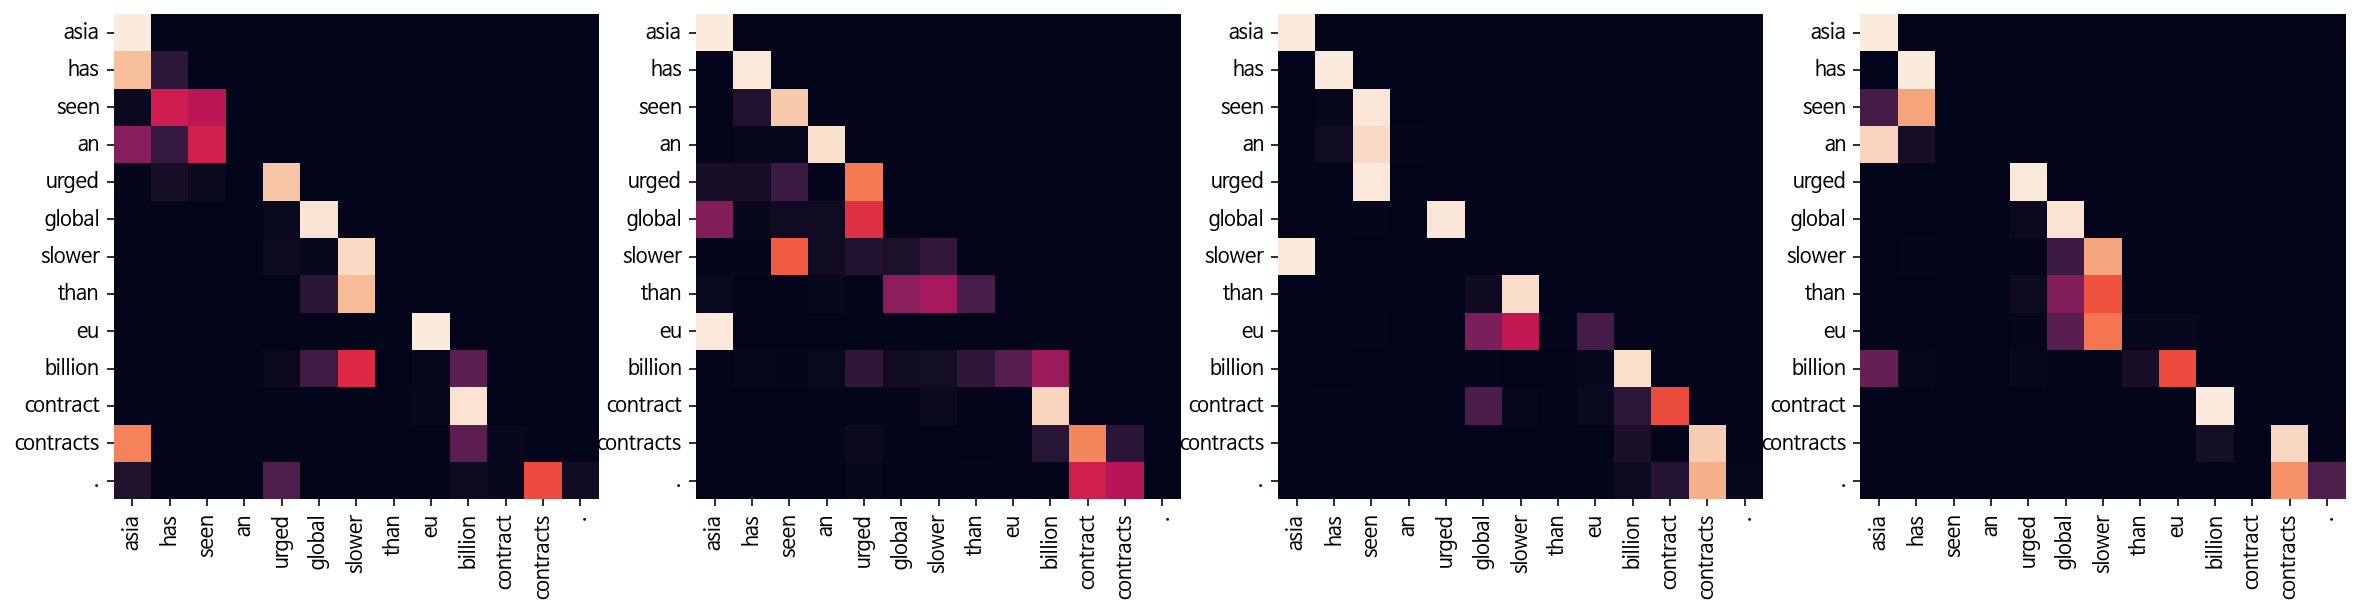

Decoder Src Layer 1


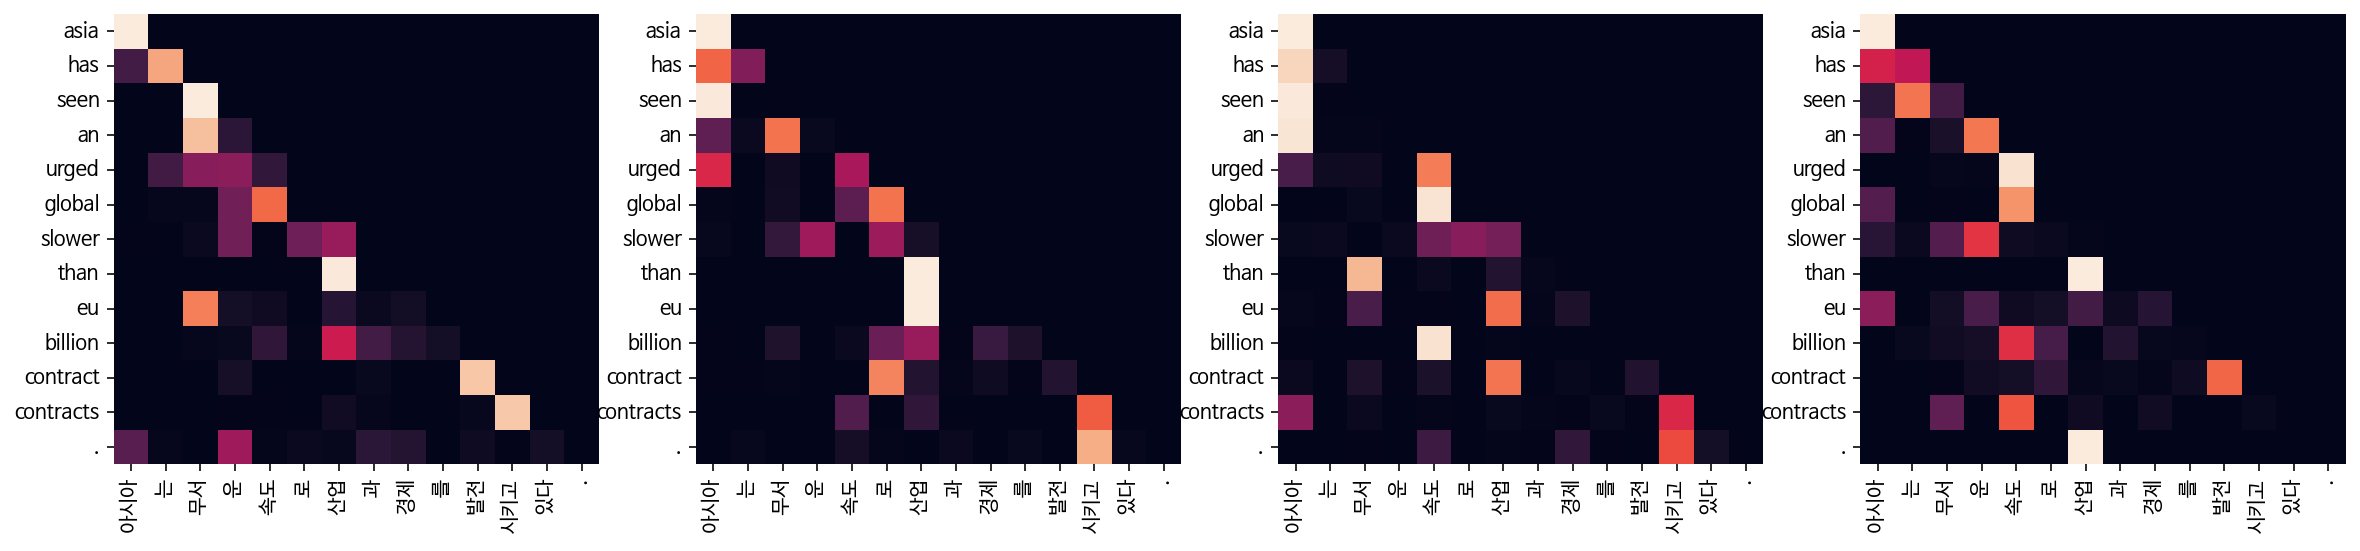

Decoder Self Layer 2


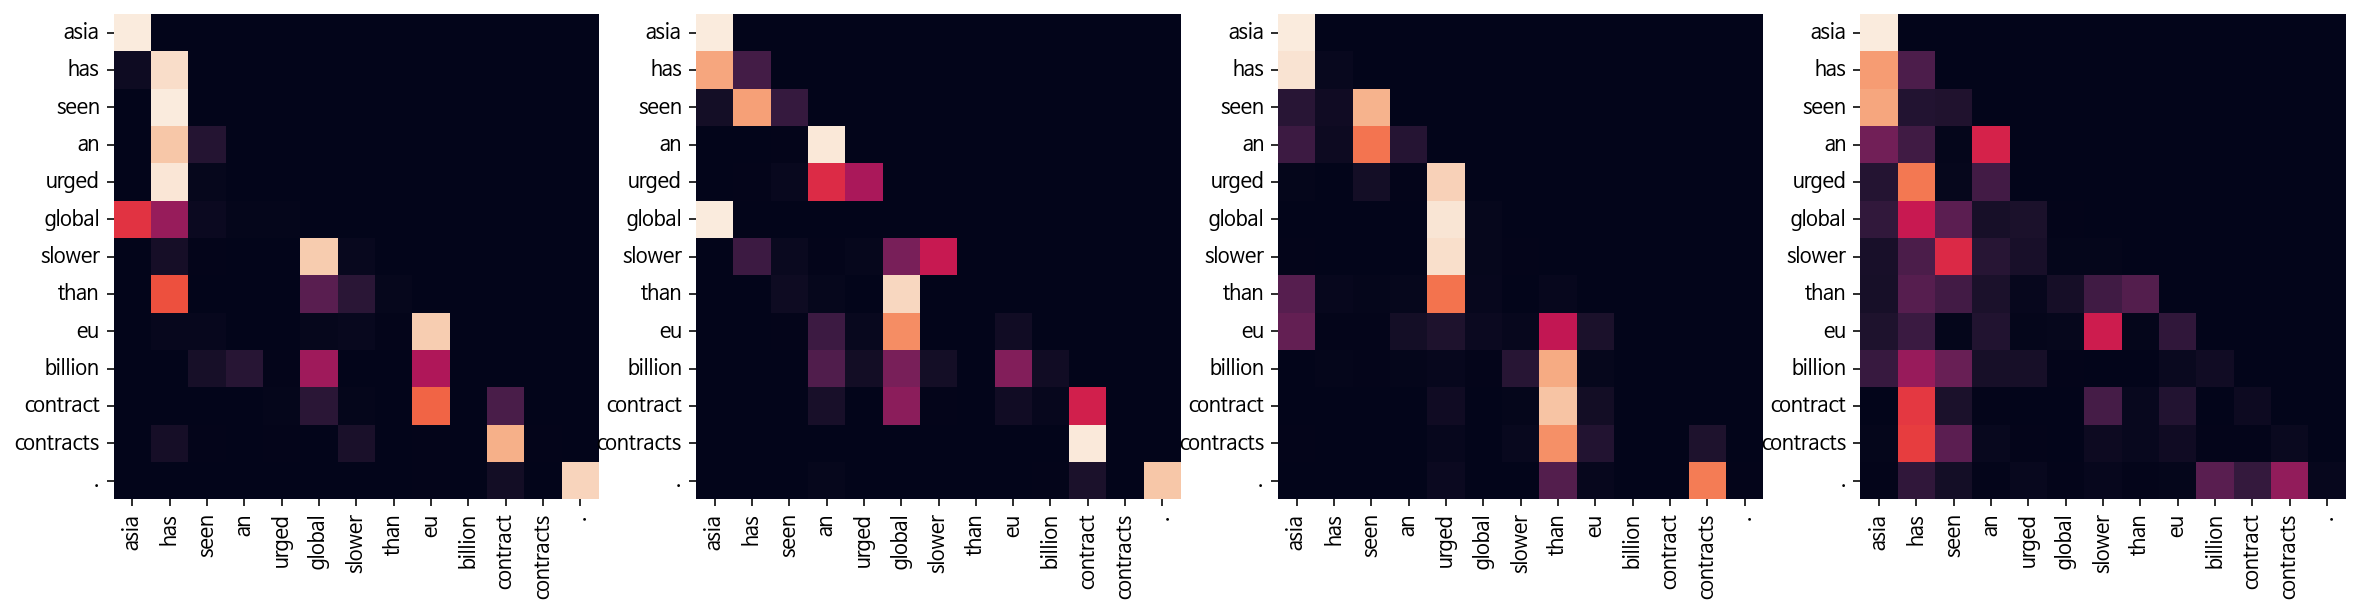

Decoder Src Layer 2


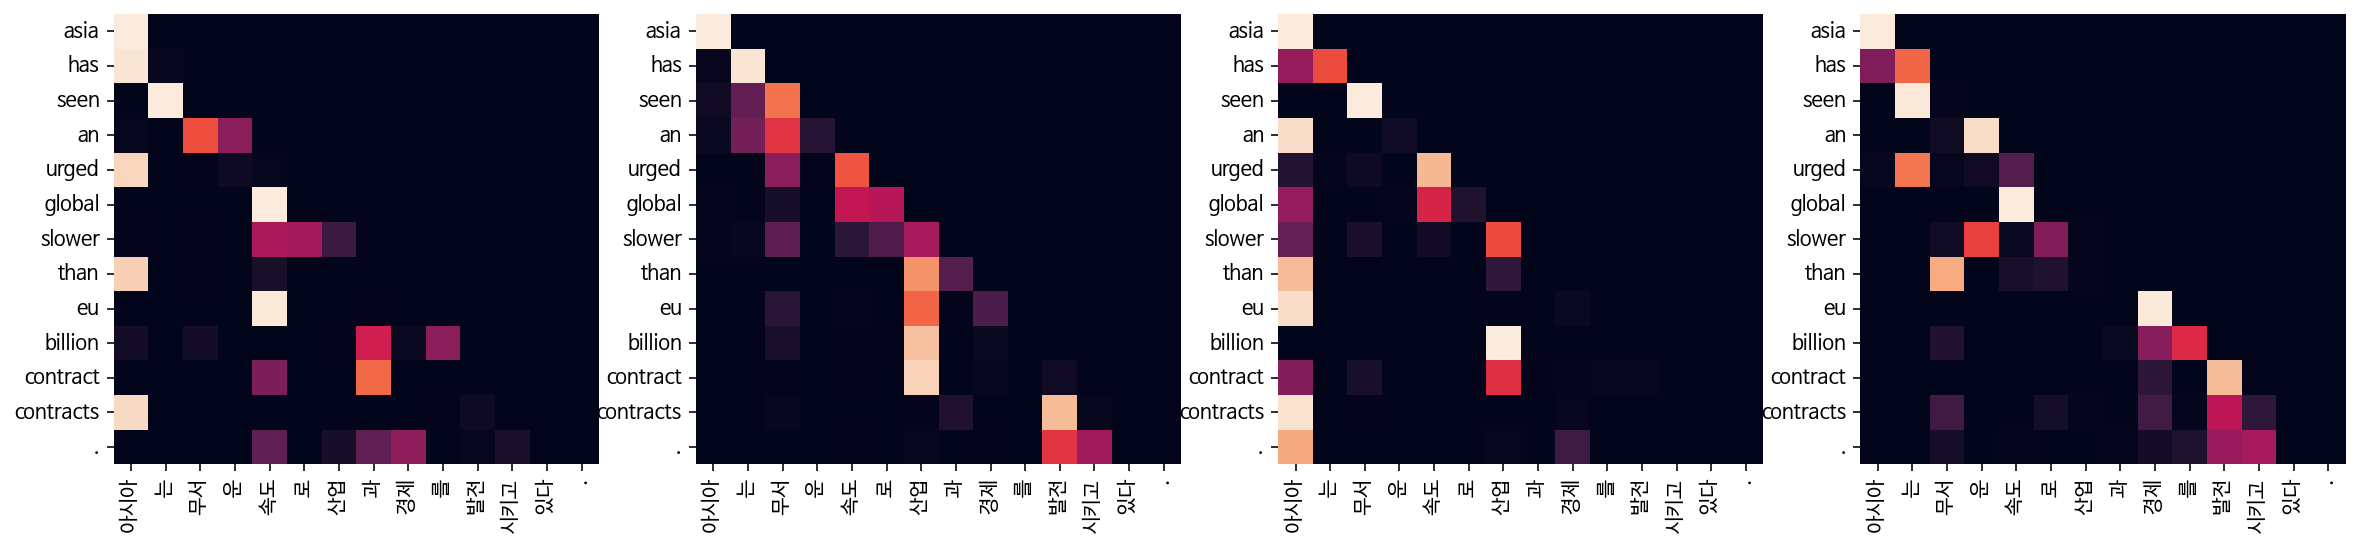

In [49]:
translate(
    "아시아는 무서운 속도로 산업과 경제를 발전시키고 있다.",
    transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

────────────────────────────────

▷ Input                ：일본인들은 항복할 조짐을 보이지 않고 있었다.

▷ Predicted translation：the japanese were showing no signs of surrender .

Encoder Layer 1


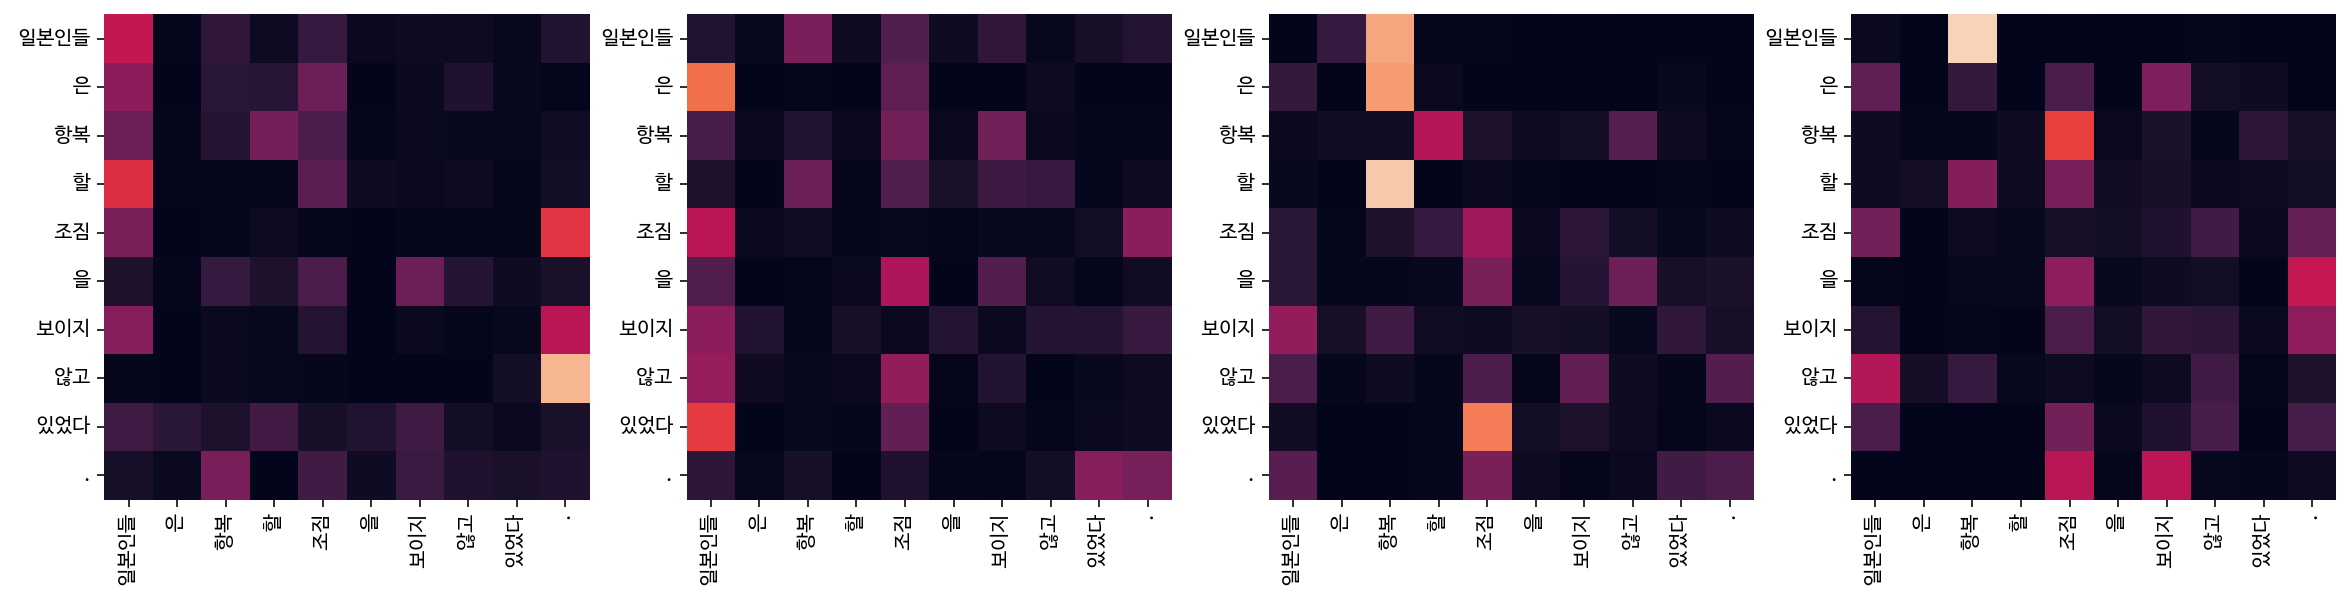

Encoder Layer 2


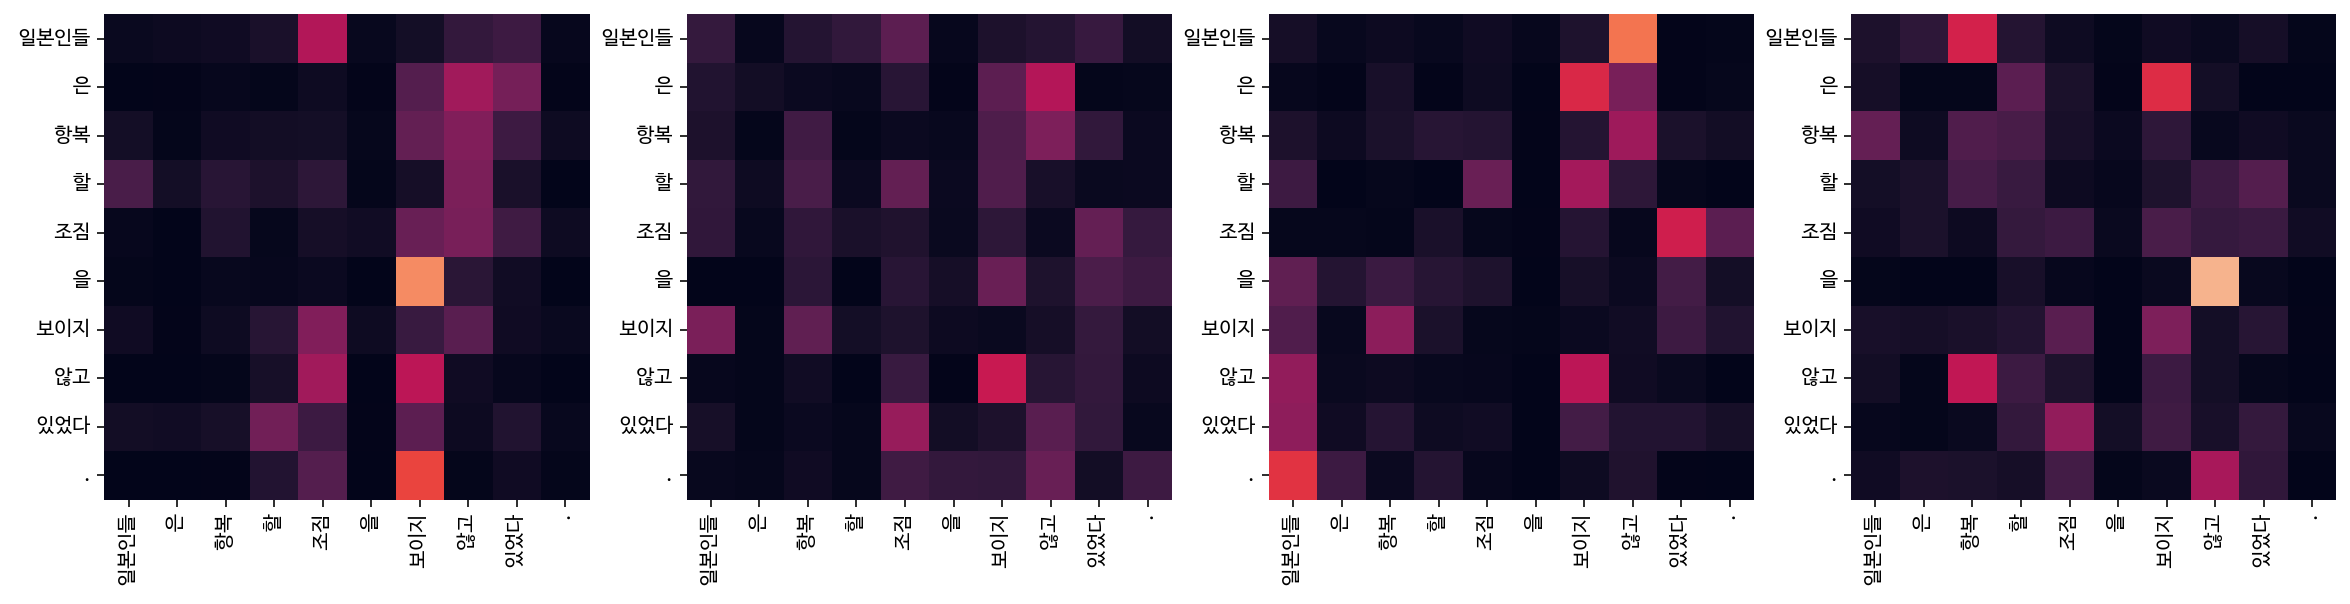

Decoder Self Layer 1


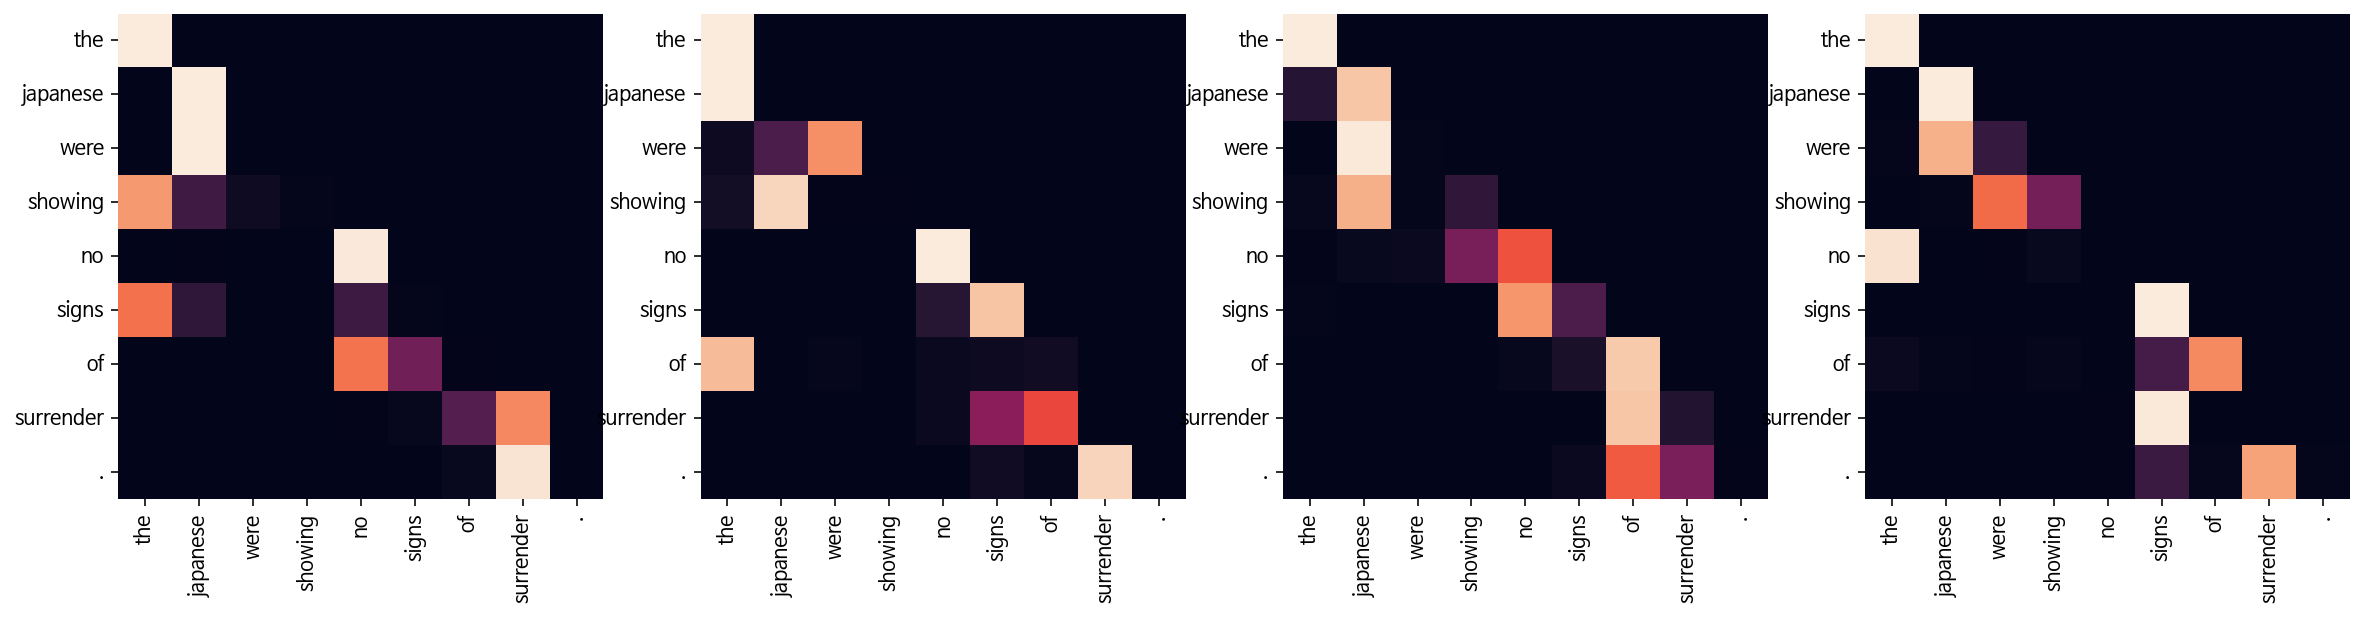

Decoder Src Layer 1


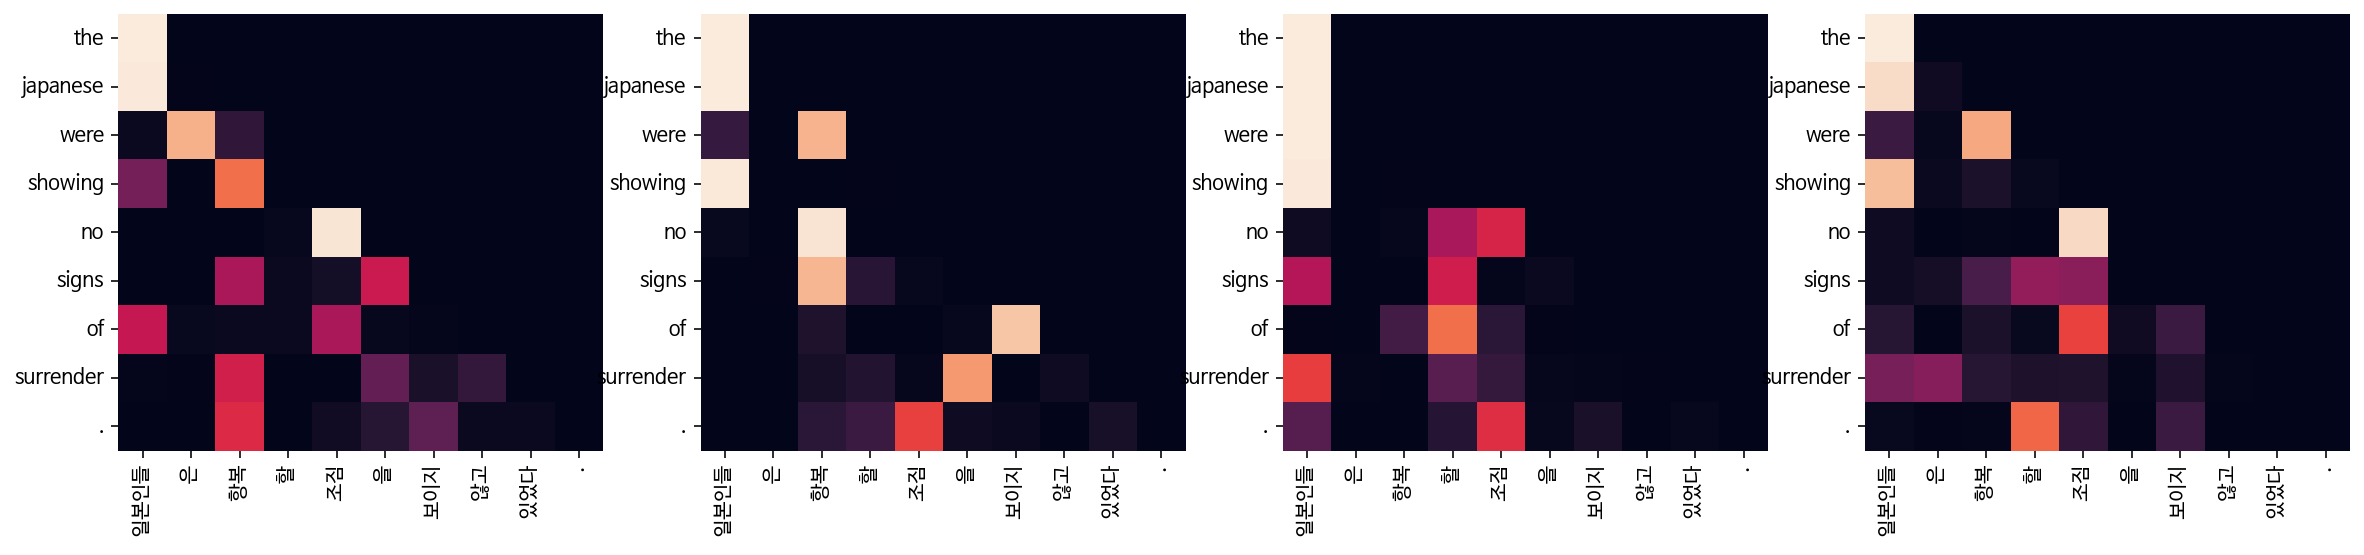

Decoder Self Layer 2


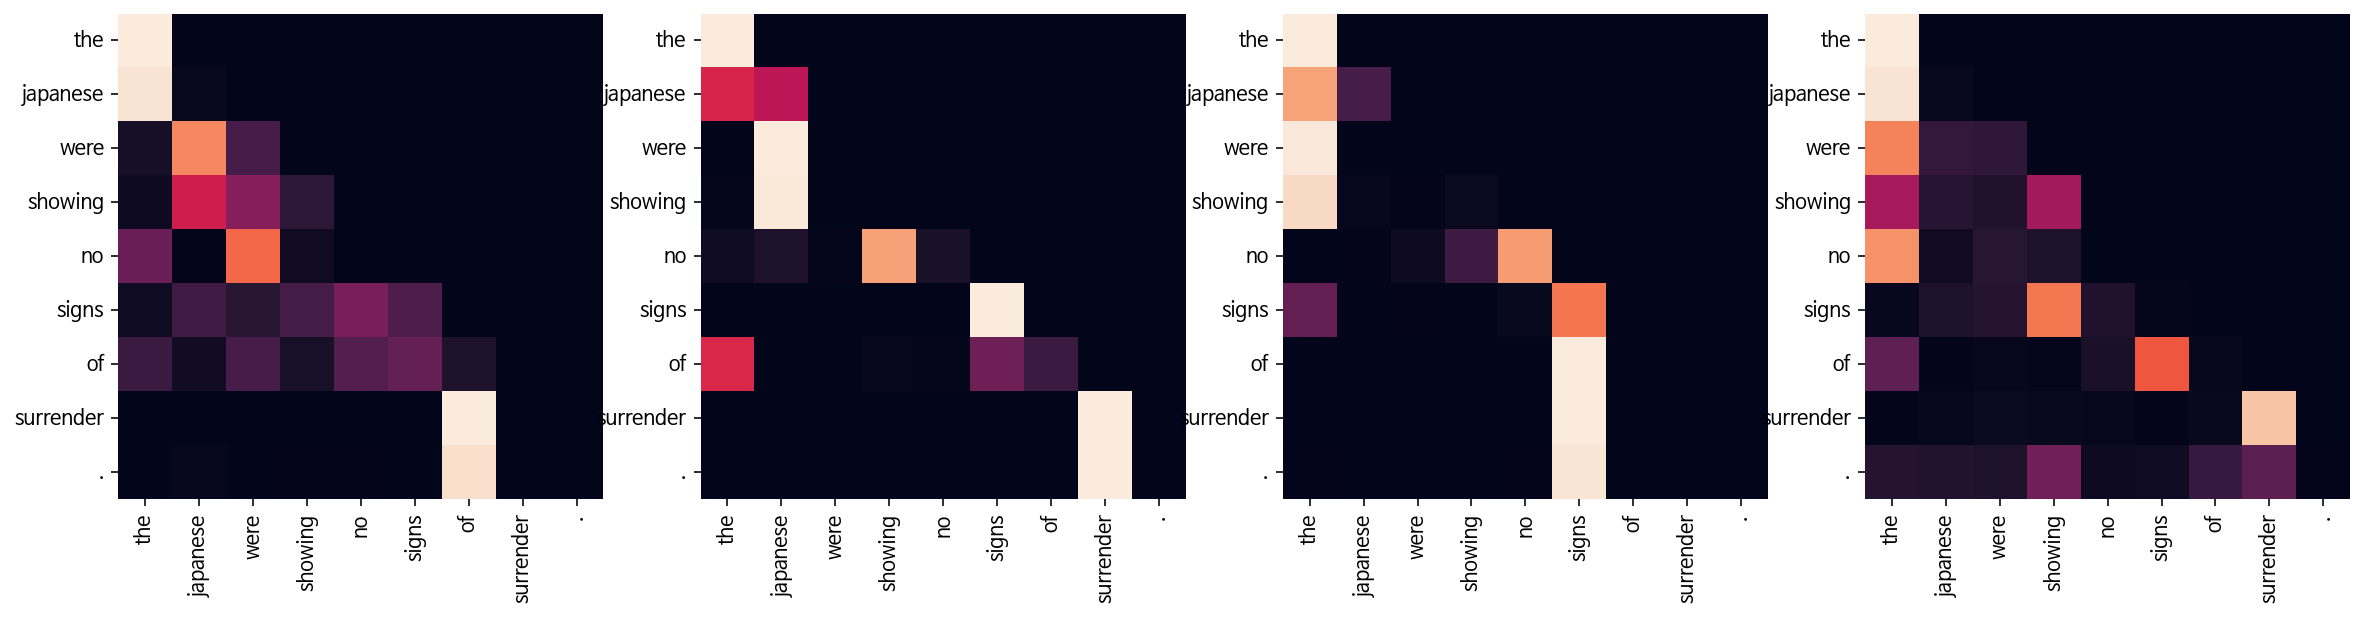

Decoder Src Layer 2


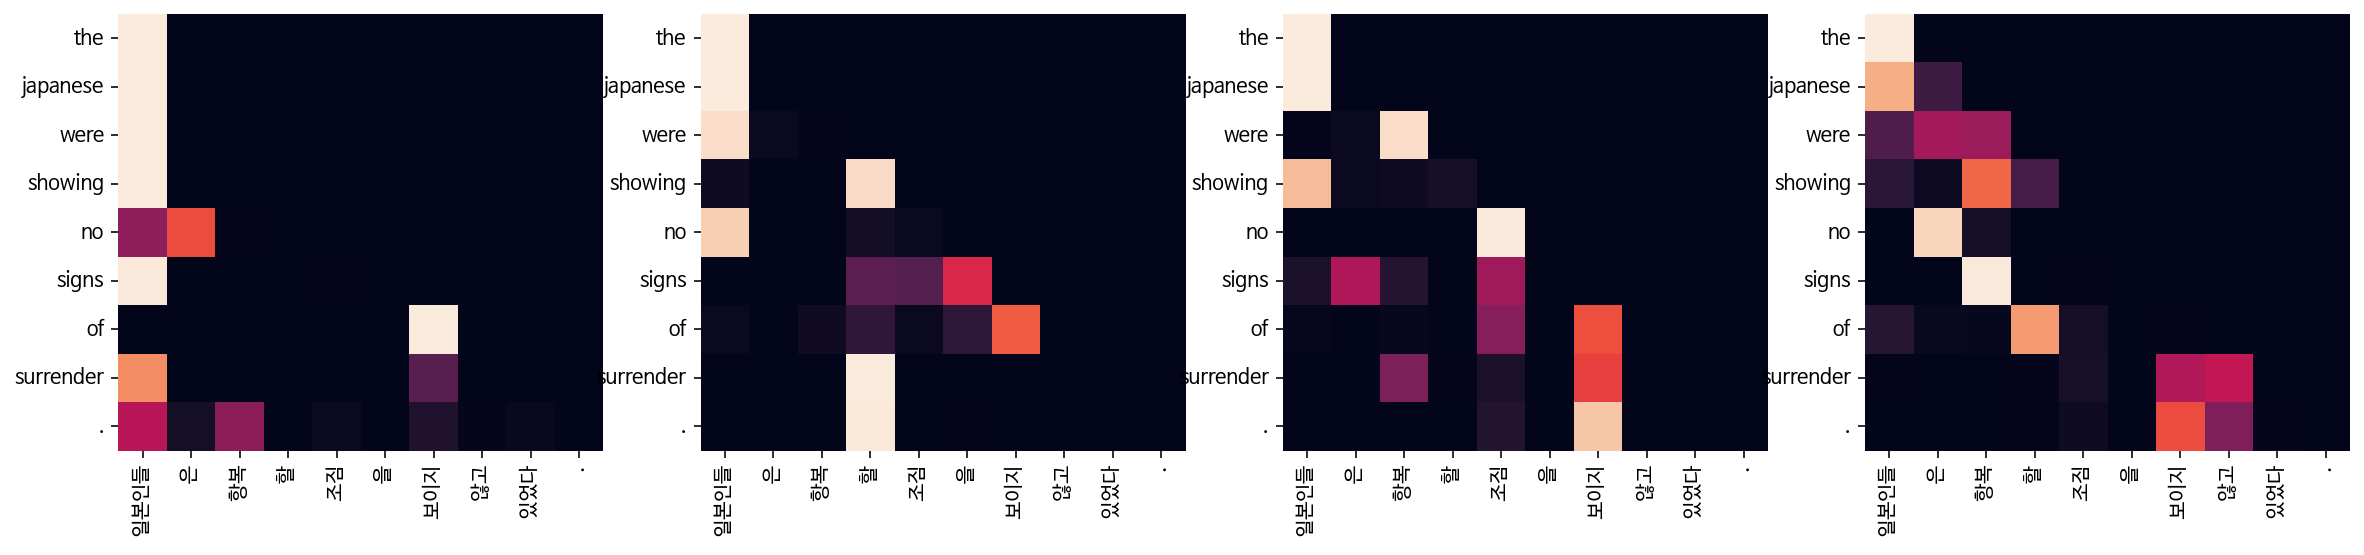

In [50]:
translate(
    "일본인들은 항복할 조짐을 보이지 않고 있었다.",
    transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

────────────────────────────────

▷ Input                ：나토는 소말리아 해적들이 영국 소유 화물선을 납치했다고 전했습니다.

▷ Predicted translation：nato says somali pirates have hijacked a british owned cargo ship .

Encoder Layer 1


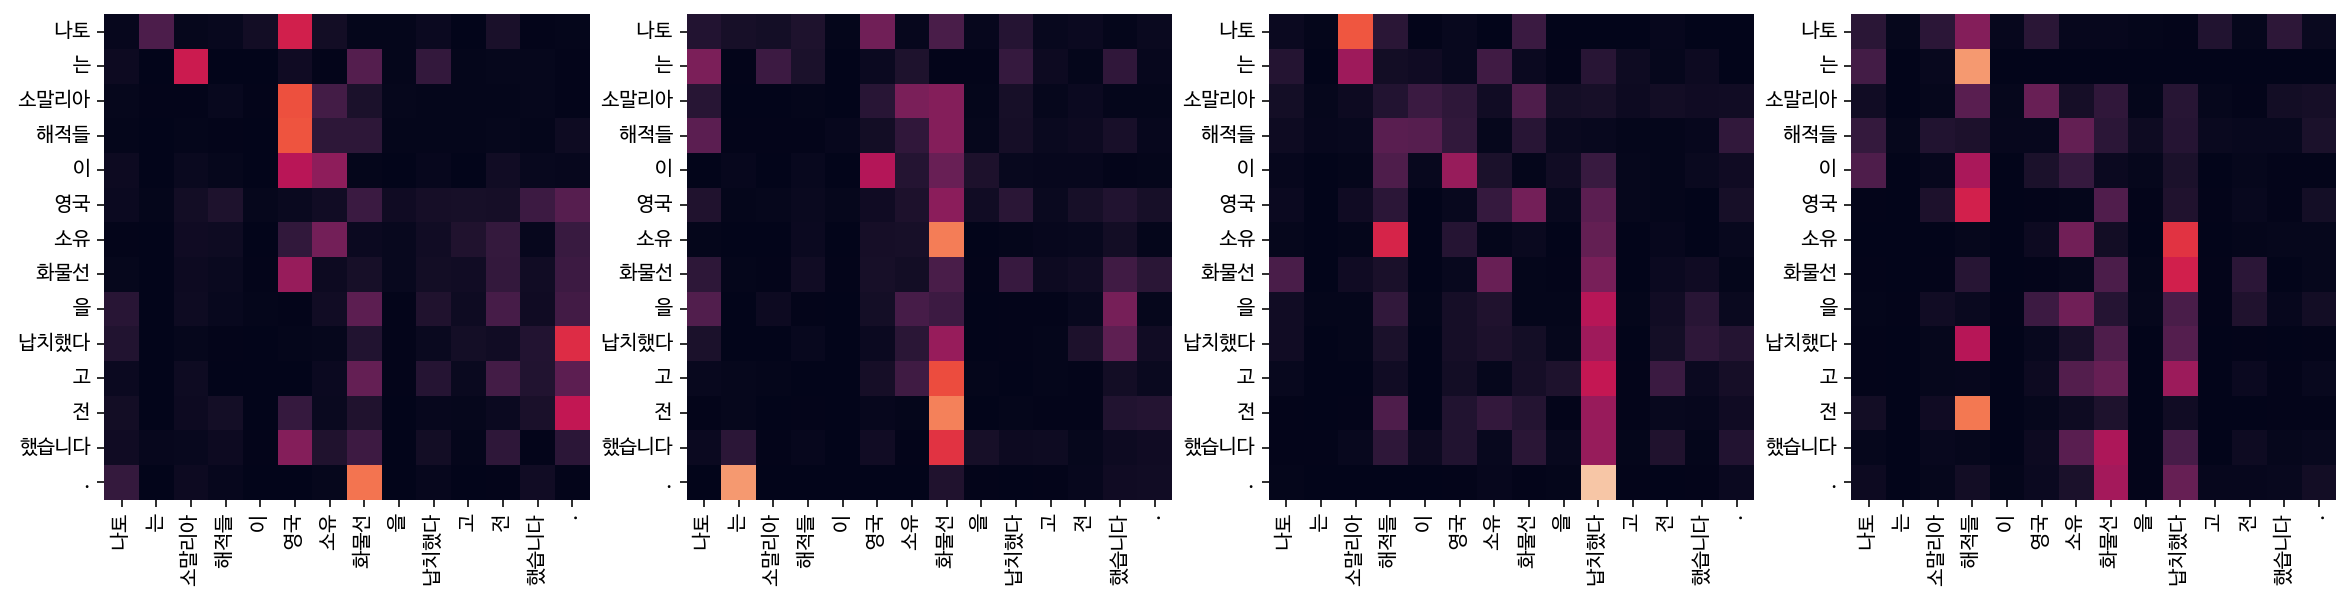

Encoder Layer 2


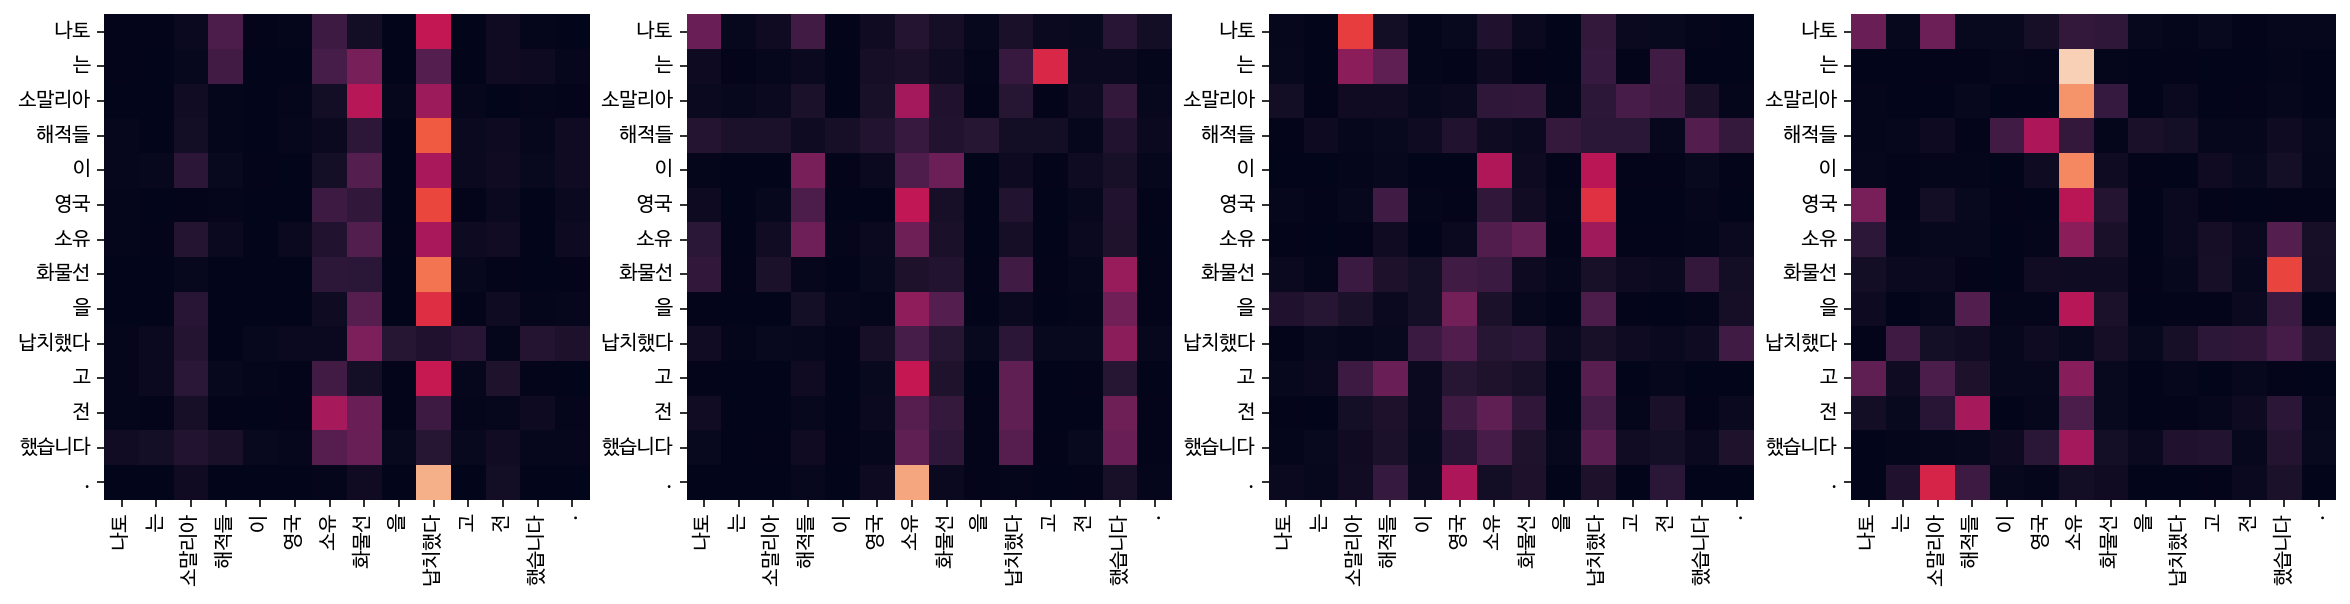

Decoder Self Layer 1


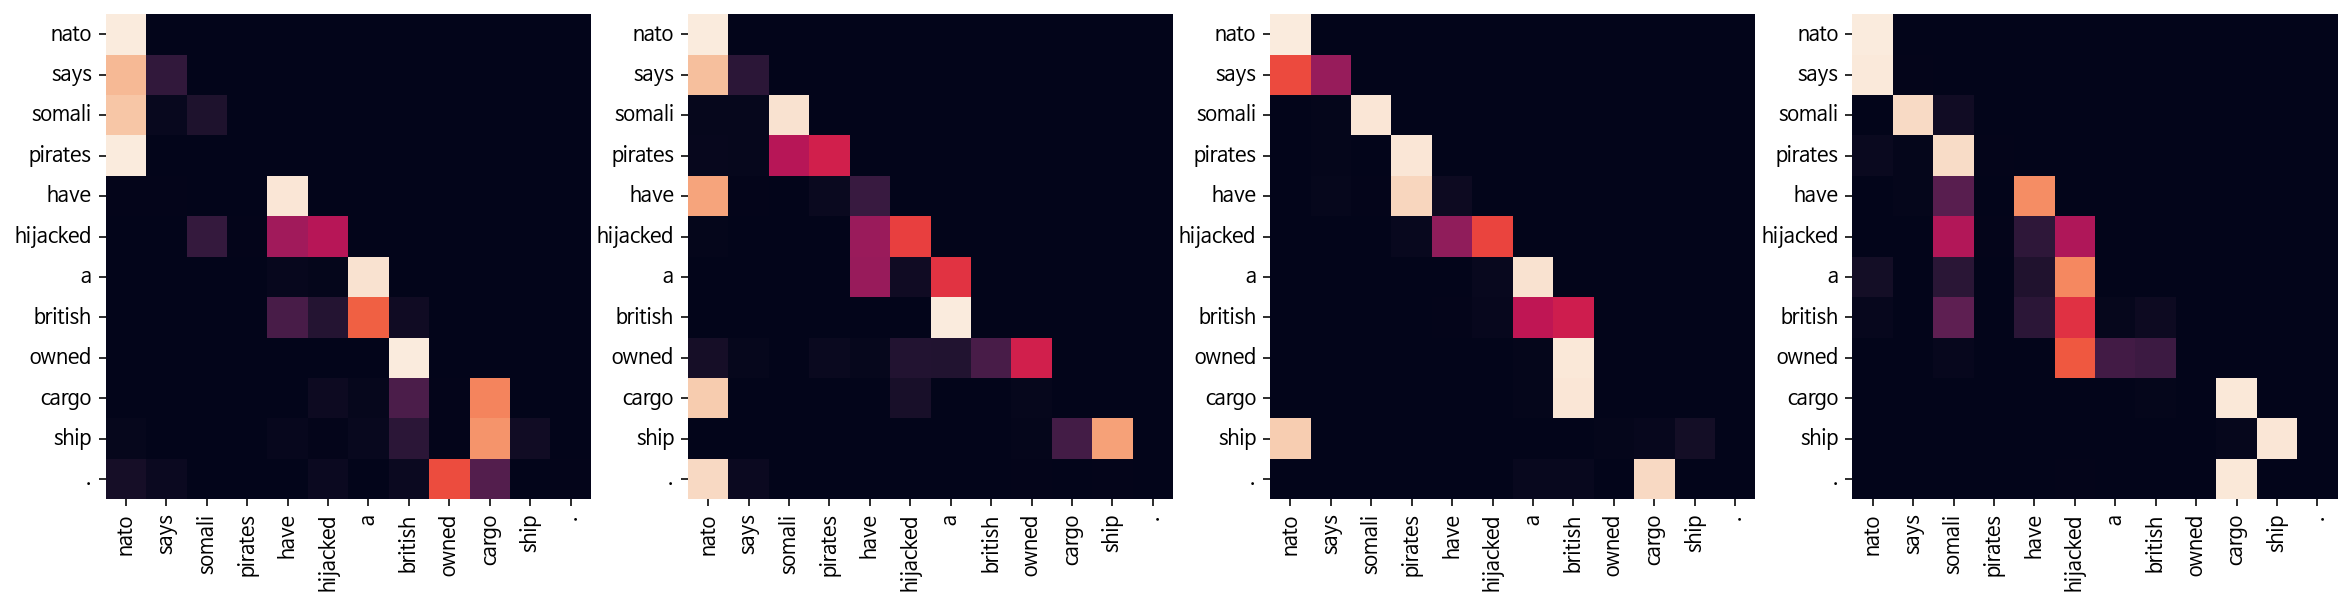

Decoder Src Layer 1


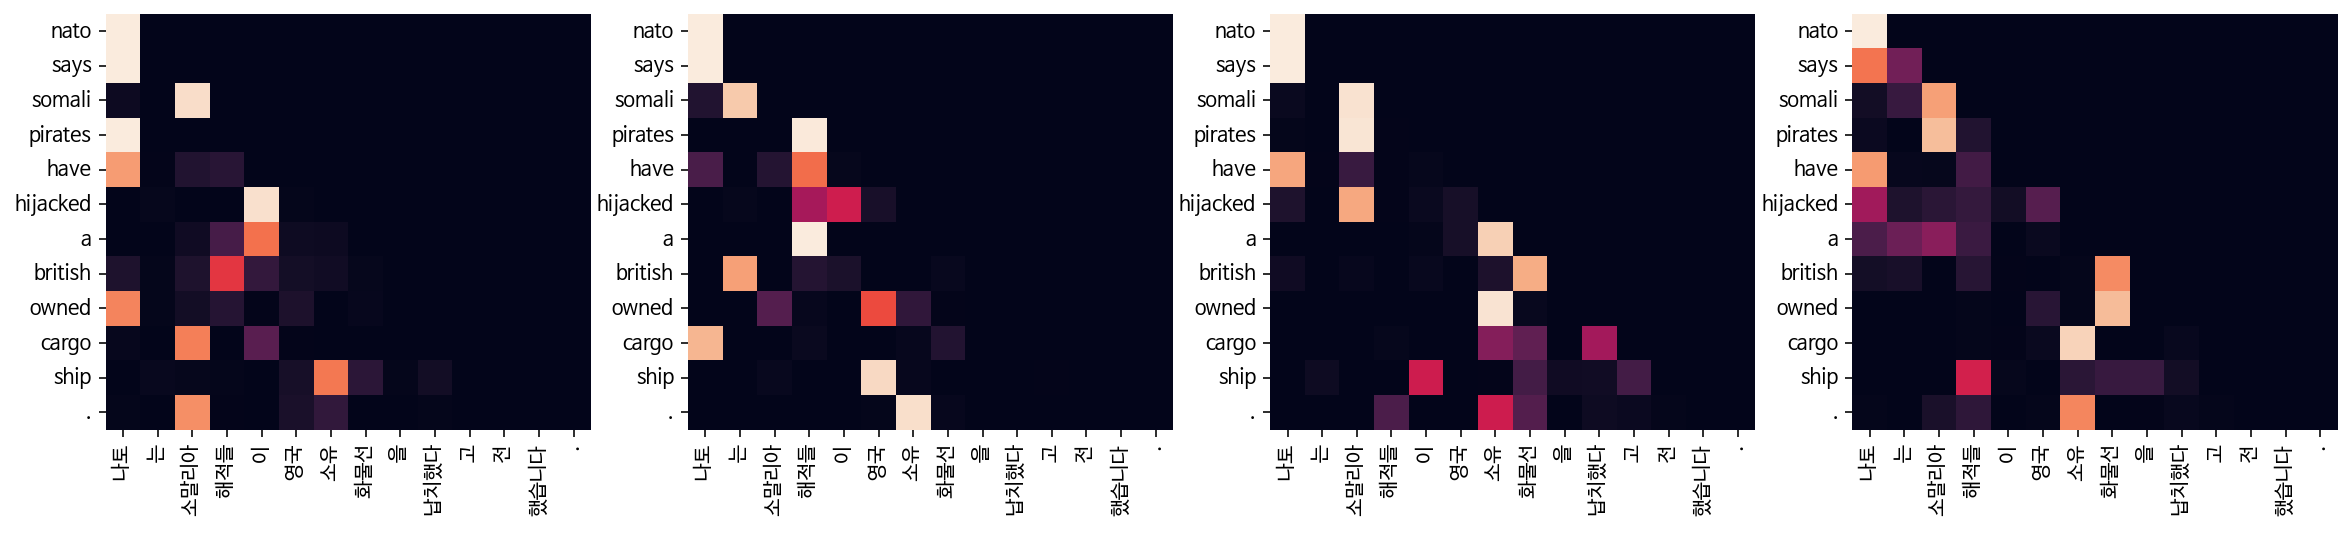

Decoder Self Layer 2


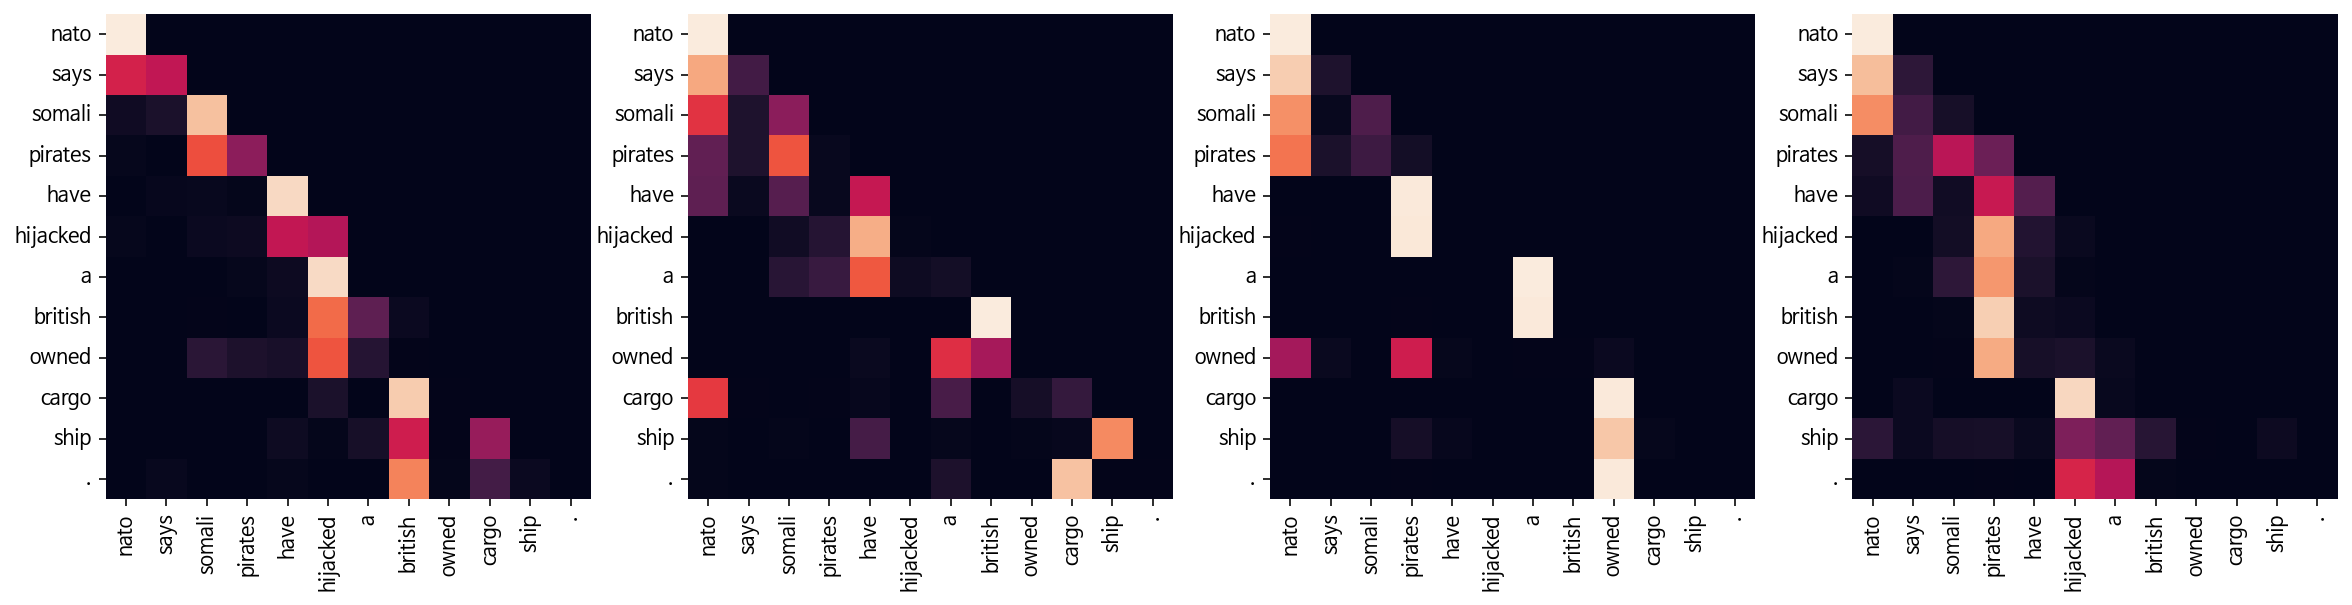

Decoder Src Layer 2


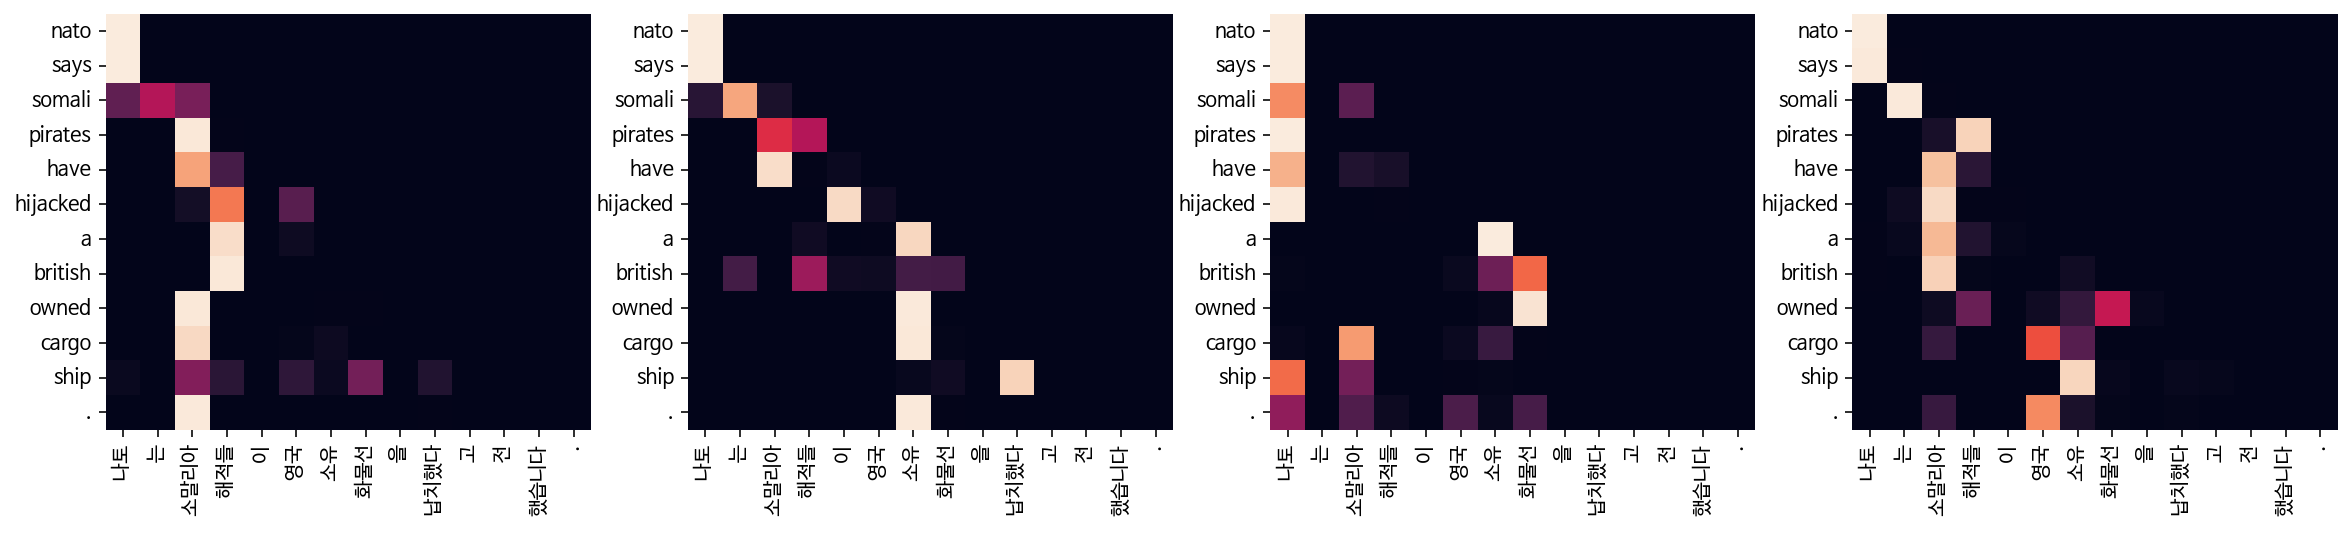

In [51]:
translate(
    "나토는 소말리아 해적들이 영국 소유 화물선을 납치했다고 전했습니다.",
    transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

────────────────────────────────

▷ Input                ：론스타는 어떠한 잘못도 없다고 주장하고 있기 때문이다.

▷ Predicted translation：lone star continues to deny any wrongdoing in its takeover of keb .

Encoder Layer 1


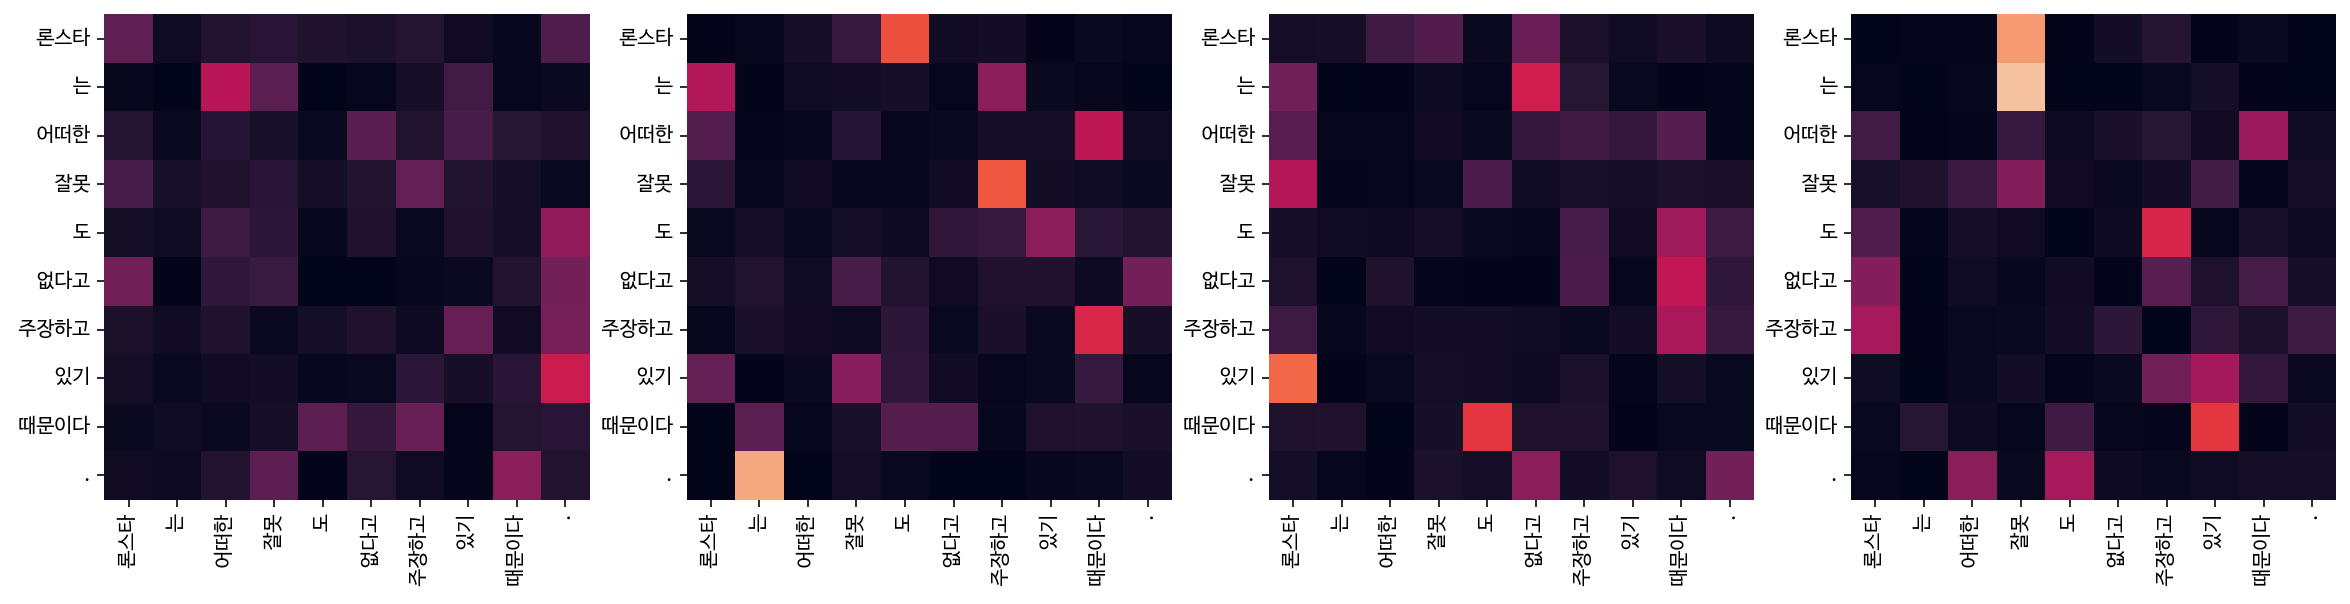

Encoder Layer 2


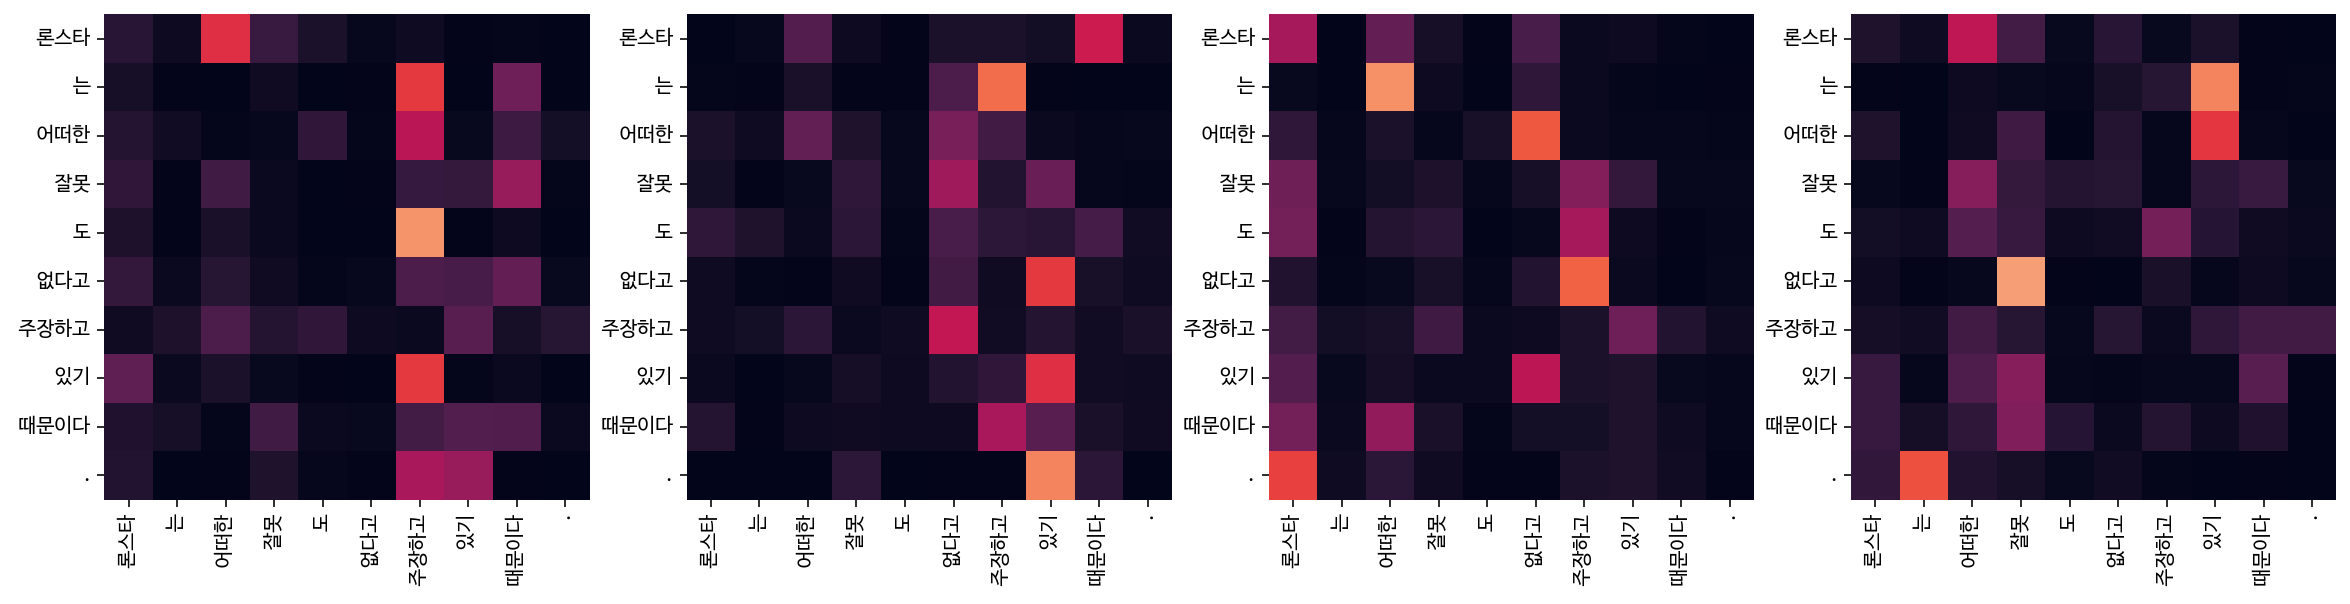

Decoder Self Layer 1


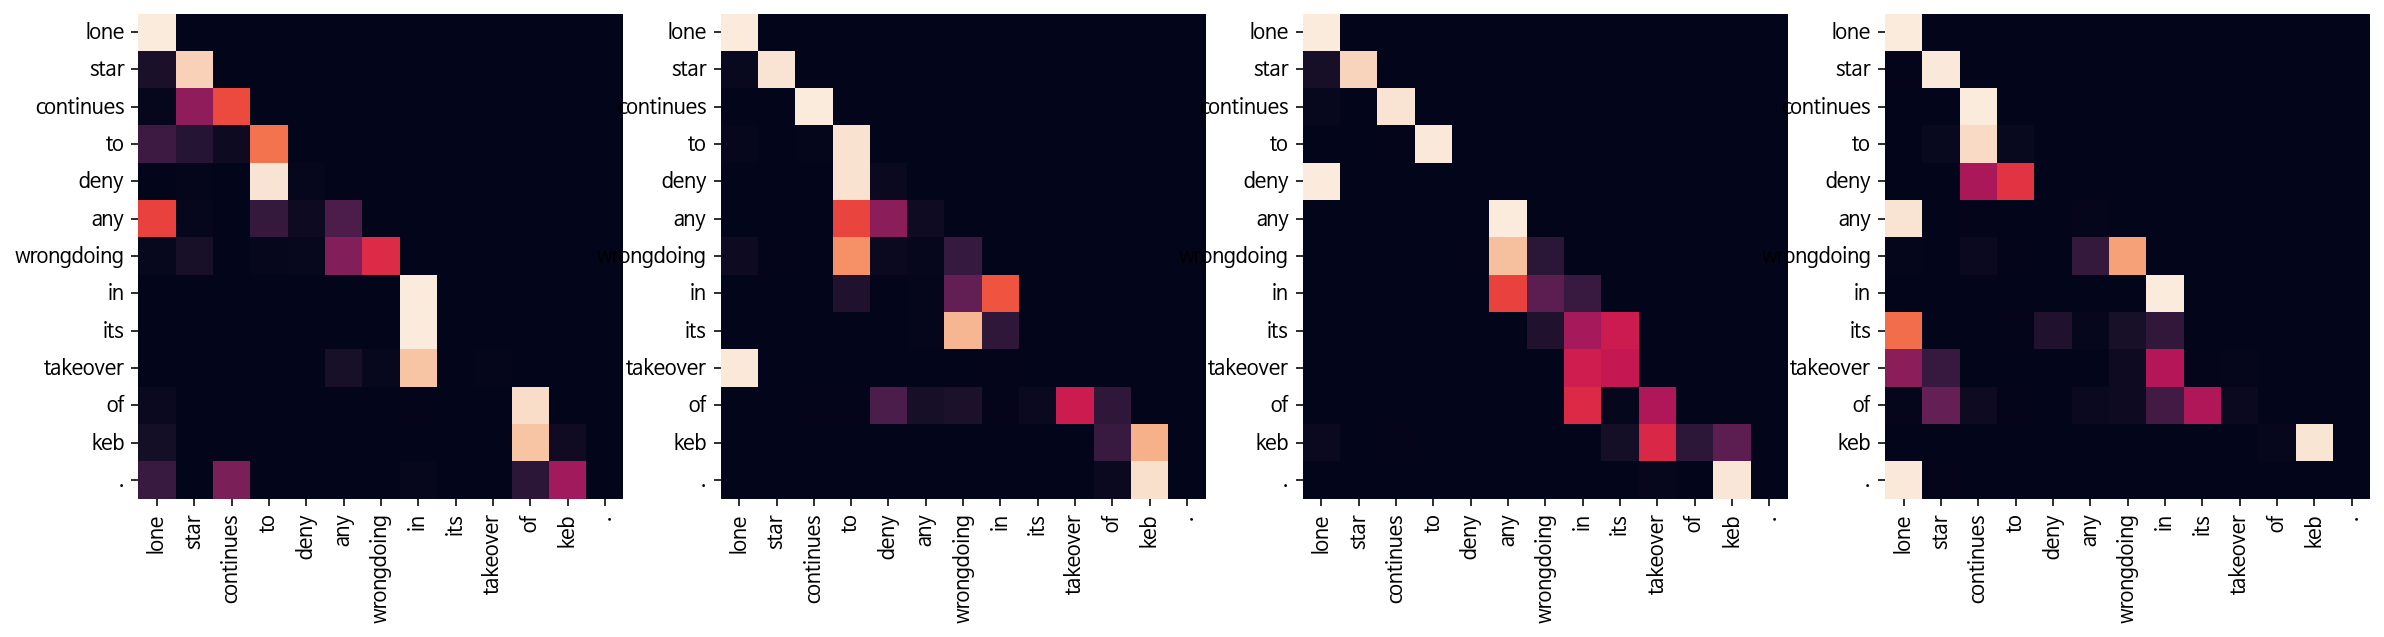

Decoder Src Layer 1


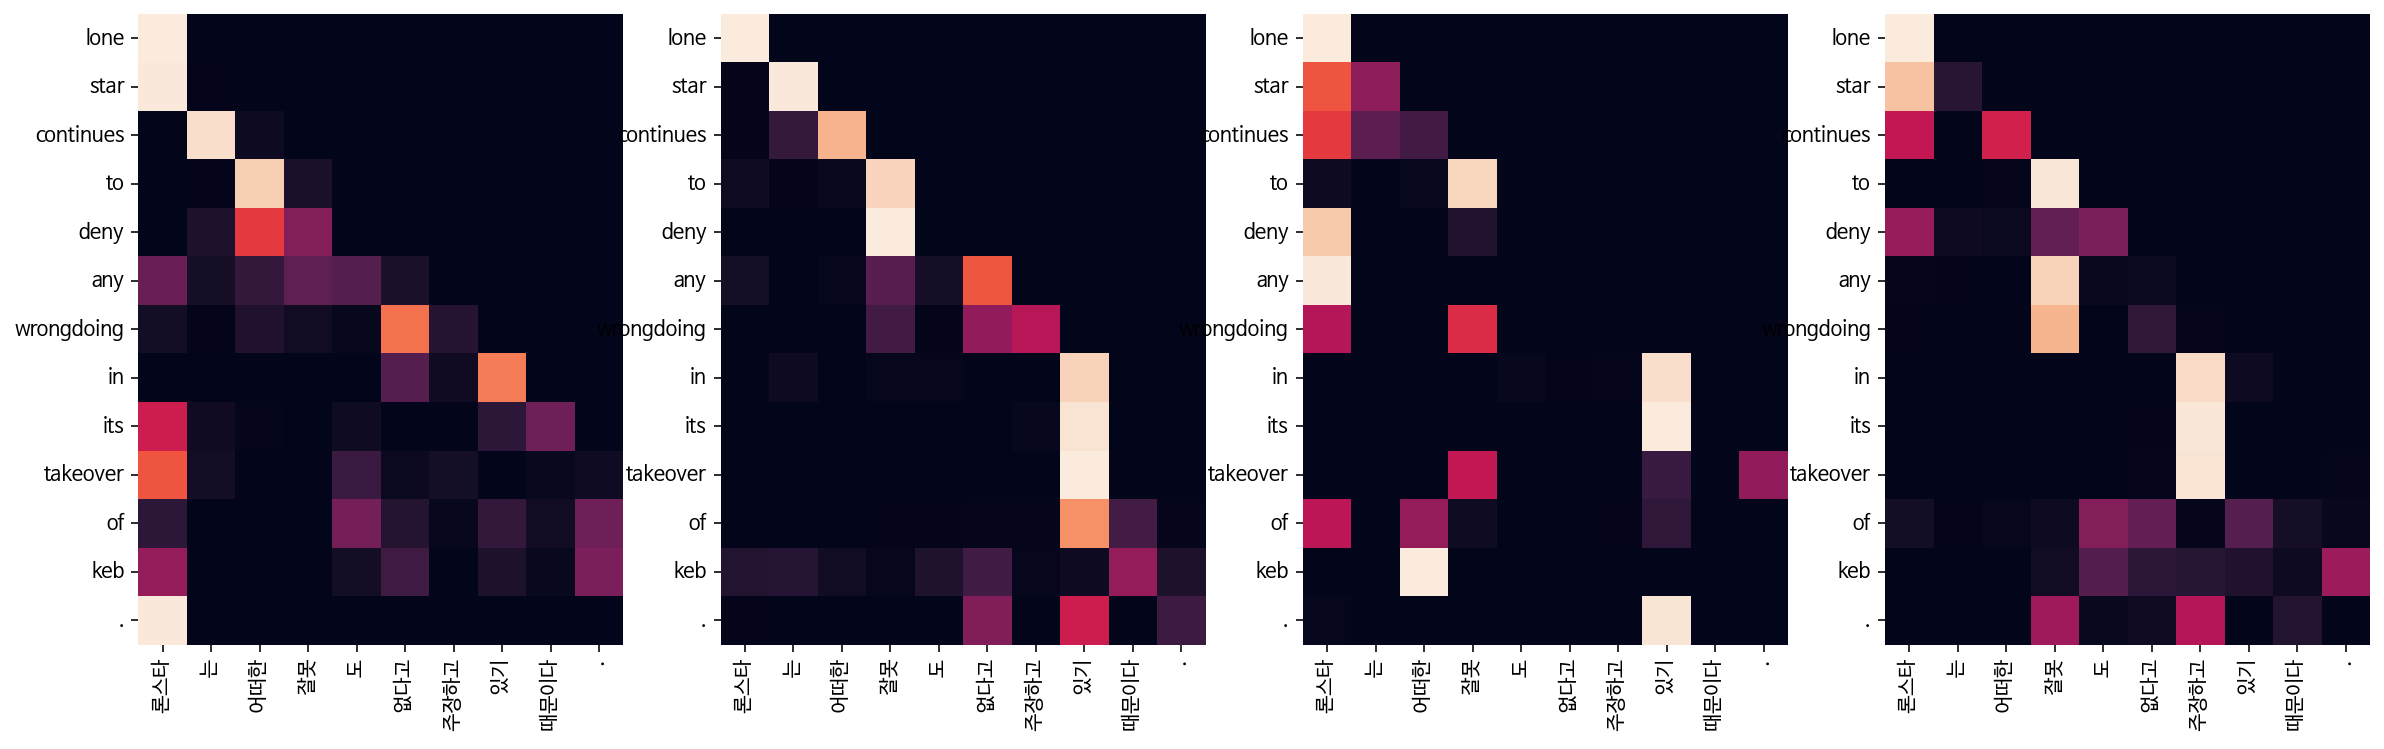

Decoder Self Layer 2


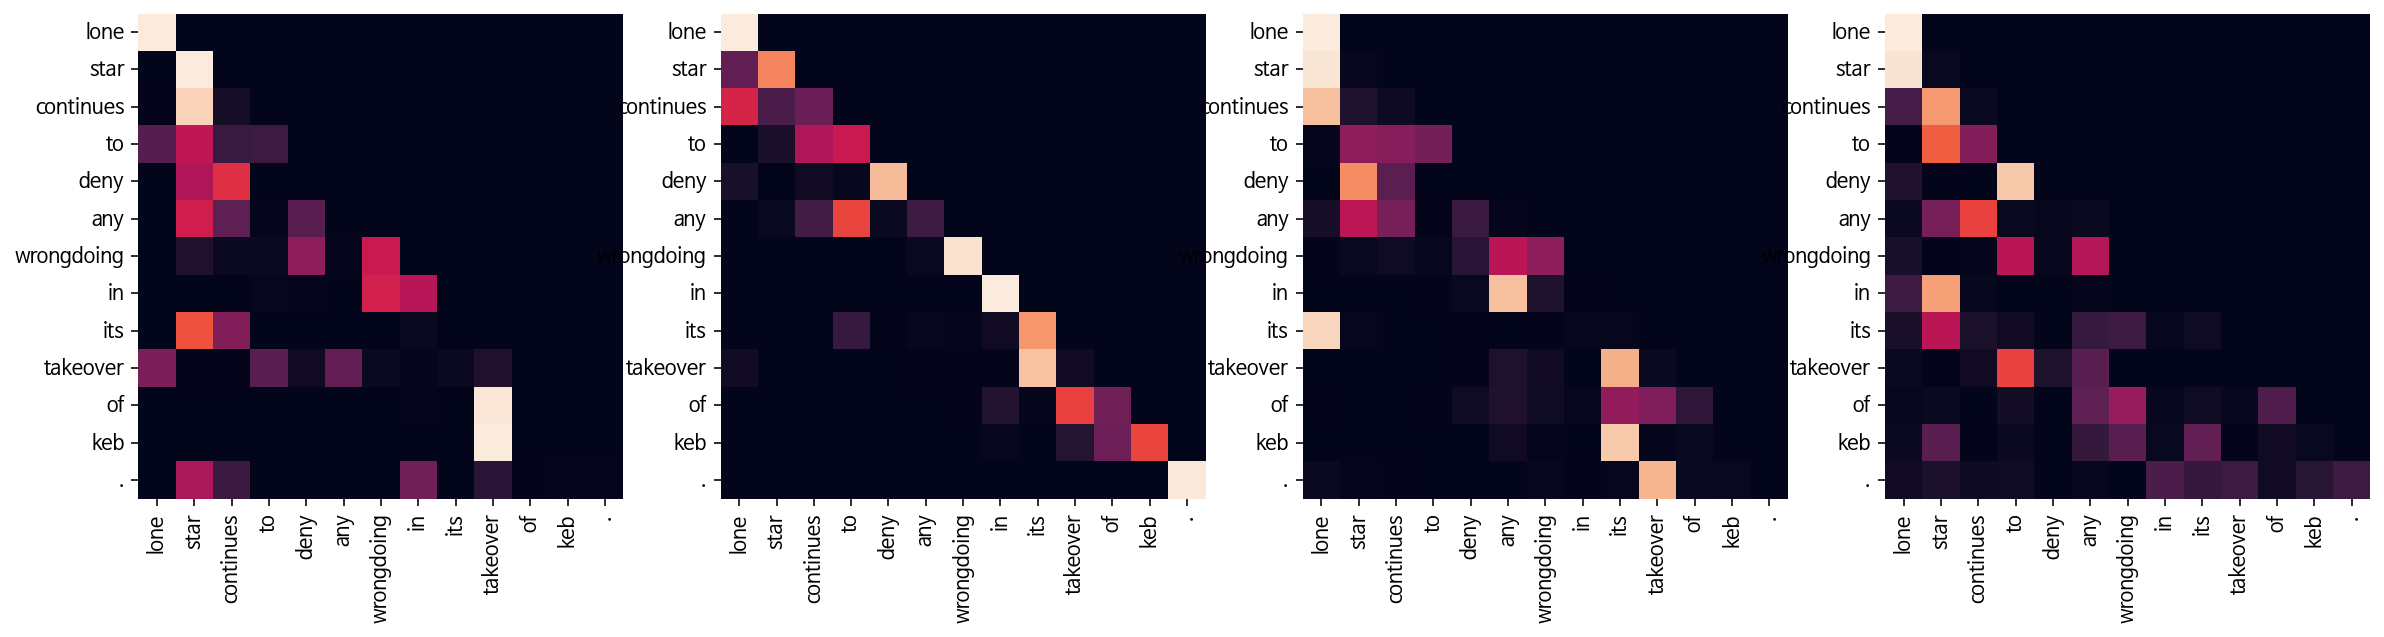

Decoder Src Layer 2


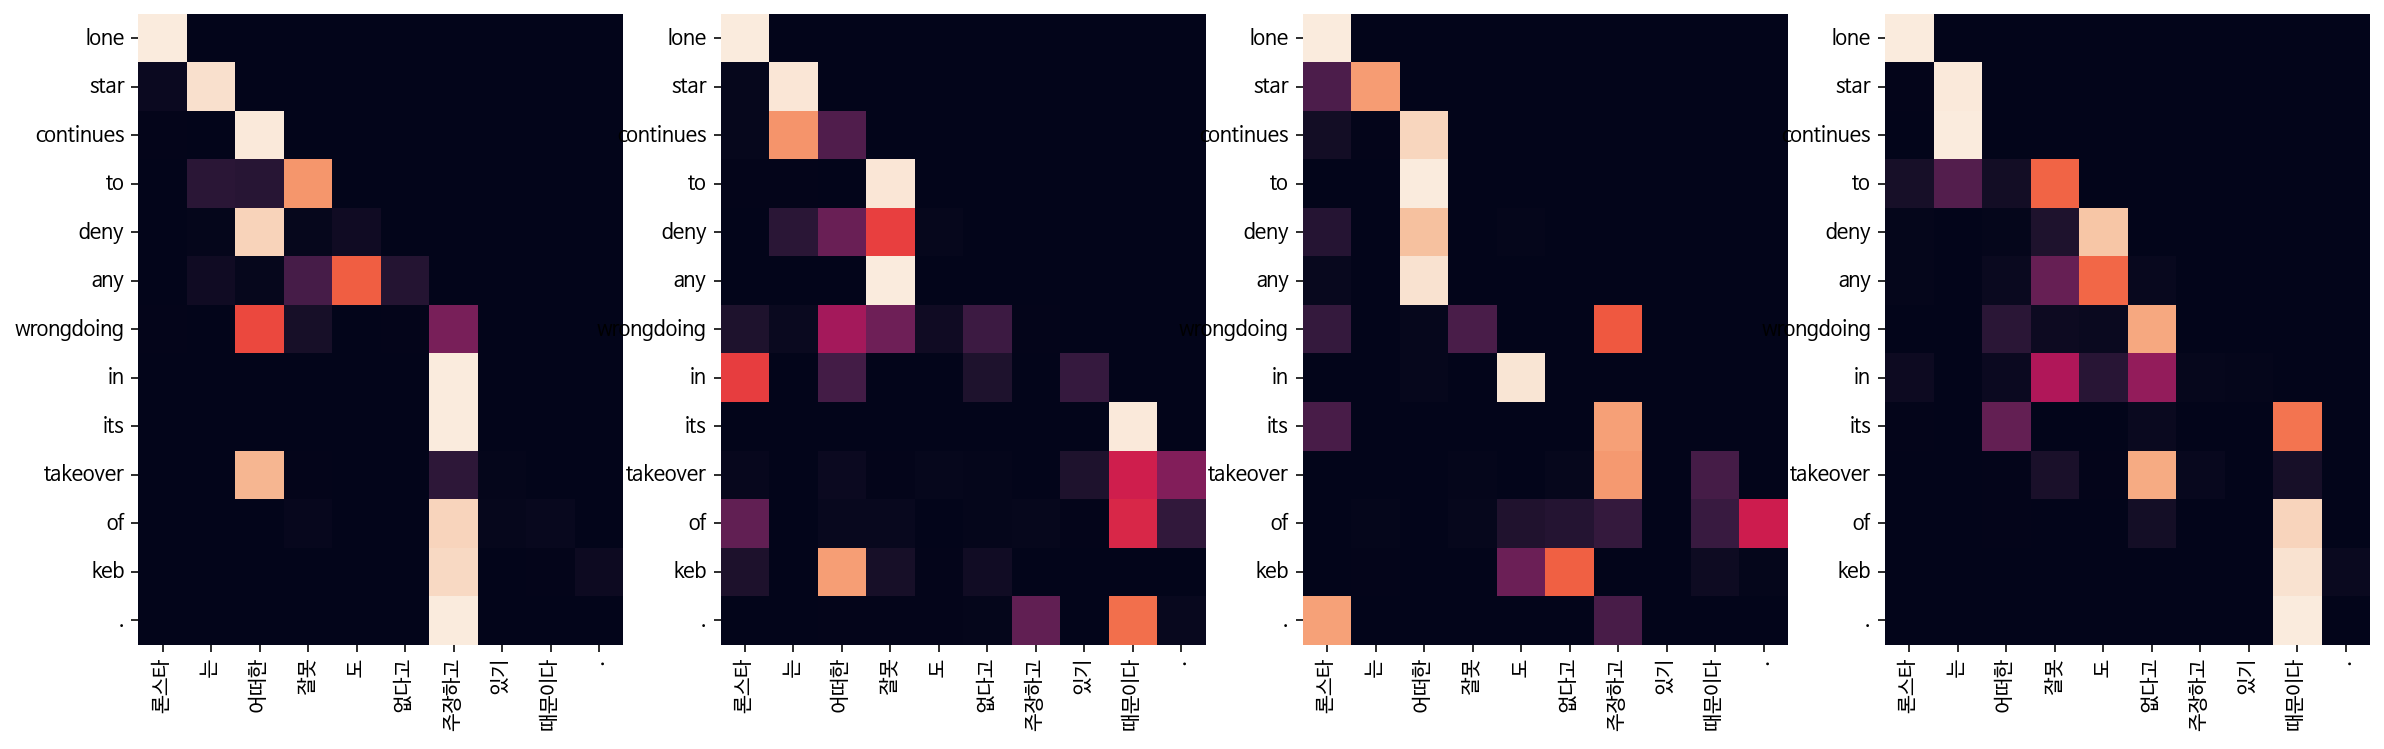

In [56]:
translate(
    "론스타는 어떠한 잘못도 없다고 주장하고 있기 때문이다.",
    transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

위의 내용들은 이전 번역기에서 사용했던 문장들을 넣어본 결과이다.

Attention map 확인을 하면서, 이전 번역기 모델에 비해 어느정도 개선이 되었을지 훑어 보기에 적절한 문장들이라 선택했다.

번역 결과를 정리하면 다음과 같다.


|#|원문|원문 → Transformer 번역|Transformer 번역 → Google번역|
|:-:|:--|:----------------------|:-----------------------------|
|1|고이즈미 총리는 최근<br> 야스쿠니 신사를 참배하여 중국을 자극했다.|koizumi visited the yasukuni shrine<br> wednesday .|고이즈미는 수요일<br> 야스쿠니 신사를 방문했습니다.|
|2|모든 항생물질들을 비웃고 있는<br> 세균들을 보게 되리라 생각됩니다.|we are waiting to see bacteria <br>that are literally laughing at all , <br>said to see their bacteria .|우리는 문자 그대로 전혀 웃지 않는<br> 박테리아를 보기를 기다리고 있습니다. <br>그들의 박테리아를 본다고 합니다.|
|3|어느 은행도 구체적인 답변을 주지 않았습니다.|none banks were banks aides <br>appeared to be provided .|어떤 은행도 은행 보좌관이<br> 제공된 것처럼 보이지 않았습니다.|
|4|아시아는 무서운 속도로 산업과<br> 경제를 발전시키고 있다.|asia has seen an urged global slower<br> than eu billion contract contracts .|아시아는 전 세계적으로 10억 계약<br> 계약보다 느리게 진행되는 것을 보았습니다.|
|5|일본인들은 항복할 조짐을 보이지 않고 있었다.|the japanese were showing no signs of surrender .|일본군은 항복할 기미가 보이지 않았다.|
|6|나토는 소말리아 해적들이<br> 영국 소유 화물선을 납치했다고 전했습니다.|nato says somali pirates have hijacked<br> a british owned cargo ship .|나토는 소말리아 해적들이<br> 영국 소유의 화물선을 납치했다고 말했습니다.|
|7|론스타는 어떠한 잘못도 없다고<br> 주장하고 있기 때문이다.|lone star continues to deny any wrong<br>doing in its takeover of keb .|론스타는 케브 인수 과정에서 어떤 잘못도<br> 계속해서 부인하고 있다.|

일부 번역문은 번역이 잘 이루어진것을 확인할 수 있지만, 전반적으로 만족스러운 결과라고 보기는 어렵다.

이전 번역기에서와 마찬가지로, 사용한 데이터가 좋지 못한것인지, 다양한 방법으로 많은 시간을 들여서

실험해 보았지만 아무래도 매 반복횟수마다 번역문이 변화무쌍하게 바뀌는 관계로, 이번 프로젝트는

이정도 결과에서 이만 실험을 마무리 해야 할 것 같다.

트랜스포머 챗봇 프로젝트에서는 결과를 보았을 때, 특별히 문제 삼을 만한것은 보이지 않았는데,

챗봇때에도 동일하게 오랜 시간을 들여 다양한 실험을 해 보았을때와 전반적인 결과 차이가 너무 크다.

챗봇때에 사용한 데이터가 보기드문 상당히 양질의 데이터였던 것 같다.

&nbsp;

### ■ 프로젝트 회고

<hr>

#### 1) 이번 프로젝트에서 '어려웠던 점'

트랜스포머 설계한 부분의 코드를 직접 작성하는데 머릿속이 하얘지고 사고회로가 정지했다.

이젠 예시도 없고, 이게 맞는건지 틀린건지도 모르는 상태에서, 예전에 했던 프로젝트들 망쳤더라면 큰일 날 뻔 했다.

예전 프로젝트들을 참고하여 코드 작성한것이 상당히 도움이 됐다. 그때 포기하지 않길 정말 잘했다는 생각이 들었다.

게다가 루브릭이 아니라, 기본적으로 코드를 작성해야 하는 부분들의 조건이 제시되어 있어서,

해당 부분에 맞게 코드를 만들어 넣는것도 쉽지 않은 일이었다.

식을 코드로 바꾸면 그럭저럭 어렵지 않은 코드들도 있었지만, 

문제는 내가 수포자라 공식도 봐도 모르고, 기호라던가 부호, 무슨 의미인지를 모르니 코드로 구현이 어렵다…

게다가 모델 훈련에 시간이 짧게 소요되는 것도 아니고… 답답하다.

#### 2) 프로젝트를 진행하면서 본인이 '학습한 내용'

실제 코드 채우고 찾아서 배치하는등의 내용이 많아서, 트랜스포머를 상당히 오래 붙들고 있었다.

최근에 진짜 트랜스포머만 공부하고 여기도 트랜스포머 저기도 트랜스포머 앞으로도 트랜스포머 나올거는 다 아는데,

이건 공부해도 딱 이거다 싶게 이해가 안된다. 수포자의 문제인가…

포지셔널 부분도 수식과 코드를 자꾸 비교하다보니, 그제서야 조금씩 이해가 되면서,

아 이 수식이 이 코드구나~ 그럼 다른것들도 살펴보자ㅡ 하면서 보다보니, 

왜 이런 코드들인지는 조금씩 이해되다가 또 다른거 보다 전에 봤던거 다시 보면, 까맣게 잊어버리고 있었던 것이다.

트랜스포머 모델 설계 할 때에는,

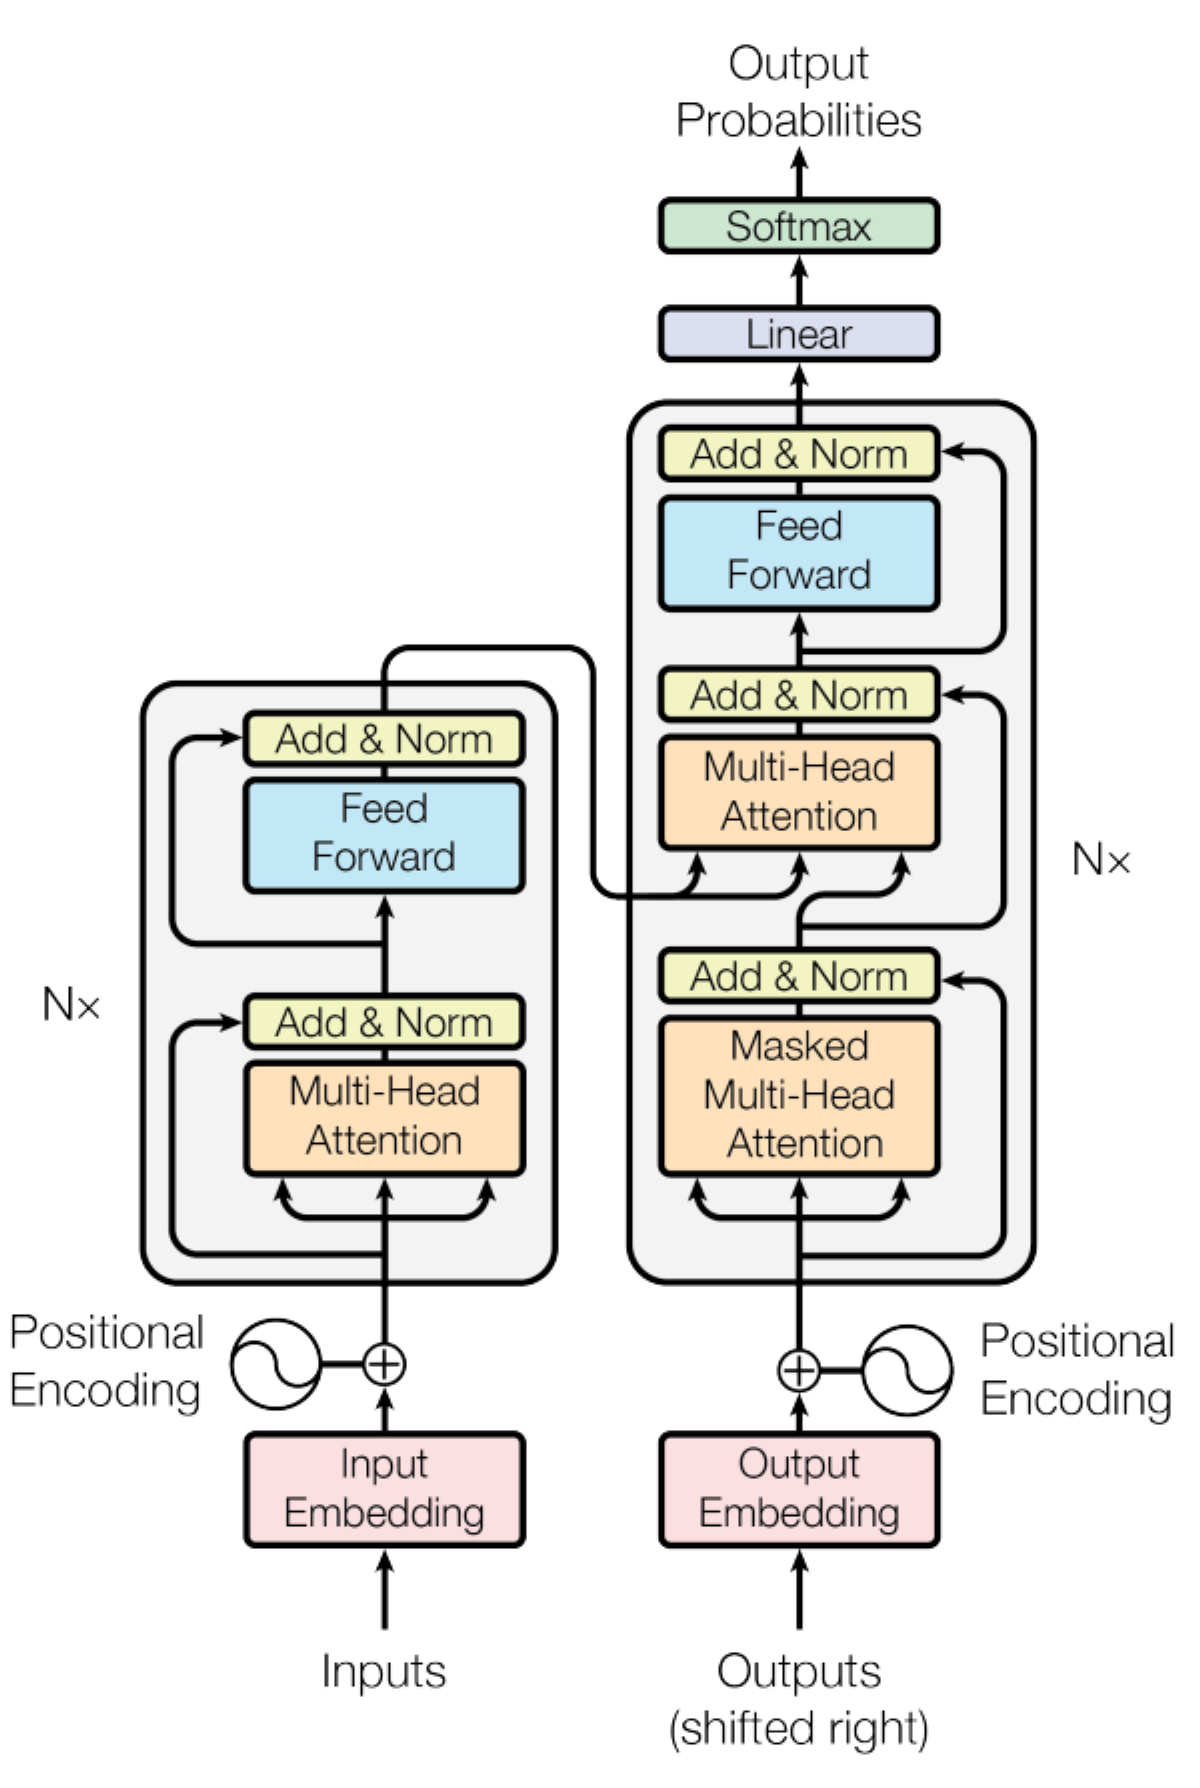

이 도식이 상당히 도움이 많이 됐다.

Attention is all you need 에서 이 그림 없었으면, 나는 진작에 포기했을수도.

#### 3) 프로젝트를 진행하면서 '알아낸 점' 혹은 '아직 모호한 점'

노드에서 BERT, GPT 등에 대한 내용도 살짝 언급을 했는데, 트랜스포머에서 개선을 해 나가는 모델인데

어떻게 트랜스포머에서 인코더나 디코더를 없애버리는데 더 좋아진다는 건지 의문이다.

트랜스포머에서 더 복잡해질거라고 생각했는데, 상당히 당황스럽다.

물론 뭐 트랜스포머에서 인코더만 쓴다느니 디코더만 쓴다느니 하는것도 그냥 멀리 넓게 보고 말한 것이고,

실제로는 내부적으로 처리해야 하는 어텐션이라던지 그런것들이 더 복잡해지고 어려워 질 수 있을지도 모른다.

그치만, 난 어텐션도 무서워 하잖아… 아니 점점 생략했다고 하는데, 더 이해하기는 복잡해지고 있다.

이게 진짜 뭐 덜어낸거 맞는건지? 트랜스포머도 어텐션만 쓰면 된다는데, 속은 느낌인데… 어질어질하다.

역시 어텐션은 정말 어려운 것이다.

#### 4) 루브릭 평가 지표를 맞추기 위해 '시도한 것들'

이 프로젝트 결과를 보기 위한 노력. 

내용이야 어떻든 간에 에러 없이 번역이 실행되는 코드 작성이다.

루브릭 지표가 아니라, 프로젝트 명세 부분을 따라가면서 진행하고,

망할 것 같았지만, 어떻게든 완성을 하고 난 뒤에 돌아보았다.

다시보니, 루브릭 내용들은, 프로젝트의 완성에서 그냥 공짜로 얻어지는 것 같은 결과였다.

그 외에, 특별히 루브릭을 목표로, 추가로 시도한 내용은 없다고 볼 수 있다.

#### 5) 만약에 '루브릭 평가 지표를 달성하지 못했을 때, 이유에 관한 추정'

데이터 전처리의 경우에는 이전 프로젝트들을 무사히 마쳤다면 하나정도는 기본적으로 확보라고 할 수 있겠다.

나머지는 트랜스포머의 구현과, 포기하지 않는 근성, 어느정도 정상적인 번역 결과에 달려있다고 볼 수 있다.

나도 초기에는 모든 문장에 대해 ＂the＂라는 단어만 반복되는 번역이 나오다가, ＂the＂ 가 ＂.＂ 으로 바뀌었다가…

난리도 아니었다. 멘탈붕괴가 찾아와서 1년 이상 끊었던 음주를 다시 할 뻔 했다.

다행스럽게도 계속된 실험들을 통해 다른 단어가 나타나면서 슬슬 트랜스포머 모델의 학습도 정상화 되어갔으니 망정이지.

만약 루브릭 평가 지표를 달성 하지 못했다면, 결과적으로 플젝을 아예 포기했다거나 하는 등의 이유 말고는

그래도 전처리에 해당하는, 1번째 루브릭은 어려운 조건은 아니라고 생각한다.

나머지는 얼마나 끈기를 갖고 공부와 실험을 해 나아가느냐 하는, 개인이 노력 하기 나름이라고 본다.

#### 6) 자기 다짐

밀려가는 여러 프로젝트들 최대한 집중한다고 하고 달려들었는데, 

그나마 계획보다 살짝 늦은 정도로 마무리를 지을 수 있었다.

밀려있는 것들이 아직 남아있긴 하지만, 그래도 많이 해결했다.

지금까지 계속 밀려 있던 프로젝트들에 끌려다니던 것에 비하면…

이번 트랜스포머 다루는 프로젝트들을 빨리 마무리 하려는 생각조차 없었으면,

지금쯤 또 멍하니 모니터 바라보면서 멘붕의 시간을 가지고 있었을지도 모른다.

이러고 있을 때가 아니다, 점점 더 어렵고 시간도 많이 든다고 했는데,

더 미루지 말고, 최대한 남아있는 밀려있는 것들을 해결하기 위해서 달려야겠다.

&nbsp;

<hr>

## ◎ Reference


- (AIFFEL) Going Deeper Node 02. 멋진 단어사전 만들기

- (AIFFEL) Going Deeper Node 07. Seq2seq와 Attention

- (AIFFEL) Going Deeper Node 08. Seq2seq으로 번역기 만들기

- (AIFFEL) Going Deeper Node 09. Transformer가 나오기까지

- (AIFFEL) Going Deeper Node 10. Transformer로 번역기 만들기

- (AIFFEL) Exploration Project Node 10. 번역기를 만들어보자

- (AIFFEL) Exploration Project Node 14. 뉴스 요약봇 만들기

- [한국어 위키 텍스트](https://ko-nlp.github.io/Korpora/ko-docs/corpuslist/kowikitext.html)

- [언어 이해를 위한 변환기 모델](https://www.tensorflow.org/text/tutorials/transformer)

&nbsp;